<h1> ______________________________________ </h1>

<h1> Time and Energy resolution calculation </h1>
<h1> ______________________________________ </h1>

<p style="font-size: 17px; color: black;"> In this Notebook we calculate the energy and time resolution of our photosensor (SiPM Hamamatsu in this case) the following way:</p>

- <p style="font-size: 17px; color: black; font-weight: bold;"> Time resolution: </p> 
<p style="font-size: 17px; color: black;"> We set a voltage threshold and we measure the time difference between when our signal and our trigger waveform pass that threshold. The std of that time difference distribution will be our time resolution. The time resolution is not the same for all signals so we differentiate among signals of 1pe, 2pe, 3pe, etc. </p> 


- <p style="font-size: 17px; color: black; font-weight: bold;"> Energy resolution: </p> 
<p style="font-size: 17px; color: black;"> We save for each waveform the value of the peak, then we do the distribution of that value for each waveform type, ie we do different distributions separating waveforms corresponding to 1pe, 2pe, 3pe, etc. The std of that peak distribution will be our energy resolution. </p> 


<h1> ____________ </h1>
<h2> This version </h2>
<h1> ____________ </h1>

-  <p style="font-size: 17px; color: black;"> Unified Y11 and B2 notebook. </p>
-  <p style="font-size: 17px; color: black;"> 10K events each fibers. </p>
-  <p style="font-size: 17px; color: black;"> Let's try and work with ALL events. </p>
-  <p style="font-size: 17px; color: black;"> The photosensor signal saturates (there are values considered inf). </p>
-  <p style="font-size: 17px; color: black;"> Waveforms include just 1 peak. </p>
-  <p style="font-size: 17px; color: black;"> Signal happens AFTER THE TRIGGER. </p>


-  <p style="font-size: 17px; color: black;"> Use interpolation to get the EXACT time at which the waveform cuts the threshold. This way we can basically work with a function intead of the data. </p>


-  <p style="font-size: 17px; color: black;"> Calculate chi2 manually cause to use the built in function, the fit has to be normalized and we don't understand why. </p>
-  <p style="font-size: 17px; color: black;"> Variable bining in the distributions as sqrt(Nevents). </p>


-  <p style="font-size: 17px; color: black;"> Instead of obtaining the Npe peaks ad hoc we do it finding the peaks in the maximums distribution. </p>
-  <p style="font-size: 17px; color: black;"> Same way use this distribution to determine dV from each peak to get rid of the in between events. </p>


-  <p style="font-size: 17px; color: black;"> We can choose between a variable or a fixed threshold with fix_th = True/False. </p>


-  <p style="font-size: 17px; color: black;"> Energy distribution in % instead of absolute values. </p>
-  <p style="font-size: 17px; color: black;"> Fit the sigma vs $ N_{pe} $ plot to the corresponding cuadratic sum of terms. </p>



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
import math

In [3]:
import scipy
from scipy import stats, integrate
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.optimize import root, root_scalar

In [4]:
import os

<h1> _________________________________________________________________________________________________________ </h1>


<h1> __________________________ </h1>
<h2> Functions </h2>

-  <p style="font-size: 17px; color: black;"> <b> gauss(x, a,  mu, sigma): </b> Gaussian normalized to $a$. </p>


-  <p style="font-size: 17px; color: black;"> <b> f_cut(x, f, val): </b> To find the cut of a $f(x)$ function with a certain value $val$ we first use <b> f_cut </b> to move $f(x) \rightarrow f(x) - val$ and then find it's roots, ie, $f(x) - val = 0$. </p>


-  <p style="font-size: 17px; color: black;"> <b> resolution_eq(E, a, b, c): </b> Resolution equation to which our results should fit. </p>



In [5]:
# Gaussian
# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
# def gauss(x,  mu, sigma):
    
    gaussian = stats.norm.pdf(np.sort(x), mu, sigma) 
    
    return (a/gaussian.sum())*gaussian 
#     return (x.sum()/gaussian.sum())*gaussian 

# Function offsetting
# To find the cut of a function with a certain value first we offset the function then find the roots
def f_cut(x, f, val):
    return f(x) - val

# Resolution equation
def resolution_eq(E, a, b, c):
    
    res = np.sqrt( (a/np.sqrt(E))**2 + (b/E)**2 + c**2)
    
    return res


-  <p style="font-size: 17px; color: black;"> <b> wave_prep(file): </b> Take a waveform and prepare it to work with it. </p>



In [83]:
def wave_prep(file_name, fiber, waveform_saturation = np.inf):
    
    input_file = os.path.join(path[fiber], file_name)
    
    # Read the CSV file using pandas
    df = pd.read_csv(input_file, header=14)
    
    time = np.array(df['TIME']*1e6) # [us]
    signal = np.array(df['CH1']*1e3) # [mV]
    LED = np.array(df['CH2']*1e3) # [mV]

    # Offsets
    offset_LED = LED[LED < 0].mean(); LED = LED - offset_LED

    offset_signal = signal[signal < 0].mean(); signal = signal - offset_signal
    
    
    # Saturation
    signal = np.where(signal < waveform_saturation, 
                      signal,
                      signal[signal < waveform_saturation].max())
    
    return time, signal, LED

In [82]:
df

TIME    CH1    CH2
0    -5.987000e-08 -0.036 -0.007
1    -5.971000e-08 -0.040 -0.007
2    -5.955000e-08 -0.040 -0.007
3    -5.939000e-08 -0.032 -0.007
4    -5.923000e-08 -0.032 -0.007
...            ...    ...    ...
6245  9.393300e-07  0.040  0.009
6246  9.394900e-07  0.036  0.009
6247  9.396500e-07  0.036  0.009
6248  9.398100e-07  0.036  0.009
6249  9.399700e-07  0.036  0.009

[6250 rows x 3 columns]

<h1> __________________________ </h1>
<h2> Data </h2>

-  <p style="font-size: 17px; color: black;"> <b> Reading the file </b> </p>

-  <p style="font-size: 17px; color: black;"> File's path </p>

In [71]:
# filename = []
path = {}

init_path = '/home/investigator/mariandbt/python/data/'

path['y11'] = init_path + '20230508/'
path['b2'] = init_path + '20230525' + '_t_res_b2/'

-  <p style="font-size: 17px; color: black;"> Read the file. </p>

In [72]:
data = {}
data['y11'] = []
data['b2'] = []

In [73]:
files = {}

In [74]:
# Get all files in the folder
files['y11'] = os.listdir(path['y11'])
files['b2'] = os.listdir(path['b2'])

In [10]:
max_files_used = int(len(files['y11'])/3)
max_files_used = int(500)
# max_files_used = int(len(files['y11']))

print('We are using %s files out of %s'%(max_files_used, len(files['y11'])))

We are using 500 files out of 10000


In [25]:
import csv

# input_file = os.path.join(path['y11'], files['y11'][0])
column_index = 2  # Index of the column you want to extract (starting from 0)
header_lines = 16
max_value = None

max_files_used = int(len(files['y11'])) 

for ii, file_name in enumerate(files['y11'][:max_files_used]):
    input_file = os.path.join(path['y11'], file_name)
    
    # Read the input file and extract the desired column
    with open(input_file, 'r') as file:
        reader = csv.reader(file)

        # Skip the header lines
        for _ in range(header_lines):
            next(reader)

    #     header = next(reader)  # Read the header and move to the next row

        # Extract the desired column
        column_values = []
        for row in reader:
    #         print(row)
            if len(row) > column_index:
                column_values.append(float(row[column_index]))

        # Find the maximum value
        if column_values:
            max_value = max(column_values)

    print(f"The maximum value in column {column_index} of file {ii} is {max_value}.")


The maximum value in column 2 of file 0 is 1.001.
The maximum value in column 2 of file 1 is 0.993.
The maximum value in column 2 of file 2 is 1.001.
The maximum value in column 2 of file 3 is 1.001.
The maximum value in column 2 of file 4 is 1.001.
The maximum value in column 2 of file 5 is 1.009.
The maximum value in column 2 of file 6 is 1.001.
The maximum value in column 2 of file 7 is 1.001.
The maximum value in column 2 of file 8 is 0.985.
The maximum value in column 2 of file 9 is 1.001.
The maximum value in column 2 of file 10 is 1.009.
The maximum value in column 2 of file 11 is 1.001.
The maximum value in column 2 of file 12 is 0.993.
The maximum value in column 2 of file 13 is 1.001.
The maximum value in column 2 of file 14 is 0.993.
The maximum value in column 2 of file 15 is 1.001.
The maximum value in column 2 of file 16 is 1.009.
The maximum value in column 2 of file 17 is 0.993.
The maximum value in column 2 of file 18 is 0.985.
The maximum value in column 2 of file 19 

The maximum value in column 2 of file 174 is 0.977.
The maximum value in column 2 of file 175 is 1.001.
The maximum value in column 2 of file 176 is 1.001.
The maximum value in column 2 of file 177 is 0.993.
The maximum value in column 2 of file 178 is 0.993.
The maximum value in column 2 of file 179 is 1.001.
The maximum value in column 2 of file 180 is 1.009.
The maximum value in column 2 of file 181 is 1.001.
The maximum value in column 2 of file 182 is 0.993.
The maximum value in column 2 of file 183 is 1.017.
The maximum value in column 2 of file 184 is 1.001.
The maximum value in column 2 of file 185 is 1.001.
The maximum value in column 2 of file 186 is 1.001.
The maximum value in column 2 of file 187 is 1.001.
The maximum value in column 2 of file 188 is 0.993.
The maximum value in column 2 of file 189 is 1.001.
The maximum value in column 2 of file 190 is 0.993.
The maximum value in column 2 of file 191 is 1.009.
The maximum value in column 2 of file 192 is 1.001.
The maximum 

The maximum value in column 2 of file 364 is 1.009.
The maximum value in column 2 of file 365 is 1.001.
The maximum value in column 2 of file 366 is 1.001.
The maximum value in column 2 of file 367 is 0.993.
The maximum value in column 2 of file 368 is 1.009.
The maximum value in column 2 of file 369 is 0.993.
The maximum value in column 2 of file 370 is 0.993.
The maximum value in column 2 of file 371 is 0.993.
The maximum value in column 2 of file 372 is 0.993.
The maximum value in column 2 of file 373 is 1.001.
The maximum value in column 2 of file 374 is 1.001.
The maximum value in column 2 of file 375 is 1.009.
The maximum value in column 2 of file 376 is 1.009.
The maximum value in column 2 of file 377 is 1.001.
The maximum value in column 2 of file 378 is 0.993.
The maximum value in column 2 of file 379 is 1.001.
The maximum value in column 2 of file 380 is 0.993.
The maximum value in column 2 of file 381 is 1.001.
The maximum value in column 2 of file 382 is 1.001.
The maximum 

The maximum value in column 2 of file 551 is 1.009.
The maximum value in column 2 of file 552 is 1.001.
The maximum value in column 2 of file 553 is 0.993.
The maximum value in column 2 of file 554 is 0.993.
The maximum value in column 2 of file 555 is 1.001.
The maximum value in column 2 of file 556 is 0.993.
The maximum value in column 2 of file 557 is 0.985.
The maximum value in column 2 of file 558 is 1.001.
The maximum value in column 2 of file 559 is 0.993.
The maximum value in column 2 of file 560 is 1.001.
The maximum value in column 2 of file 561 is 0.993.
The maximum value in column 2 of file 562 is 1.001.
The maximum value in column 2 of file 563 is 0.993.
The maximum value in column 2 of file 564 is 1.001.
The maximum value in column 2 of file 565 is 0.993.
The maximum value in column 2 of file 566 is 0.993.
The maximum value in column 2 of file 567 is 1.017.
The maximum value in column 2 of file 568 is 1.009.
The maximum value in column 2 of file 569 is 1.009.
The maximum 

The maximum value in column 2 of file 715 is 1.017.
The maximum value in column 2 of file 716 is 1.001.
The maximum value in column 2 of file 717 is 1.001.
The maximum value in column 2 of file 718 is 0.993.
The maximum value in column 2 of file 719 is 1.001.
The maximum value in column 2 of file 720 is 1.001.
The maximum value in column 2 of file 721 is 1.001.
The maximum value in column 2 of file 722 is 0.993.
The maximum value in column 2 of file 723 is 0.993.
The maximum value in column 2 of file 724 is 1.001.
The maximum value in column 2 of file 725 is 1.001.
The maximum value in column 2 of file 726 is 0.993.
The maximum value in column 2 of file 727 is 0.993.
The maximum value in column 2 of file 728 is 1.001.
The maximum value in column 2 of file 729 is 0.985.
The maximum value in column 2 of file 730 is 1.001.
The maximum value in column 2 of file 731 is 0.985.
The maximum value in column 2 of file 732 is 1.001.
The maximum value in column 2 of file 733 is 1.009.
The maximum 

The maximum value in column 2 of file 883 is 1.001.
The maximum value in column 2 of file 884 is 0.993.
The maximum value in column 2 of file 885 is 0.993.
The maximum value in column 2 of file 886 is 1.001.
The maximum value in column 2 of file 887 is 1.001.
The maximum value in column 2 of file 888 is 1.009.
The maximum value in column 2 of file 889 is 0.993.
The maximum value in column 2 of file 890 is 1.001.
The maximum value in column 2 of file 891 is 0.993.
The maximum value in column 2 of file 892 is 1.001.
The maximum value in column 2 of file 893 is 0.985.
The maximum value in column 2 of file 894 is 1.009.
The maximum value in column 2 of file 895 is 1.009.
The maximum value in column 2 of file 896 is 0.985.
The maximum value in column 2 of file 897 is 1.009.
The maximum value in column 2 of file 898 is 0.993.
The maximum value in column 2 of file 899 is 1.009.
The maximum value in column 2 of file 900 is 1.009.
The maximum value in column 2 of file 901 is 0.985.
The maximum 

The maximum value in column 2 of file 1053 is 1.017.
The maximum value in column 2 of file 1054 is 0.993.
The maximum value in column 2 of file 1055 is 1.009.
The maximum value in column 2 of file 1056 is 0.993.
The maximum value in column 2 of file 1057 is 1.017.
The maximum value in column 2 of file 1058 is 1.001.
The maximum value in column 2 of file 1059 is 1.001.
The maximum value in column 2 of file 1060 is 0.993.
The maximum value in column 2 of file 1061 is 1.001.
The maximum value in column 2 of file 1062 is 1.009.
The maximum value in column 2 of file 1063 is 0.993.
The maximum value in column 2 of file 1064 is 1.001.
The maximum value in column 2 of file 1065 is 1.001.
The maximum value in column 2 of file 1066 is 0.985.
The maximum value in column 2 of file 1067 is 0.985.
The maximum value in column 2 of file 1068 is 1.001.
The maximum value in column 2 of file 1069 is 0.993.
The maximum value in column 2 of file 1070 is 1.009.
The maximum value in column 2 of file 1071 is 

The maximum value in column 2 of file 1239 is 1.009.
The maximum value in column 2 of file 1240 is 1.001.
The maximum value in column 2 of file 1241 is 1.009.
The maximum value in column 2 of file 1242 is 0.993.
The maximum value in column 2 of file 1243 is 0.993.
The maximum value in column 2 of file 1244 is 1.001.
The maximum value in column 2 of file 1245 is 0.985.
The maximum value in column 2 of file 1246 is 1.001.
The maximum value in column 2 of file 1247 is 1.001.
The maximum value in column 2 of file 1248 is 1.001.
The maximum value in column 2 of file 1249 is 0.993.
The maximum value in column 2 of file 1250 is 1.009.
The maximum value in column 2 of file 1251 is 0.993.
The maximum value in column 2 of file 1252 is 1.001.
The maximum value in column 2 of file 1253 is 0.993.
The maximum value in column 2 of file 1254 is 1.001.
The maximum value in column 2 of file 1255 is 0.993.
The maximum value in column 2 of file 1256 is 1.001.
The maximum value in column 2 of file 1257 is 

The maximum value in column 2 of file 1409 is 0.993.
The maximum value in column 2 of file 1410 is 0.993.
The maximum value in column 2 of file 1411 is 1.001.
The maximum value in column 2 of file 1412 is 1.001.
The maximum value in column 2 of file 1413 is 0.993.
The maximum value in column 2 of file 1414 is 1.009.
The maximum value in column 2 of file 1415 is 1.001.
The maximum value in column 2 of file 1416 is 0.993.
The maximum value in column 2 of file 1417 is 0.985.
The maximum value in column 2 of file 1418 is 1.001.
The maximum value in column 2 of file 1419 is 0.993.
The maximum value in column 2 of file 1420 is 0.985.
The maximum value in column 2 of file 1421 is 1.001.
The maximum value in column 2 of file 1422 is 1.009.
The maximum value in column 2 of file 1423 is 0.985.
The maximum value in column 2 of file 1424 is 0.993.
The maximum value in column 2 of file 1425 is 0.993.
The maximum value in column 2 of file 1426 is 1.001.
The maximum value in column 2 of file 1427 is 

The maximum value in column 2 of file 1577 is 0.993.
The maximum value in column 2 of file 1578 is 1.001.
The maximum value in column 2 of file 1579 is 1.001.
The maximum value in column 2 of file 1580 is 1.001.
The maximum value in column 2 of file 1581 is 0.993.
The maximum value in column 2 of file 1582 is 1.001.
The maximum value in column 2 of file 1583 is 1.001.
The maximum value in column 2 of file 1584 is 0.993.
The maximum value in column 2 of file 1585 is 1.001.
The maximum value in column 2 of file 1586 is 0.993.
The maximum value in column 2 of file 1587 is 0.993.
The maximum value in column 2 of file 1588 is 1.001.
The maximum value in column 2 of file 1589 is 0.993.
The maximum value in column 2 of file 1590 is 0.985.
The maximum value in column 2 of file 1591 is 0.985.
The maximum value in column 2 of file 1592 is 1.001.
The maximum value in column 2 of file 1593 is 1.001.
The maximum value in column 2 of file 1594 is 1.001.
The maximum value in column 2 of file 1595 is 

The maximum value in column 2 of file 1747 is 1.009.
The maximum value in column 2 of file 1748 is 1.001.
The maximum value in column 2 of file 1749 is 1.001.
The maximum value in column 2 of file 1750 is 0.993.
The maximum value in column 2 of file 1751 is 1.009.
The maximum value in column 2 of file 1752 is 0.993.
The maximum value in column 2 of file 1753 is 1.001.
The maximum value in column 2 of file 1754 is 1.001.
The maximum value in column 2 of file 1755 is 1.001.
The maximum value in column 2 of file 1756 is 1.009.
The maximum value in column 2 of file 1757 is 1.001.
The maximum value in column 2 of file 1758 is 1.009.
The maximum value in column 2 of file 1759 is 1.001.
The maximum value in column 2 of file 1760 is 0.993.
The maximum value in column 2 of file 1761 is 0.993.
The maximum value in column 2 of file 1762 is 0.993.
The maximum value in column 2 of file 1763 is 1.001.
The maximum value in column 2 of file 1764 is 1.001.
The maximum value in column 2 of file 1765 is 

The maximum value in column 2 of file 1917 is 1.009.
The maximum value in column 2 of file 1918 is 0.993.
The maximum value in column 2 of file 1919 is 0.993.
The maximum value in column 2 of file 1920 is 0.993.
The maximum value in column 2 of file 1921 is 0.993.
The maximum value in column 2 of file 1922 is 0.985.
The maximum value in column 2 of file 1923 is 0.993.
The maximum value in column 2 of file 1924 is 1.001.
The maximum value in column 2 of file 1925 is 1.001.
The maximum value in column 2 of file 1926 is 1.001.
The maximum value in column 2 of file 1927 is 0.993.
The maximum value in column 2 of file 1928 is 1.009.
The maximum value in column 2 of file 1929 is 1.017.
The maximum value in column 2 of file 1930 is 1.001.
The maximum value in column 2 of file 1931 is 0.985.
The maximum value in column 2 of file 1932 is 1.001.
The maximum value in column 2 of file 1933 is 1.009.
The maximum value in column 2 of file 1934 is 1.009.
The maximum value in column 2 of file 1935 is 

The maximum value in column 2 of file 2081 is 1.009.
The maximum value in column 2 of file 2082 is 1.001.
The maximum value in column 2 of file 2083 is 1.001.
The maximum value in column 2 of file 2084 is 1.001.
The maximum value in column 2 of file 2085 is 0.993.
The maximum value in column 2 of file 2086 is 1.009.
The maximum value in column 2 of file 2087 is 1.009.
The maximum value in column 2 of file 2088 is 0.985.
The maximum value in column 2 of file 2089 is 1.001.
The maximum value in column 2 of file 2090 is 0.993.
The maximum value in column 2 of file 2091 is 1.001.
The maximum value in column 2 of file 2092 is 0.993.
The maximum value in column 2 of file 2093 is 0.993.
The maximum value in column 2 of file 2094 is 0.993.
The maximum value in column 2 of file 2095 is 1.001.
The maximum value in column 2 of file 2096 is 0.993.
The maximum value in column 2 of file 2097 is 1.001.
The maximum value in column 2 of file 2098 is 0.993.
The maximum value in column 2 of file 2099 is 

The maximum value in column 2 of file 2251 is 0.993.
The maximum value in column 2 of file 2252 is 1.001.
The maximum value in column 2 of file 2253 is 1.001.
The maximum value in column 2 of file 2254 is 1.001.
The maximum value in column 2 of file 2255 is 1.001.
The maximum value in column 2 of file 2256 is 0.993.
The maximum value in column 2 of file 2257 is 1.001.
The maximum value in column 2 of file 2258 is 1.001.
The maximum value in column 2 of file 2259 is 0.993.
The maximum value in column 2 of file 2260 is 1.001.
The maximum value in column 2 of file 2261 is 0.993.
The maximum value in column 2 of file 2262 is 1.009.
The maximum value in column 2 of file 2263 is 0.993.
The maximum value in column 2 of file 2264 is 0.993.
The maximum value in column 2 of file 2265 is 1.001.
The maximum value in column 2 of file 2266 is 0.993.
The maximum value in column 2 of file 2267 is 1.001.
The maximum value in column 2 of file 2268 is 1.001.
The maximum value in column 2 of file 2269 is 

The maximum value in column 2 of file 2417 is 0.993.
The maximum value in column 2 of file 2418 is 1.009.
The maximum value in column 2 of file 2419 is 1.001.
The maximum value in column 2 of file 2420 is 0.993.
The maximum value in column 2 of file 2421 is 1.001.
The maximum value in column 2 of file 2422 is 0.993.
The maximum value in column 2 of file 2423 is 1.001.
The maximum value in column 2 of file 2424 is 1.009.
The maximum value in column 2 of file 2425 is 1.001.
The maximum value in column 2 of file 2426 is 0.993.
The maximum value in column 2 of file 2427 is 1.009.
The maximum value in column 2 of file 2428 is 0.993.
The maximum value in column 2 of file 2429 is 0.993.
The maximum value in column 2 of file 2430 is 1.009.
The maximum value in column 2 of file 2431 is 0.993.
The maximum value in column 2 of file 2432 is 1.009.
The maximum value in column 2 of file 2433 is 0.993.
The maximum value in column 2 of file 2434 is 0.985.
The maximum value in column 2 of file 2435 is 

The maximum value in column 2 of file 2587 is 1.009.
The maximum value in column 2 of file 2588 is 1.001.
The maximum value in column 2 of file 2589 is 0.993.
The maximum value in column 2 of file 2590 is 0.985.
The maximum value in column 2 of file 2591 is 1.009.
The maximum value in column 2 of file 2592 is 0.993.
The maximum value in column 2 of file 2593 is 0.993.
The maximum value in column 2 of file 2594 is 1.001.
The maximum value in column 2 of file 2595 is 1.001.
The maximum value in column 2 of file 2596 is 1.009.
The maximum value in column 2 of file 2597 is 0.993.
The maximum value in column 2 of file 2598 is 1.001.
The maximum value in column 2 of file 2599 is 0.993.
The maximum value in column 2 of file 2600 is 0.993.
The maximum value in column 2 of file 2601 is 1.009.
The maximum value in column 2 of file 2602 is 1.009.
The maximum value in column 2 of file 2603 is 1.001.
The maximum value in column 2 of file 2604 is 1.001.
The maximum value in column 2 of file 2605 is 

The maximum value in column 2 of file 2754 is 1.001.
The maximum value in column 2 of file 2755 is 1.009.
The maximum value in column 2 of file 2756 is 0.993.
The maximum value in column 2 of file 2757 is 1.001.
The maximum value in column 2 of file 2758 is 0.993.
The maximum value in column 2 of file 2759 is 0.985.
The maximum value in column 2 of file 2760 is 0.993.
The maximum value in column 2 of file 2761 is 1.009.
The maximum value in column 2 of file 2762 is 0.993.
The maximum value in column 2 of file 2763 is 1.001.
The maximum value in column 2 of file 2764 is 0.993.
The maximum value in column 2 of file 2765 is 0.985.
The maximum value in column 2 of file 2766 is 0.993.
The maximum value in column 2 of file 2767 is 0.985.
The maximum value in column 2 of file 2768 is 0.993.
The maximum value in column 2 of file 2769 is 1.001.
The maximum value in column 2 of file 2770 is 1.009.
The maximum value in column 2 of file 2771 is 1.001.
The maximum value in column 2 of file 2772 is 

The maximum value in column 2 of file 2922 is 1.001.
The maximum value in column 2 of file 2923 is 0.985.
The maximum value in column 2 of file 2924 is 0.993.
The maximum value in column 2 of file 2925 is 1.001.
The maximum value in column 2 of file 2926 is 1.001.
The maximum value in column 2 of file 2927 is 0.993.
The maximum value in column 2 of file 2928 is 1.001.
The maximum value in column 2 of file 2929 is 0.993.
The maximum value in column 2 of file 2930 is 1.001.
The maximum value in column 2 of file 2931 is 1.001.
The maximum value in column 2 of file 2932 is 0.993.
The maximum value in column 2 of file 2933 is 1.001.
The maximum value in column 2 of file 2934 is 1.001.
The maximum value in column 2 of file 2935 is 0.985.
The maximum value in column 2 of file 2936 is 0.985.
The maximum value in column 2 of file 2937 is 1.001.
The maximum value in column 2 of file 2938 is 0.993.
The maximum value in column 2 of file 2939 is 1.001.
The maximum value in column 2 of file 2940 is 

The maximum value in column 2 of file 3090 is 0.993.
The maximum value in column 2 of file 3091 is 0.993.
The maximum value in column 2 of file 3092 is 1.001.
The maximum value in column 2 of file 3093 is 0.993.
The maximum value in column 2 of file 3094 is 1.001.
The maximum value in column 2 of file 3095 is 1.001.
The maximum value in column 2 of file 3096 is 1.009.
The maximum value in column 2 of file 3097 is 1.009.
The maximum value in column 2 of file 3098 is 1.009.
The maximum value in column 2 of file 3099 is 1.009.
The maximum value in column 2 of file 3100 is 1.001.
The maximum value in column 2 of file 3101 is 1.017.
The maximum value in column 2 of file 3102 is 0.985.
The maximum value in column 2 of file 3103 is 0.993.
The maximum value in column 2 of file 3104 is 1.001.
The maximum value in column 2 of file 3105 is 1.001.
The maximum value in column 2 of file 3106 is 0.993.
The maximum value in column 2 of file 3107 is 0.993.
The maximum value in column 2 of file 3108 is 

The maximum value in column 2 of file 3259 is 1.001.
The maximum value in column 2 of file 3260 is 1.001.
The maximum value in column 2 of file 3261 is 1.001.
The maximum value in column 2 of file 3262 is 0.993.
The maximum value in column 2 of file 3263 is 1.009.
The maximum value in column 2 of file 3264 is 1.001.
The maximum value in column 2 of file 3265 is 1.009.
The maximum value in column 2 of file 3266 is 1.001.
The maximum value in column 2 of file 3267 is 0.993.
The maximum value in column 2 of file 3268 is 0.993.
The maximum value in column 2 of file 3269 is 1.001.
The maximum value in column 2 of file 3270 is 1.009.
The maximum value in column 2 of file 3271 is 0.993.
The maximum value in column 2 of file 3272 is 1.001.
The maximum value in column 2 of file 3273 is 1.001.
The maximum value in column 2 of file 3274 is 0.985.
The maximum value in column 2 of file 3275 is 0.985.
The maximum value in column 2 of file 3276 is 0.993.
The maximum value in column 2 of file 3277 is 

The maximum value in column 2 of file 3430 is 1.001.
The maximum value in column 2 of file 3431 is 0.993.
The maximum value in column 2 of file 3432 is 1.017.
The maximum value in column 2 of file 3433 is 1.001.
The maximum value in column 2 of file 3434 is 0.993.
The maximum value in column 2 of file 3435 is 0.993.
The maximum value in column 2 of file 3436 is 1.001.
The maximum value in column 2 of file 3437 is 0.993.
The maximum value in column 2 of file 3438 is 0.993.
The maximum value in column 2 of file 3439 is 0.993.
The maximum value in column 2 of file 3440 is 1.001.
The maximum value in column 2 of file 3441 is 1.009.
The maximum value in column 2 of file 3442 is 0.985.
The maximum value in column 2 of file 3443 is 1.009.
The maximum value in column 2 of file 3444 is 0.993.
The maximum value in column 2 of file 3445 is 1.001.
The maximum value in column 2 of file 3446 is 1.001.
The maximum value in column 2 of file 3447 is 1.001.
The maximum value in column 2 of file 3448 is 

The maximum value in column 2 of file 3598 is 1.001.
The maximum value in column 2 of file 3599 is 0.993.
The maximum value in column 2 of file 3600 is 1.001.
The maximum value in column 2 of file 3601 is 1.001.
The maximum value in column 2 of file 3602 is 0.985.
The maximum value in column 2 of file 3603 is 1.009.
The maximum value in column 2 of file 3604 is 1.009.
The maximum value in column 2 of file 3605 is 0.985.
The maximum value in column 2 of file 3606 is 1.009.
The maximum value in column 2 of file 3607 is 1.001.
The maximum value in column 2 of file 3608 is 0.993.
The maximum value in column 2 of file 3609 is 0.993.
The maximum value in column 2 of file 3610 is 1.001.
The maximum value in column 2 of file 3611 is 1.001.
The maximum value in column 2 of file 3612 is 1.001.
The maximum value in column 2 of file 3613 is 0.977.
The maximum value in column 2 of file 3614 is 0.993.
The maximum value in column 2 of file 3615 is 1.001.
The maximum value in column 2 of file 3616 is 

The maximum value in column 2 of file 3767 is 1.001.
The maximum value in column 2 of file 3768 is 0.993.
The maximum value in column 2 of file 3769 is 1.009.
The maximum value in column 2 of file 3770 is 0.993.
The maximum value in column 2 of file 3771 is 1.009.
The maximum value in column 2 of file 3772 is 1.001.
The maximum value in column 2 of file 3773 is 0.993.
The maximum value in column 2 of file 3774 is 0.993.
The maximum value in column 2 of file 3775 is 0.993.
The maximum value in column 2 of file 3776 is 0.993.
The maximum value in column 2 of file 3777 is 1.009.
The maximum value in column 2 of file 3778 is 0.993.
The maximum value in column 2 of file 3779 is 0.993.
The maximum value in column 2 of file 3780 is 1.001.
The maximum value in column 2 of file 3781 is 0.993.
The maximum value in column 2 of file 3782 is 0.993.
The maximum value in column 2 of file 3783 is 0.993.
The maximum value in column 2 of file 3784 is 1.001.
The maximum value in column 2 of file 3785 is 

The maximum value in column 2 of file 3938 is 0.993.
The maximum value in column 2 of file 3939 is 0.985.
The maximum value in column 2 of file 3940 is 1.009.
The maximum value in column 2 of file 3941 is 1.001.
The maximum value in column 2 of file 3942 is 1.001.
The maximum value in column 2 of file 3943 is 0.993.
The maximum value in column 2 of file 3944 is 1.001.
The maximum value in column 2 of file 3945 is 0.993.
The maximum value in column 2 of file 3946 is 1.001.
The maximum value in column 2 of file 3947 is 1.001.
The maximum value in column 2 of file 3948 is 0.993.
The maximum value in column 2 of file 3949 is 1.001.
The maximum value in column 2 of file 3950 is 1.001.
The maximum value in column 2 of file 3951 is 0.993.
The maximum value in column 2 of file 3952 is 1.001.
The maximum value in column 2 of file 3953 is 0.993.
The maximum value in column 2 of file 3954 is 1.001.
The maximum value in column 2 of file 3955 is 0.993.
The maximum value in column 2 of file 3956 is 

The maximum value in column 2 of file 4108 is 1.001.
The maximum value in column 2 of file 4109 is 1.001.
The maximum value in column 2 of file 4110 is 1.001.
The maximum value in column 2 of file 4111 is 1.001.
The maximum value in column 2 of file 4112 is 0.985.
The maximum value in column 2 of file 4113 is 0.993.
The maximum value in column 2 of file 4114 is 0.993.
The maximum value in column 2 of file 4115 is 1.009.
The maximum value in column 2 of file 4116 is 1.001.
The maximum value in column 2 of file 4117 is 1.009.
The maximum value in column 2 of file 4118 is 0.993.
The maximum value in column 2 of file 4119 is 0.993.
The maximum value in column 2 of file 4120 is 1.001.
The maximum value in column 2 of file 4121 is 0.993.
The maximum value in column 2 of file 4122 is 0.985.
The maximum value in column 2 of file 4123 is 0.993.
The maximum value in column 2 of file 4124 is 0.993.
The maximum value in column 2 of file 4125 is 1.009.
The maximum value in column 2 of file 4126 is 

The maximum value in column 2 of file 4279 is 1.001.
The maximum value in column 2 of file 4280 is 1.009.
The maximum value in column 2 of file 4281 is 0.993.
The maximum value in column 2 of file 4282 is 1.009.
The maximum value in column 2 of file 4283 is 1.001.
The maximum value in column 2 of file 4284 is 0.993.
The maximum value in column 2 of file 4285 is 1.009.
The maximum value in column 2 of file 4286 is 1.001.
The maximum value in column 2 of file 4287 is 0.985.
The maximum value in column 2 of file 4288 is 1.009.
The maximum value in column 2 of file 4289 is 1.001.
The maximum value in column 2 of file 4290 is 1.009.
The maximum value in column 2 of file 4291 is 1.001.
The maximum value in column 2 of file 4292 is 1.001.
The maximum value in column 2 of file 4293 is 1.009.
The maximum value in column 2 of file 4294 is 1.001.
The maximum value in column 2 of file 4295 is 1.009.
The maximum value in column 2 of file 4296 is 1.001.
The maximum value in column 2 of file 4297 is 

The maximum value in column 2 of file 4447 is 1.001.
The maximum value in column 2 of file 4448 is 0.985.
The maximum value in column 2 of file 4449 is 0.985.
The maximum value in column 2 of file 4450 is 0.993.
The maximum value in column 2 of file 4451 is 0.993.
The maximum value in column 2 of file 4452 is 0.993.
The maximum value in column 2 of file 4453 is 0.993.
The maximum value in column 2 of file 4454 is 1.001.
The maximum value in column 2 of file 4455 is 0.993.
The maximum value in column 2 of file 4456 is 1.001.
The maximum value in column 2 of file 4457 is 1.009.
The maximum value in column 2 of file 4458 is 0.993.
The maximum value in column 2 of file 4459 is 0.985.
The maximum value in column 2 of file 4460 is 0.993.
The maximum value in column 2 of file 4461 is 0.993.
The maximum value in column 2 of file 4462 is 1.009.
The maximum value in column 2 of file 4463 is 1.001.
The maximum value in column 2 of file 4464 is 1.009.
The maximum value in column 2 of file 4465 is 

The maximum value in column 2 of file 4619 is 0.993.
The maximum value in column 2 of file 4620 is 1.001.
The maximum value in column 2 of file 4621 is 1.001.
The maximum value in column 2 of file 4622 is 1.001.
The maximum value in column 2 of file 4623 is 1.001.
The maximum value in column 2 of file 4624 is 0.993.
The maximum value in column 2 of file 4625 is 0.993.
The maximum value in column 2 of file 4626 is 1.001.
The maximum value in column 2 of file 4627 is 1.009.
The maximum value in column 2 of file 4628 is 1.009.
The maximum value in column 2 of file 4629 is 0.993.
The maximum value in column 2 of file 4630 is 1.001.
The maximum value in column 2 of file 4631 is 1.001.
The maximum value in column 2 of file 4632 is 1.009.
The maximum value in column 2 of file 4633 is 1.009.
The maximum value in column 2 of file 4634 is 0.985.
The maximum value in column 2 of file 4635 is 1.001.
The maximum value in column 2 of file 4636 is 0.993.
The maximum value in column 2 of file 4637 is 

The maximum value in column 2 of file 4787 is 1.001.
The maximum value in column 2 of file 4788 is 0.993.
The maximum value in column 2 of file 4789 is 1.001.
The maximum value in column 2 of file 4790 is 1.009.
The maximum value in column 2 of file 4791 is 1.001.
The maximum value in column 2 of file 4792 is 1.001.
The maximum value in column 2 of file 4793 is 1.009.
The maximum value in column 2 of file 4794 is 0.993.
The maximum value in column 2 of file 4795 is 1.001.
The maximum value in column 2 of file 4796 is 0.993.
The maximum value in column 2 of file 4797 is 1.001.
The maximum value in column 2 of file 4798 is 0.985.
The maximum value in column 2 of file 4799 is 0.993.
The maximum value in column 2 of file 4800 is 1.001.
The maximum value in column 2 of file 4801 is 1.001.
The maximum value in column 2 of file 4802 is 0.993.
The maximum value in column 2 of file 4803 is 0.993.
The maximum value in column 2 of file 4804 is 0.993.
The maximum value in column 2 of file 4805 is 

The maximum value in column 2 of file 4957 is 1.001.
The maximum value in column 2 of file 4958 is 0.993.
The maximum value in column 2 of file 4959 is 1.001.
The maximum value in column 2 of file 4960 is 1.001.
The maximum value in column 2 of file 4961 is 1.009.
The maximum value in column 2 of file 4962 is 1.001.
The maximum value in column 2 of file 4963 is 0.993.
The maximum value in column 2 of file 4964 is 1.001.
The maximum value in column 2 of file 4965 is 1.001.
The maximum value in column 2 of file 4966 is 0.985.
The maximum value in column 2 of file 4967 is 0.993.
The maximum value in column 2 of file 4968 is 1.001.
The maximum value in column 2 of file 4969 is 0.993.
The maximum value in column 2 of file 4970 is 1.009.
The maximum value in column 2 of file 4971 is 0.993.
The maximum value in column 2 of file 4972 is 0.993.
The maximum value in column 2 of file 4973 is 1.001.
The maximum value in column 2 of file 4974 is 0.993.
The maximum value in column 2 of file 4975 is 

The maximum value in column 2 of file 5126 is 0.985.
The maximum value in column 2 of file 5127 is 1.001.
The maximum value in column 2 of file 5128 is 1.001.
The maximum value in column 2 of file 5129 is 0.993.
The maximum value in column 2 of file 5130 is 1.001.
The maximum value in column 2 of file 5131 is 1.009.
The maximum value in column 2 of file 5132 is 0.993.
The maximum value in column 2 of file 5133 is 0.993.
The maximum value in column 2 of file 5134 is 1.009.
The maximum value in column 2 of file 5135 is 0.993.
The maximum value in column 2 of file 5136 is 1.001.
The maximum value in column 2 of file 5137 is 0.993.
The maximum value in column 2 of file 5138 is 1.009.
The maximum value in column 2 of file 5139 is 1.001.
The maximum value in column 2 of file 5140 is 0.993.
The maximum value in column 2 of file 5141 is 1.001.
The maximum value in column 2 of file 5142 is 1.009.
The maximum value in column 2 of file 5143 is 1.009.
The maximum value in column 2 of file 5144 is 

The maximum value in column 2 of file 5289 is 1.017.
The maximum value in column 2 of file 5290 is 1.001.
The maximum value in column 2 of file 5291 is 1.001.
The maximum value in column 2 of file 5292 is 0.993.
The maximum value in column 2 of file 5293 is 0.977.
The maximum value in column 2 of file 5294 is 1.009.
The maximum value in column 2 of file 5295 is 1.001.
The maximum value in column 2 of file 5296 is 1.001.
The maximum value in column 2 of file 5297 is 1.009.
The maximum value in column 2 of file 5298 is 0.985.
The maximum value in column 2 of file 5299 is 1.001.
The maximum value in column 2 of file 5300 is 1.001.
The maximum value in column 2 of file 5301 is 1.001.
The maximum value in column 2 of file 5302 is 0.993.
The maximum value in column 2 of file 5303 is 1.001.
The maximum value in column 2 of file 5304 is 0.993.
The maximum value in column 2 of file 5305 is 0.993.
The maximum value in column 2 of file 5306 is 0.985.
The maximum value in column 2 of file 5307 is 

The maximum value in column 2 of file 5459 is 0.993.
The maximum value in column 2 of file 5460 is 1.001.
The maximum value in column 2 of file 5461 is 1.001.
The maximum value in column 2 of file 5462 is 0.993.
The maximum value in column 2 of file 5463 is 0.985.
The maximum value in column 2 of file 5464 is 0.993.
The maximum value in column 2 of file 5465 is 0.993.
The maximum value in column 2 of file 5466 is 0.993.
The maximum value in column 2 of file 5467 is 0.993.
The maximum value in column 2 of file 5468 is 1.009.
The maximum value in column 2 of file 5469 is 1.001.
The maximum value in column 2 of file 5470 is 0.993.
The maximum value in column 2 of file 5471 is 1.009.
The maximum value in column 2 of file 5472 is 1.001.
The maximum value in column 2 of file 5473 is 1.001.
The maximum value in column 2 of file 5474 is 1.009.
The maximum value in column 2 of file 5475 is 1.001.
The maximum value in column 2 of file 5476 is 1.001.
The maximum value in column 2 of file 5477 is 

The maximum value in column 2 of file 5650 is 0.993.
The maximum value in column 2 of file 5651 is 0.985.
The maximum value in column 2 of file 5652 is 0.985.
The maximum value in column 2 of file 5653 is 0.993.
The maximum value in column 2 of file 5654 is 1.001.
The maximum value in column 2 of file 5655 is 0.993.
The maximum value in column 2 of file 5656 is 1.001.
The maximum value in column 2 of file 5657 is 0.993.
The maximum value in column 2 of file 5658 is 1.001.
The maximum value in column 2 of file 5659 is 0.993.
The maximum value in column 2 of file 5660 is 1.001.
The maximum value in column 2 of file 5661 is 0.993.
The maximum value in column 2 of file 5662 is 1.001.
The maximum value in column 2 of file 5663 is 1.001.
The maximum value in column 2 of file 5664 is 0.993.
The maximum value in column 2 of file 5665 is 0.993.
The maximum value in column 2 of file 5666 is 1.001.
The maximum value in column 2 of file 5667 is 1.001.
The maximum value in column 2 of file 5668 is 

The maximum value in column 2 of file 5820 is 0.993.
The maximum value in column 2 of file 5821 is 0.993.
The maximum value in column 2 of file 5822 is 1.001.
The maximum value in column 2 of file 5823 is 1.009.
The maximum value in column 2 of file 5824 is 1.001.
The maximum value in column 2 of file 5825 is 1.009.
The maximum value in column 2 of file 5826 is 1.001.
The maximum value in column 2 of file 5827 is 1.001.
The maximum value in column 2 of file 5828 is 0.993.
The maximum value in column 2 of file 5829 is 1.001.
The maximum value in column 2 of file 5830 is 0.993.
The maximum value in column 2 of file 5831 is 1.009.
The maximum value in column 2 of file 5832 is 1.009.
The maximum value in column 2 of file 5833 is 0.993.
The maximum value in column 2 of file 5834 is 0.993.
The maximum value in column 2 of file 5835 is 0.993.
The maximum value in column 2 of file 5836 is 1.001.
The maximum value in column 2 of file 5837 is 0.993.
The maximum value in column 2 of file 5838 is 

The maximum value in column 2 of file 5989 is 1.001.
The maximum value in column 2 of file 5990 is 1.001.
The maximum value in column 2 of file 5991 is 1.001.
The maximum value in column 2 of file 5992 is 1.001.
The maximum value in column 2 of file 5993 is 0.993.
The maximum value in column 2 of file 5994 is 1.001.
The maximum value in column 2 of file 5995 is 0.993.
The maximum value in column 2 of file 5996 is 0.985.
The maximum value in column 2 of file 5997 is 0.993.
The maximum value in column 2 of file 5998 is 1.001.
The maximum value in column 2 of file 5999 is 1.001.
The maximum value in column 2 of file 6000 is 1.001.
The maximum value in column 2 of file 6001 is 0.993.
The maximum value in column 2 of file 6002 is 1.009.
The maximum value in column 2 of file 6003 is 1.001.
The maximum value in column 2 of file 6004 is 1.001.
The maximum value in column 2 of file 6005 is 1.001.
The maximum value in column 2 of file 6006 is 1.001.
The maximum value in column 2 of file 6007 is 

The maximum value in column 2 of file 6169 is 0.993.
The maximum value in column 2 of file 6170 is 0.993.
The maximum value in column 2 of file 6171 is 1.009.
The maximum value in column 2 of file 6172 is 0.993.
The maximum value in column 2 of file 6173 is 0.993.
The maximum value in column 2 of file 6174 is 1.009.
The maximum value in column 2 of file 6175 is 0.985.
The maximum value in column 2 of file 6176 is 0.993.
The maximum value in column 2 of file 6177 is 0.993.
The maximum value in column 2 of file 6178 is 1.009.
The maximum value in column 2 of file 6179 is 0.985.
The maximum value in column 2 of file 6180 is 0.993.
The maximum value in column 2 of file 6181 is 1.001.
The maximum value in column 2 of file 6182 is 0.993.
The maximum value in column 2 of file 6183 is 0.977.
The maximum value in column 2 of file 6184 is 0.985.
The maximum value in column 2 of file 6185 is 1.001.
The maximum value in column 2 of file 6186 is 0.993.
The maximum value in column 2 of file 6187 is 

The maximum value in column 2 of file 6338 is 1.009.
The maximum value in column 2 of file 6339 is 1.009.
The maximum value in column 2 of file 6340 is 1.009.
The maximum value in column 2 of file 6341 is 0.993.
The maximum value in column 2 of file 6342 is 1.009.
The maximum value in column 2 of file 6343 is 1.001.
The maximum value in column 2 of file 6344 is 0.993.
The maximum value in column 2 of file 6345 is 1.001.
The maximum value in column 2 of file 6346 is 1.001.
The maximum value in column 2 of file 6347 is 1.001.
The maximum value in column 2 of file 6348 is 0.993.
The maximum value in column 2 of file 6349 is 0.993.
The maximum value in column 2 of file 6350 is 0.993.
The maximum value in column 2 of file 6351 is 1.009.
The maximum value in column 2 of file 6352 is 0.993.
The maximum value in column 2 of file 6353 is 0.985.
The maximum value in column 2 of file 6354 is 1.001.
The maximum value in column 2 of file 6355 is 1.001.
The maximum value in column 2 of file 6356 is 

The maximum value in column 2 of file 6503 is 1.001.
The maximum value in column 2 of file 6504 is 1.001.
The maximum value in column 2 of file 6505 is 1.001.
The maximum value in column 2 of file 6506 is 0.993.
The maximum value in column 2 of file 6507 is 0.993.
The maximum value in column 2 of file 6508 is 1.001.
The maximum value in column 2 of file 6509 is 0.993.
The maximum value in column 2 of file 6510 is 0.993.
The maximum value in column 2 of file 6511 is 0.993.
The maximum value in column 2 of file 6512 is 1.001.
The maximum value in column 2 of file 6513 is 1.001.
The maximum value in column 2 of file 6514 is 1.001.
The maximum value in column 2 of file 6515 is 1.009.
The maximum value in column 2 of file 6516 is 1.001.
The maximum value in column 2 of file 6517 is 1.001.
The maximum value in column 2 of file 6518 is 0.993.
The maximum value in column 2 of file 6519 is 0.993.
The maximum value in column 2 of file 6520 is 1.009.
The maximum value in column 2 of file 6521 is 

The maximum value in column 2 of file 6686 is 1.009.
The maximum value in column 2 of file 6687 is 0.993.
The maximum value in column 2 of file 6688 is 1.001.
The maximum value in column 2 of file 6689 is 0.985.
The maximum value in column 2 of file 6690 is 1.009.
The maximum value in column 2 of file 6691 is 1.001.
The maximum value in column 2 of file 6692 is 1.001.
The maximum value in column 2 of file 6693 is 0.993.
The maximum value in column 2 of file 6694 is 1.009.
The maximum value in column 2 of file 6695 is 1.001.
The maximum value in column 2 of file 6696 is 1.009.
The maximum value in column 2 of file 6697 is 0.993.
The maximum value in column 2 of file 6698 is 1.001.
The maximum value in column 2 of file 6699 is 1.009.
The maximum value in column 2 of file 6700 is 1.009.
The maximum value in column 2 of file 6701 is 1.001.
The maximum value in column 2 of file 6702 is 0.993.
The maximum value in column 2 of file 6703 is 1.001.
The maximum value in column 2 of file 6704 is 

The maximum value in column 2 of file 6853 is 0.993.
The maximum value in column 2 of file 6854 is 1.001.
The maximum value in column 2 of file 6855 is 1.009.
The maximum value in column 2 of file 6856 is 1.001.
The maximum value in column 2 of file 6857 is 0.985.
The maximum value in column 2 of file 6858 is 1.001.
The maximum value in column 2 of file 6859 is 0.993.
The maximum value in column 2 of file 6860 is 0.993.
The maximum value in column 2 of file 6861 is 1.001.
The maximum value in column 2 of file 6862 is 1.009.
The maximum value in column 2 of file 6863 is 0.993.
The maximum value in column 2 of file 6864 is 0.993.
The maximum value in column 2 of file 6865 is 0.993.
The maximum value in column 2 of file 6866 is 1.001.
The maximum value in column 2 of file 6867 is 1.001.
The maximum value in column 2 of file 6868 is 0.985.
The maximum value in column 2 of file 6869 is 1.001.
The maximum value in column 2 of file 6870 is 1.001.
The maximum value in column 2 of file 6871 is 

The maximum value in column 2 of file 7014 is 0.993.
The maximum value in column 2 of file 7015 is 0.993.
The maximum value in column 2 of file 7016 is 1.001.
The maximum value in column 2 of file 7017 is 0.993.
The maximum value in column 2 of file 7018 is 1.001.
The maximum value in column 2 of file 7019 is 1.001.
The maximum value in column 2 of file 7020 is 0.993.
The maximum value in column 2 of file 7021 is 1.001.
The maximum value in column 2 of file 7022 is 0.985.
The maximum value in column 2 of file 7023 is 1.001.
The maximum value in column 2 of file 7024 is 1.001.
The maximum value in column 2 of file 7025 is 1.001.
The maximum value in column 2 of file 7026 is 0.993.
The maximum value in column 2 of file 7027 is 1.009.
The maximum value in column 2 of file 7028 is 0.985.
The maximum value in column 2 of file 7029 is 0.993.
The maximum value in column 2 of file 7030 is 1.017.
The maximum value in column 2 of file 7031 is 0.993.
The maximum value in column 2 of file 7032 is 

The maximum value in column 2 of file 7186 is 1.001.
The maximum value in column 2 of file 7187 is 1.001.
The maximum value in column 2 of file 7188 is 0.993.
The maximum value in column 2 of file 7189 is 0.993.
The maximum value in column 2 of file 7190 is 1.009.
The maximum value in column 2 of file 7191 is 0.993.
The maximum value in column 2 of file 7192 is 0.993.
The maximum value in column 2 of file 7193 is 1.001.
The maximum value in column 2 of file 7194 is 1.001.
The maximum value in column 2 of file 7195 is 0.985.
The maximum value in column 2 of file 7196 is 0.993.
The maximum value in column 2 of file 7197 is 0.993.
The maximum value in column 2 of file 7198 is 0.993.
The maximum value in column 2 of file 7199 is 1.001.
The maximum value in column 2 of file 7200 is 1.001.
The maximum value in column 2 of file 7201 is 1.009.
The maximum value in column 2 of file 7202 is 0.993.
The maximum value in column 2 of file 7203 is 0.993.
The maximum value in column 2 of file 7204 is 

The maximum value in column 2 of file 7383 is 1.001.
The maximum value in column 2 of file 7384 is 1.009.
The maximum value in column 2 of file 7385 is 1.001.
The maximum value in column 2 of file 7386 is 1.001.
The maximum value in column 2 of file 7387 is 1.001.
The maximum value in column 2 of file 7388 is 1.009.
The maximum value in column 2 of file 7389 is 0.985.
The maximum value in column 2 of file 7390 is 0.985.
The maximum value in column 2 of file 7391 is 1.001.
The maximum value in column 2 of file 7392 is 1.001.
The maximum value in column 2 of file 7393 is 1.001.
The maximum value in column 2 of file 7394 is 0.993.
The maximum value in column 2 of file 7395 is 1.001.
The maximum value in column 2 of file 7396 is 0.993.
The maximum value in column 2 of file 7397 is 0.985.
The maximum value in column 2 of file 7398 is 1.001.
The maximum value in column 2 of file 7399 is 0.993.
The maximum value in column 2 of file 7400 is 1.001.
The maximum value in column 2 of file 7401 is 

The maximum value in column 2 of file 7551 is 1.001.
The maximum value in column 2 of file 7552 is 0.993.
The maximum value in column 2 of file 7553 is 0.985.
The maximum value in column 2 of file 7554 is 0.993.
The maximum value in column 2 of file 7555 is 0.993.
The maximum value in column 2 of file 7556 is 1.009.
The maximum value in column 2 of file 7557 is 1.001.
The maximum value in column 2 of file 7558 is 0.993.
The maximum value in column 2 of file 7559 is 0.993.
The maximum value in column 2 of file 7560 is 0.993.
The maximum value in column 2 of file 7561 is 1.009.
The maximum value in column 2 of file 7562 is 1.009.
The maximum value in column 2 of file 7563 is 0.993.
The maximum value in column 2 of file 7564 is 1.001.
The maximum value in column 2 of file 7565 is 1.001.
The maximum value in column 2 of file 7566 is 0.985.
The maximum value in column 2 of file 7567 is 1.001.
The maximum value in column 2 of file 7568 is 0.993.
The maximum value in column 2 of file 7569 is 

The maximum value in column 2 of file 7723 is 0.993.
The maximum value in column 2 of file 7724 is 1.001.
The maximum value in column 2 of file 7725 is 0.993.
The maximum value in column 2 of file 7726 is 1.001.
The maximum value in column 2 of file 7727 is 0.993.
The maximum value in column 2 of file 7728 is 0.985.
The maximum value in column 2 of file 7729 is 1.001.
The maximum value in column 2 of file 7730 is 1.001.
The maximum value in column 2 of file 7731 is 1.001.
The maximum value in column 2 of file 7732 is 1.009.
The maximum value in column 2 of file 7733 is 0.985.
The maximum value in column 2 of file 7734 is 0.993.
The maximum value in column 2 of file 7735 is 1.001.
The maximum value in column 2 of file 7736 is 1.001.
The maximum value in column 2 of file 7737 is 0.985.
The maximum value in column 2 of file 7738 is 0.985.
The maximum value in column 2 of file 7739 is 1.009.
The maximum value in column 2 of file 7740 is 1.017.
The maximum value in column 2 of file 7741 is 

The maximum value in column 2 of file 7890 is 0.993.
The maximum value in column 2 of file 7891 is 1.001.
The maximum value in column 2 of file 7892 is 1.009.
The maximum value in column 2 of file 7893 is 0.993.
The maximum value in column 2 of file 7894 is 0.993.
The maximum value in column 2 of file 7895 is 1.009.
The maximum value in column 2 of file 7896 is 0.993.
The maximum value in column 2 of file 7897 is 0.993.
The maximum value in column 2 of file 7898 is 0.993.
The maximum value in column 2 of file 7899 is 1.001.
The maximum value in column 2 of file 7900 is 0.993.
The maximum value in column 2 of file 7901 is 1.001.
The maximum value in column 2 of file 7902 is 0.993.
The maximum value in column 2 of file 7903 is 1.001.
The maximum value in column 2 of file 7904 is 0.993.
The maximum value in column 2 of file 7905 is 1.001.
The maximum value in column 2 of file 7906 is 1.001.
The maximum value in column 2 of file 7907 is 1.001.
The maximum value in column 2 of file 7908 is 

The maximum value in column 2 of file 8062 is 0.985.
The maximum value in column 2 of file 8063 is 0.993.
The maximum value in column 2 of file 8064 is 0.985.
The maximum value in column 2 of file 8065 is 0.985.
The maximum value in column 2 of file 8066 is 1.001.
The maximum value in column 2 of file 8067 is 1.001.
The maximum value in column 2 of file 8068 is 0.985.
The maximum value in column 2 of file 8069 is 1.001.
The maximum value in column 2 of file 8070 is 1.009.
The maximum value in column 2 of file 8071 is 0.993.
The maximum value in column 2 of file 8072 is 1.001.
The maximum value in column 2 of file 8073 is 0.993.
The maximum value in column 2 of file 8074 is 0.993.
The maximum value in column 2 of file 8075 is 1.001.
The maximum value in column 2 of file 8076 is 1.009.
The maximum value in column 2 of file 8077 is 0.985.
The maximum value in column 2 of file 8078 is 0.985.
The maximum value in column 2 of file 8079 is 1.001.
The maximum value in column 2 of file 8080 is 

The maximum value in column 2 of file 8230 is 1.001.
The maximum value in column 2 of file 8231 is 1.001.
The maximum value in column 2 of file 8232 is 1.001.
The maximum value in column 2 of file 8233 is 1.001.
The maximum value in column 2 of file 8234 is 1.001.
The maximum value in column 2 of file 8235 is 0.993.
The maximum value in column 2 of file 8236 is 1.001.
The maximum value in column 2 of file 8237 is 1.009.
The maximum value in column 2 of file 8238 is 1.001.
The maximum value in column 2 of file 8239 is 1.009.
The maximum value in column 2 of file 8240 is 1.001.
The maximum value in column 2 of file 8241 is 1.001.
The maximum value in column 2 of file 8242 is 1.001.
The maximum value in column 2 of file 8243 is 0.993.
The maximum value in column 2 of file 8244 is 0.985.
The maximum value in column 2 of file 8245 is 1.009.
The maximum value in column 2 of file 8246 is 0.993.
The maximum value in column 2 of file 8247 is 1.001.
The maximum value in column 2 of file 8248 is 

The maximum value in column 2 of file 8402 is 0.993.
The maximum value in column 2 of file 8403 is 0.985.
The maximum value in column 2 of file 8404 is 0.993.
The maximum value in column 2 of file 8405 is 0.985.
The maximum value in column 2 of file 8406 is 1.009.
The maximum value in column 2 of file 8407 is 1.001.
The maximum value in column 2 of file 8408 is 1.001.
The maximum value in column 2 of file 8409 is 0.993.
The maximum value in column 2 of file 8410 is 1.001.
The maximum value in column 2 of file 8411 is 1.001.
The maximum value in column 2 of file 8412 is 1.001.
The maximum value in column 2 of file 8413 is 0.985.
The maximum value in column 2 of file 8414 is 1.001.
The maximum value in column 2 of file 8415 is 0.993.
The maximum value in column 2 of file 8416 is 0.993.
The maximum value in column 2 of file 8417 is 0.985.
The maximum value in column 2 of file 8418 is 1.001.
The maximum value in column 2 of file 8419 is 1.001.
The maximum value in column 2 of file 8420 is 

The maximum value in column 2 of file 8572 is 0.993.
The maximum value in column 2 of file 8573 is 0.993.
The maximum value in column 2 of file 8574 is 0.985.
The maximum value in column 2 of file 8575 is 1.001.
The maximum value in column 2 of file 8576 is 0.993.
The maximum value in column 2 of file 8577 is 1.009.
The maximum value in column 2 of file 8578 is 1.009.
The maximum value in column 2 of file 8579 is 1.001.
The maximum value in column 2 of file 8580 is 0.985.
The maximum value in column 2 of file 8581 is 0.993.
The maximum value in column 2 of file 8582 is 0.993.
The maximum value in column 2 of file 8583 is 1.001.
The maximum value in column 2 of file 8584 is 0.993.
The maximum value in column 2 of file 8585 is 1.001.
The maximum value in column 2 of file 8586 is 1.009.
The maximum value in column 2 of file 8587 is 1.001.
The maximum value in column 2 of file 8588 is 1.001.
The maximum value in column 2 of file 8589 is 1.001.
The maximum value in column 2 of file 8590 is 

The maximum value in column 2 of file 8744 is 1.001.
The maximum value in column 2 of file 8745 is 0.993.
The maximum value in column 2 of file 8746 is 1.009.
The maximum value in column 2 of file 8747 is 1.009.
The maximum value in column 2 of file 8748 is 0.993.
The maximum value in column 2 of file 8749 is 1.001.
The maximum value in column 2 of file 8750 is 1.001.
The maximum value in column 2 of file 8751 is 1.001.
The maximum value in column 2 of file 8752 is 0.985.
The maximum value in column 2 of file 8753 is 1.001.
The maximum value in column 2 of file 8754 is 1.001.
The maximum value in column 2 of file 8755 is 1.001.
The maximum value in column 2 of file 8756 is 1.009.
The maximum value in column 2 of file 8757 is 0.993.
The maximum value in column 2 of file 8758 is 0.993.
The maximum value in column 2 of file 8759 is 1.001.
The maximum value in column 2 of file 8760 is 0.993.
The maximum value in column 2 of file 8761 is 0.993.
The maximum value in column 2 of file 8762 is 

The maximum value in column 2 of file 8912 is 1.001.
The maximum value in column 2 of file 8913 is 1.001.
The maximum value in column 2 of file 8914 is 0.993.
The maximum value in column 2 of file 8915 is 0.993.
The maximum value in column 2 of file 8916 is 0.993.
The maximum value in column 2 of file 8917 is 0.993.
The maximum value in column 2 of file 8918 is 0.993.
The maximum value in column 2 of file 8919 is 1.001.
The maximum value in column 2 of file 8920 is 1.001.
The maximum value in column 2 of file 8921 is 0.993.
The maximum value in column 2 of file 8922 is 0.985.
The maximum value in column 2 of file 8923 is 0.985.
The maximum value in column 2 of file 8924 is 1.001.
The maximum value in column 2 of file 8925 is 1.009.
The maximum value in column 2 of file 8926 is 0.993.
The maximum value in column 2 of file 8927 is 0.993.
The maximum value in column 2 of file 8928 is 1.001.
The maximum value in column 2 of file 8929 is 1.001.
The maximum value in column 2 of file 8930 is 

The maximum value in column 2 of file 9077 is 1.001.
The maximum value in column 2 of file 9078 is 1.001.
The maximum value in column 2 of file 9079 is 1.001.
The maximum value in column 2 of file 9080 is 1.001.
The maximum value in column 2 of file 9081 is 0.993.
The maximum value in column 2 of file 9082 is 1.001.
The maximum value in column 2 of file 9083 is 1.009.
The maximum value in column 2 of file 9084 is 1.009.
The maximum value in column 2 of file 9085 is 1.001.
The maximum value in column 2 of file 9086 is 0.993.
The maximum value in column 2 of file 9087 is 1.001.
The maximum value in column 2 of file 9088 is 0.993.
The maximum value in column 2 of file 9089 is 1.001.
The maximum value in column 2 of file 9090 is 1.009.
The maximum value in column 2 of file 9091 is 1.001.
The maximum value in column 2 of file 9092 is 1.009.
The maximum value in column 2 of file 9093 is 1.001.
The maximum value in column 2 of file 9094 is 1.009.
The maximum value in column 2 of file 9095 is 

The maximum value in column 2 of file 9249 is 0.985.
The maximum value in column 2 of file 9250 is 1.009.
The maximum value in column 2 of file 9251 is 0.993.
The maximum value in column 2 of file 9252 is 1.001.
The maximum value in column 2 of file 9253 is 0.993.
The maximum value in column 2 of file 9254 is 0.993.
The maximum value in column 2 of file 9255 is 1.001.
The maximum value in column 2 of file 9256 is 0.993.
The maximum value in column 2 of file 9257 is 1.001.
The maximum value in column 2 of file 9258 is 1.001.
The maximum value in column 2 of file 9259 is 1.001.
The maximum value in column 2 of file 9260 is 0.993.
The maximum value in column 2 of file 9261 is 1.001.
The maximum value in column 2 of file 9262 is 1.009.
The maximum value in column 2 of file 9263 is 0.993.
The maximum value in column 2 of file 9264 is 1.001.
The maximum value in column 2 of file 9265 is 0.985.
The maximum value in column 2 of file 9266 is 0.993.
The maximum value in column 2 of file 9267 is 

The maximum value in column 2 of file 9418 is 0.993.
The maximum value in column 2 of file 9419 is 1.001.
The maximum value in column 2 of file 9420 is 1.001.
The maximum value in column 2 of file 9421 is 1.001.
The maximum value in column 2 of file 9422 is 0.993.
The maximum value in column 2 of file 9423 is 0.985.
The maximum value in column 2 of file 9424 is 1.001.
The maximum value in column 2 of file 9425 is 1.009.
The maximum value in column 2 of file 9426 is 0.993.
The maximum value in column 2 of file 9427 is 1.001.
The maximum value in column 2 of file 9428 is 0.985.
The maximum value in column 2 of file 9429 is 1.001.
The maximum value in column 2 of file 9430 is 1.009.
The maximum value in column 2 of file 9431 is 0.993.
The maximum value in column 2 of file 9432 is 0.993.
The maximum value in column 2 of file 9433 is 1.009.
The maximum value in column 2 of file 9434 is 1.001.
The maximum value in column 2 of file 9435 is 1.001.
The maximum value in column 2 of file 9436 is 

The maximum value in column 2 of file 9590 is 1.009.
The maximum value in column 2 of file 9591 is 0.993.
The maximum value in column 2 of file 9592 is 1.001.
The maximum value in column 2 of file 9593 is 1.001.
The maximum value in column 2 of file 9594 is 1.001.
The maximum value in column 2 of file 9595 is 1.001.
The maximum value in column 2 of file 9596 is 1.001.
The maximum value in column 2 of file 9597 is 1.009.
The maximum value in column 2 of file 9598 is 0.985.
The maximum value in column 2 of file 9599 is 0.993.
The maximum value in column 2 of file 9600 is 1.001.
The maximum value in column 2 of file 9601 is 0.993.
The maximum value in column 2 of file 9602 is 1.001.
The maximum value in column 2 of file 9603 is 0.993.
The maximum value in column 2 of file 9604 is 1.001.
The maximum value in column 2 of file 9605 is 1.009.
The maximum value in column 2 of file 9606 is 0.993.
The maximum value in column 2 of file 9607 is 0.985.
The maximum value in column 2 of file 9608 is 

The maximum value in column 2 of file 9781 is 1.001.
The maximum value in column 2 of file 9782 is 1.001.
The maximum value in column 2 of file 9783 is 1.009.
The maximum value in column 2 of file 9784 is 1.009.
The maximum value in column 2 of file 9785 is 1.001.
The maximum value in column 2 of file 9786 is 0.985.
The maximum value in column 2 of file 9787 is 0.993.
The maximum value in column 2 of file 9788 is 1.001.
The maximum value in column 2 of file 9789 is 0.985.
The maximum value in column 2 of file 9790 is 0.977.
The maximum value in column 2 of file 9791 is 0.993.
The maximum value in column 2 of file 9792 is 1.009.
The maximum value in column 2 of file 9793 is 0.993.
The maximum value in column 2 of file 9794 is 1.001.
The maximum value in column 2 of file 9795 is 1.001.
The maximum value in column 2 of file 9796 is 0.993.
The maximum value in column 2 of file 9797 is 0.993.
The maximum value in column 2 of file 9798 is 1.001.
The maximum value in column 2 of file 9799 is 

The maximum value in column 2 of file 9953 is 0.993.
The maximum value in column 2 of file 9954 is 0.993.
The maximum value in column 2 of file 9955 is 0.993.
The maximum value in column 2 of file 9956 is 1.009.
The maximum value in column 2 of file 9957 is 1.001.
The maximum value in column 2 of file 9958 is 1.017.
The maximum value in column 2 of file 9959 is 0.993.
The maximum value in column 2 of file 9960 is 1.001.
The maximum value in column 2 of file 9961 is 0.993.
The maximum value in column 2 of file 9962 is 0.993.
The maximum value in column 2 of file 9963 is 0.985.
The maximum value in column 2 of file 9964 is 1.001.
The maximum value in column 2 of file 9965 is 1.001.
The maximum value in column 2 of file 9966 is 1.001.
The maximum value in column 2 of file 9967 is 0.993.
The maximum value in column 2 of file 9968 is 0.993.
The maximum value in column 2 of file 9969 is 0.993.
The maximum value in column 2 of file 9970 is 1.017.
The maximum value in column 2 of file 9971 is 

In [61]:
import pandas as pd

# input_file = os.path.join(path['y11'], files['y11'][0])
max_files_used = int(len(files['y11'])) 

for ii, file_name in enumerate(files['y11'][:max_files_used]):
    input_file = os.path.join(path['y11'], file_name)

    # Read the CSV file using pandas
    df = pd.read_csv(input_file, header=14)

    # Access and process each column separately
    for column in df.columns:
        column_data = df[column].values
        # Do something with the column data
        print(f"The maximum value in column {column} of file {ii} is {column_data.max()}.")


The maximum value in column TIME of file 0 is 9.3987e-07.
The maximum value in column CH1 of file 0 is 0.156.
The maximum value in column CH2 of file 0 is 1.001.
The maximum value in column TIME of file 1 is 9.39945e-07.
The maximum value in column CH1 of file 1 is -0.024.
The maximum value in column CH2 of file 1 is 0.993.
The maximum value in column TIME of file 2 is 9.4e-07.
The maximum value in column CH1 of file 2 is 0.02.
The maximum value in column CH2 of file 2 is 1.001.
The maximum value in column TIME of file 3 is 9.39865e-07.
The maximum value in column CH1 of file 3 is 0.46.
The maximum value in column CH2 of file 3 is 1.001.
The maximum value in column TIME of file 4 is 9.4e-07.
The maximum value in column CH1 of file 4 is 0.096.
The maximum value in column CH2 of file 4 is 1.001.
The maximum value in column TIME of file 5 is 9.4e-07.
The maximum value in column CH1 of file 5 is 0.108.
The maximum value in column CH2 of file 5 is 1.009.
The maximum value in column TIME of 

The maximum value in column TIME of file 112 is 9.39965e-07.
The maximum value in column CH1 of file 112 is 0.048.
The maximum value in column CH2 of file 112 is 1.001.
The maximum value in column TIME of file 113 is 9.4e-07.
The maximum value in column CH1 of file 113 is 0.332.
The maximum value in column CH2 of file 113 is 0.993.
The maximum value in column TIME of file 114 is 9.39965e-07.
The maximum value in column CH1 of file 114 is 0.1.
The maximum value in column CH2 of file 114 is 0.993.
The maximum value in column TIME of file 115 is 9.4e-07.
The maximum value in column CH1 of file 115 is 0.308.
The maximum value in column CH2 of file 115 is 1.001.
The maximum value in column TIME of file 116 is 9.39865e-07.
The maximum value in column CH1 of file 116 is 0.328.
The maximum value in column CH2 of file 116 is 1.001.
The maximum value in column TIME of file 117 is 9.3987e-07.
The maximum value in column CH1 of file 117 is 0.324.
The maximum value in column CH2 of file 117 is 0.99

The maximum value in column TIME of file 189 is 9.39965e-07.
The maximum value in column CH1 of file 189 is 0.204.
The maximum value in column CH2 of file 189 is 1.001.
The maximum value in column TIME of file 190 is 9.4e-07.
The maximum value in column CH1 of file 190 is 0.188.
The maximum value in column CH2 of file 190 is 0.993.
The maximum value in column TIME of file 191 is 9.3992e-07.
The maximum value in column CH1 of file 191 is 0.232.
The maximum value in column CH2 of file 191 is 1.009.
The maximum value in column TIME of file 192 is 9.3992e-07.
The maximum value in column CH1 of file 192 is 0.164.
The maximum value in column CH2 of file 192 is 1.001.
The maximum value in column TIME of file 193 is 9.39935e-07.
The maximum value in column CH1 of file 193 is 0.052.
The maximum value in column CH2 of file 193 is 0.993.
The maximum value in column TIME of file 194 is 9.4e-07.
The maximum value in column CH1 of file 194 is 0.24.
The maximum value in column CH2 of file 194 is 0.99

The maximum value in column TIME of file 266 is 9.3987e-07.
The maximum value in column CH1 of file 266 is 0.316.
The maximum value in column CH2 of file 266 is 1.009.
The maximum value in column TIME of file 267 is 9.399e-07.
The maximum value in column CH1 of file 267 is 0.216.
The maximum value in column CH2 of file 267 is 1.001.
The maximum value in column TIME of file 268 is 9.39905e-07.
The maximum value in column CH1 of file 268 is 0.516.
The maximum value in column CH2 of file 268 is 1.001.
The maximum value in column TIME of file 269 is 9.3987e-07.
The maximum value in column CH1 of file 269 is 0.208.
The maximum value in column CH2 of file 269 is 1.001.
The maximum value in column TIME of file 270 is 9.3987e-07.
The maximum value in column CH1 of file 270 is 0.18.
The maximum value in column CH2 of file 270 is 1.001.
The maximum value in column TIME of file 271 is 9.39935e-07.
The maximum value in column CH1 of file 271 is 0.42.
The maximum value in column CH2 of file 271 is 

The maximum value in column TIME of file 342 is 9.39905e-07.
The maximum value in column CH1 of file 342 is 0.34.
The maximum value in column CH2 of file 342 is 1.009.
The maximum value in column TIME of file 343 is 9.39965e-07.
The maximum value in column CH1 of file 343 is 0.34.
The maximum value in column CH2 of file 343 is 0.993.
The maximum value in column TIME of file 344 is 9.39865e-07.
The maximum value in column CH1 of file 344 is 0.04.
The maximum value in column CH2 of file 344 is 1.017.
The maximum value in column TIME of file 345 is 9.39965e-07.
The maximum value in column CH1 of file 345 is 0.076.
The maximum value in column CH2 of file 345 is 1.001.
The maximum value in column TIME of file 346 is 9.399e-07.
The maximum value in column CH1 of file 346 is 0.156.
The maximum value in column CH2 of file 346 is 0.977.
The maximum value in column TIME of file 347 is 9.39935e-07.
The maximum value in column CH1 of file 347 is 0.648.
The maximum value in column CH2 of file 347 i

The maximum value in column TIME of file 417 is 9.39945e-07.
The maximum value in column CH1 of file 417 is 0.12.
The maximum value in column CH2 of file 417 is 1.001.
The maximum value in column TIME of file 418 is 9.4e-07.
The maximum value in column CH1 of file 418 is 0.264.
The maximum value in column CH2 of file 418 is 1.001.
The maximum value in column TIME of file 419 is 9.39965e-07.
The maximum value in column CH1 of file 419 is 0.184.
The maximum value in column CH2 of file 419 is 0.993.
The maximum value in column TIME of file 420 is 9.39965e-07.
The maximum value in column CH1 of file 420 is 0.412.
The maximum value in column CH2 of file 420 is 0.985.
The maximum value in column TIME of file 421 is 9.3993e-07.
The maximum value in column CH1 of file 421 is 0.348.
The maximum value in column CH2 of file 421 is 0.985.
The maximum value in column TIME of file 422 is 9.39865e-07.
The maximum value in column CH1 of file 422 is 0.26.
The maximum value in column CH2 of file 422 is 

The maximum value in column TIME of file 489 is 9.3993e-07.
The maximum value in column CH1 of file 489 is 0.04.
The maximum value in column CH2 of file 489 is 1.009.
The maximum value in column TIME of file 490 is 9.39945e-07.
The maximum value in column CH1 of file 490 is 0.268.
The maximum value in column CH2 of file 490 is 0.993.
The maximum value in column TIME of file 491 is 9.399e-07.
The maximum value in column CH1 of file 491 is 0.236.
The maximum value in column CH2 of file 491 is 1.001.
The maximum value in column TIME of file 492 is 9.3987e-07.
The maximum value in column CH1 of file 492 is 0.02.
The maximum value in column CH2 of file 492 is 0.993.
The maximum value in column TIME of file 493 is 9.3989e-07.
The maximum value in column CH1 of file 493 is 0.344.
The maximum value in column CH2 of file 493 is 1.001.
The maximum value in column TIME of file 494 is 9.39965e-07.
The maximum value in column CH1 of file 494 is 0.264.
The maximum value in column CH2 of file 494 is 

The maximum value in column TIME of file 563 is 9.3987e-07.
The maximum value in column CH1 of file 563 is 0.144.
The maximum value in column CH2 of file 563 is 0.993.
The maximum value in column TIME of file 564 is 9.39865e-07.
The maximum value in column CH1 of file 564 is 0.176.
The maximum value in column CH2 of file 564 is 1.001.
The maximum value in column TIME of file 565 is 9.39865e-07.
The maximum value in column CH1 of file 565 is 0.272.
The maximum value in column CH2 of file 565 is 0.993.
The maximum value in column TIME of file 566 is 9.3987e-07.
The maximum value in column CH1 of file 566 is 0.5.
The maximum value in column CH2 of file 566 is 0.993.
The maximum value in column TIME of file 567 is 9.39965e-07.
The maximum value in column CH1 of file 567 is 0.092.
The maximum value in column CH2 of file 567 is 1.017.
The maximum value in column TIME of file 568 is 9.3992e-07.
The maximum value in column CH1 of file 568 is 0.272.
The maximum value in column CH2 of file 568 i

The maximum value in column TIME of file 623 is 9.3987e-07.
The maximum value in column CH1 of file 623 is 0.372.
The maximum value in column CH2 of file 623 is 1.009.
The maximum value in column TIME of file 624 is 9.399e-07.
The maximum value in column CH1 of file 624 is 0.34.
The maximum value in column CH2 of file 624 is 1.009.
The maximum value in column TIME of file 625 is 9.39865e-07.
The maximum value in column CH1 of file 625 is 0.504.
The maximum value in column CH2 of file 625 is 1.001.
The maximum value in column TIME of file 626 is 9.39935e-07.
The maximum value in column CH1 of file 626 is 0.108.
The maximum value in column CH2 of file 626 is 0.993.
The maximum value in column TIME of file 627 is 9.4e-07.
The maximum value in column CH1 of file 627 is 0.24.
The maximum value in column CH2 of file 627 is 0.993.
The maximum value in column TIME of file 628 is 9.3992e-07.
The maximum value in column CH1 of file 628 is 0.524.
The maximum value in column CH2 of file 628 is 0.9

The maximum value in column TIME of file 686 is 9.4e-07.
The maximum value in column CH1 of file 686 is 0.264.
The maximum value in column CH2 of file 686 is 1.017.
The maximum value in column TIME of file 687 is 9.3987e-07.
The maximum value in column CH1 of file 687 is 0.488.
The maximum value in column CH2 of file 687 is 1.009.
The maximum value in column TIME of file 688 is 9.39965e-07.
The maximum value in column CH1 of file 688 is 0.188.
The maximum value in column CH2 of file 688 is 0.993.
The maximum value in column TIME of file 689 is 9.3993e-07.
The maximum value in column CH1 of file 689 is 0.628.
The maximum value in column CH2 of file 689 is 0.985.
The maximum value in column TIME of file 690 is 9.4e-07.
The maximum value in column CH1 of file 690 is 0.188.
The maximum value in column CH2 of file 690 is 1.001.
The maximum value in column TIME of file 691 is 9.3993e-07.
The maximum value in column CH1 of file 691 is 0.268.
The maximum value in column CH2 of file 691 is 1.00

The maximum value in column TIME of file 738 is 9.3997e-07.
The maximum value in column CH1 of file 738 is 0.408.
The maximum value in column CH2 of file 738 is 1.009.
The maximum value in column TIME of file 739 is 9.3997e-07.
The maximum value in column CH1 of file 739 is -0.016.
The maximum value in column CH2 of file 739 is 1.001.
The maximum value in column TIME of file 740 is 9.39935e-07.
The maximum value in column CH1 of file 740 is 0.18.
The maximum value in column CH2 of file 740 is 0.993.
The maximum value in column TIME of file 741 is 9.39905e-07.
The maximum value in column CH1 of file 741 is 0.652.
The maximum value in column CH2 of file 741 is 0.985.
The maximum value in column TIME of file 742 is 9.3987e-07.
The maximum value in column CH1 of file 742 is 0.192.
The maximum value in column CH2 of file 742 is 0.993.
The maximum value in column TIME of file 743 is 9.4e-07.
The maximum value in column CH1 of file 743 is 0.184.
The maximum value in column CH2 of file 743 is 

The maximum value in column TIME of file 800 is 9.4e-07.
The maximum value in column CH1 of file 800 is 0.104.
The maximum value in column CH2 of file 800 is 1.001.
The maximum value in column TIME of file 801 is 9.39965e-07.
The maximum value in column CH1 of file 801 is 0.28.
The maximum value in column CH2 of file 801 is 0.993.
The maximum value in column TIME of file 802 is 9.39935e-07.
The maximum value in column CH1 of file 802 is 0.124.
The maximum value in column CH2 of file 802 is 1.017.
The maximum value in column TIME of file 803 is 9.4e-07.
The maximum value in column CH1 of file 803 is 0.336.
The maximum value in column CH2 of file 803 is 1.001.
The maximum value in column TIME of file 804 is 9.39865e-07.
The maximum value in column CH1 of file 804 is 0.044.
The maximum value in column CH2 of file 804 is 0.993.
The maximum value in column TIME of file 805 is 9.39965e-07.
The maximum value in column CH1 of file 805 is 0.308.
The maximum value in column CH2 of file 805 is 0.

The maximum value in column TIME of file 863 is 9.3989e-07.
The maximum value in column CH1 of file 863 is 0.488.
The maximum value in column CH2 of file 863 is 1.001.
The maximum value in column TIME of file 864 is 9.3987e-07.
The maximum value in column CH1 of file 864 is 0.256.
The maximum value in column CH2 of file 864 is 1.017.
The maximum value in column TIME of file 865 is 9.39915e-07.
The maximum value in column CH1 of file 865 is 0.332.
The maximum value in column CH2 of file 865 is 0.993.
The maximum value in column TIME of file 866 is 9.39965e-07.
The maximum value in column CH1 of file 866 is 0.356.
The maximum value in column CH2 of file 866 is 1.001.
The maximum value in column TIME of file 867 is 9.39965e-07.
The maximum value in column CH1 of file 867 is 0.328.
The maximum value in column CH2 of file 867 is 0.993.
The maximum value in column TIME of file 868 is 9.3992e-07.
The maximum value in column CH1 of file 868 is 0.04.
The maximum value in column CH2 of file 868 

The maximum value in column TIME of file 921 is 9.3987e-07.
The maximum value in column CH1 of file 921 is 0.492.
The maximum value in column CH2 of file 921 is 1.017.
The maximum value in column TIME of file 922 is 9.3989e-07.
The maximum value in column CH1 of file 922 is 0.536.
The maximum value in column CH2 of file 922 is 0.993.
The maximum value in column TIME of file 923 is 9.39965e-07.
The maximum value in column CH1 of file 923 is 0.508.
The maximum value in column CH2 of file 923 is 0.993.
The maximum value in column TIME of file 924 is 9.3997e-07.
The maximum value in column CH1 of file 924 is 0.12.
The maximum value in column CH2 of file 924 is 1.001.
The maximum value in column TIME of file 925 is 9.3987e-07.
The maximum value in column CH1 of file 925 is 0.32.
The maximum value in column CH2 of file 925 is 1.001.
The maximum value in column TIME of file 926 is 9.39965e-07.
The maximum value in column CH1 of file 926 is 0.288.
The maximum value in column CH2 of file 926 is

The maximum value in column TIME of file 982 is 9.4e-07.
The maximum value in column CH1 of file 982 is 0.332.
The maximum value in column CH2 of file 982 is 1.001.
The maximum value in column TIME of file 983 is 9.4e-07.
The maximum value in column CH1 of file 983 is 0.272.
The maximum value in column CH2 of file 983 is 0.993.
The maximum value in column TIME of file 984 is 9.4e-07.
The maximum value in column CH1 of file 984 is 0.46.
The maximum value in column CH2 of file 984 is 0.993.
The maximum value in column TIME of file 985 is 9.3997e-07.
The maximum value in column CH1 of file 985 is 0.104.
The maximum value in column CH2 of file 985 is 0.993.
The maximum value in column TIME of file 986 is 9.39865e-07.
The maximum value in column CH1 of file 986 is 0.28.
The maximum value in column CH2 of file 986 is 0.993.
The maximum value in column TIME of file 987 is 9.399e-07.
The maximum value in column CH1 of file 987 is 0.172.
The maximum value in column CH2 of file 987 is 1.009.
The

The maximum value in column TIME of file 1050 is 9.3987e-07.
The maximum value in column CH1 of file 1050 is 0.404.
The maximum value in column CH2 of file 1050 is 0.985.
The maximum value in column TIME of file 1051 is 9.4e-07.
The maximum value in column CH1 of file 1051 is 0.512.
The maximum value in column CH2 of file 1051 is 1.001.
The maximum value in column TIME of file 1052 is 9.39965e-07.
The maximum value in column CH1 of file 1052 is 0.272.
The maximum value in column CH2 of file 1052 is 1.001.
The maximum value in column TIME of file 1053 is 9.399e-07.
The maximum value in column CH1 of file 1053 is 0.132.
The maximum value in column CH2 of file 1053 is 1.017.
The maximum value in column TIME of file 1054 is 9.39935e-07.
The maximum value in column CH1 of file 1054 is 0.388.
The maximum value in column CH2 of file 1054 is 0.993.
The maximum value in column TIME of file 1055 is 9.39945e-07.
The maximum value in column CH1 of file 1055 is 0.368.
The maximum value in column CH

The maximum value in column TIME of file 1112 is 9.399e-07.
The maximum value in column CH1 of file 1112 is 0.096.
The maximum value in column CH2 of file 1112 is 0.993.
The maximum value in column TIME of file 1113 is 9.39965e-07.
The maximum value in column CH1 of file 1113 is 0.376.
The maximum value in column CH2 of file 1113 is 1.001.
The maximum value in column TIME of file 1114 is 9.3987e-07.
The maximum value in column CH1 of file 1114 is 0.58.
The maximum value in column CH2 of file 1114 is 0.977.
The maximum value in column TIME of file 1115 is 9.399e-07.
The maximum value in column CH1 of file 1115 is 0.256.
The maximum value in column CH2 of file 1115 is 0.993.
The maximum value in column TIME of file 1116 is 9.39945e-07.
The maximum value in column CH1 of file 1116 is 0.176.
The maximum value in column CH2 of file 1116 is 1.001.
The maximum value in column TIME of file 1117 is 9.3993e-07.
The maximum value in column CH1 of file 1117 is 0.356.
The maximum value in column CH

The maximum value in column TIME of file 1173 is 9.3987e-07.
The maximum value in column CH1 of file 1173 is 0.392.
The maximum value in column CH2 of file 1173 is 1.001.
The maximum value in column TIME of file 1174 is 9.4e-07.
The maximum value in column CH1 of file 1174 is 0.172.
The maximum value in column CH2 of file 1174 is 1.001.
The maximum value in column TIME of file 1175 is 9.4e-07.
The maximum value in column CH1 of file 1175 is 0.324.
The maximum value in column CH2 of file 1175 is 1.009.
The maximum value in column TIME of file 1176 is 9.4e-07.
The maximum value in column CH1 of file 1176 is 0.34.
The maximum value in column CH2 of file 1176 is 1.009.
The maximum value in column TIME of file 1177 is 9.4e-07.
The maximum value in column CH1 of file 1177 is 0.148.
The maximum value in column CH2 of file 1177 is 1.001.
The maximum value in column TIME of file 1178 is 9.3989e-07.
The maximum value in column CH1 of file 1178 is 0.34.
The maximum value in column CH2 of file 117

The maximum value in column TIME of file 1234 is 9.4e-07.
The maximum value in column CH1 of file 1234 is 0.34.
The maximum value in column CH2 of file 1234 is 1.009.
The maximum value in column TIME of file 1235 is 9.399e-07.
The maximum value in column CH1 of file 1235 is 0.084.
The maximum value in column CH2 of file 1235 is 0.993.
The maximum value in column TIME of file 1236 is 9.39935e-07.
The maximum value in column CH1 of file 1236 is 0.536.
The maximum value in column CH2 of file 1236 is 0.985.
The maximum value in column TIME of file 1237 is 9.39965e-07.
The maximum value in column CH1 of file 1237 is 0.268.
The maximum value in column CH2 of file 1237 is 1.001.
The maximum value in column TIME of file 1238 is 9.3992e-07.
The maximum value in column CH1 of file 1238 is 0.396.
The maximum value in column CH2 of file 1238 is 0.985.
The maximum value in column TIME of file 1239 is 9.4e-07.
The maximum value in column CH1 of file 1239 is 0.124.
The maximum value in column CH2 of 

The maximum value in column TIME of file 1294 is 9.39945e-07.
The maximum value in column CH1 of file 1294 is 0.248.
The maximum value in column CH2 of file 1294 is 0.993.
The maximum value in column TIME of file 1295 is 9.39945e-07.
The maximum value in column CH1 of file 1295 is 0.08.
The maximum value in column CH2 of file 1295 is 0.993.
The maximum value in column TIME of file 1296 is 9.39965e-07.
The maximum value in column CH1 of file 1296 is 0.348.
The maximum value in column CH2 of file 1296 is 1.001.
The maximum value in column TIME of file 1297 is 9.3993e-07.
The maximum value in column CH1 of file 1297 is 0.28.
The maximum value in column CH2 of file 1297 is 0.993.
The maximum value in column TIME of file 1298 is 9.39865e-07.
The maximum value in column CH1 of file 1298 is 0.26.
The maximum value in column CH2 of file 1298 is 0.993.
The maximum value in column TIME of file 1299 is 9.4e-07.
The maximum value in column CH1 of file 1299 is 0.18.
The maximum value in column CH2 

The maximum value in column TIME of file 1357 is 9.3989e-07.
The maximum value in column CH1 of file 1357 is 0.476.
The maximum value in column CH2 of file 1357 is 0.993.
The maximum value in column TIME of file 1358 is 9.39935e-07.
The maximum value in column CH1 of file 1358 is 0.12.
The maximum value in column CH2 of file 1358 is 1.001.
The maximum value in column TIME of file 1359 is 9.3989e-07.
The maximum value in column CH1 of file 1359 is 0.096.
The maximum value in column CH2 of file 1359 is 1.001.
The maximum value in column TIME of file 1360 is 9.399e-07.
The maximum value in column CH1 of file 1360 is 0.548.
The maximum value in column CH2 of file 1360 is 0.985.
The maximum value in column TIME of file 1361 is 9.39935e-07.
The maximum value in column CH1 of file 1361 is 0.252.
The maximum value in column CH2 of file 1361 is 1.001.
The maximum value in column TIME of file 1362 is 9.4e-07.
The maximum value in column CH1 of file 1362 is 0.248.
The maximum value in column CH2 

The maximum value in column TIME of file 1420 is 9.3992e-07.
The maximum value in column CH1 of file 1420 is 0.256.
The maximum value in column CH2 of file 1420 is 0.985.
The maximum value in column TIME of file 1421 is 9.39945e-07.
The maximum value in column CH1 of file 1421 is 0.18.
The maximum value in column CH2 of file 1421 is 1.001.
The maximum value in column TIME of file 1422 is 9.39935e-07.
The maximum value in column CH1 of file 1422 is 0.24.
The maximum value in column CH2 of file 1422 is 1.009.
The maximum value in column TIME of file 1423 is 9.39865e-07.
The maximum value in column CH1 of file 1423 is 0.184.
The maximum value in column CH2 of file 1423 is 0.985.
The maximum value in column TIME of file 1424 is 9.39965e-07.
The maximum value in column CH1 of file 1424 is 0.248.
The maximum value in column CH2 of file 1424 is 0.993.
The maximum value in column TIME of file 1425 is 9.4e-07.
The maximum value in column CH1 of file 1425 is 0.18.
The maximum value in column CH2

The maximum value in column TIME of file 1483 is 9.39965e-07.
The maximum value in column CH1 of file 1483 is 0.092.
The maximum value in column CH2 of file 1483 is 0.993.
The maximum value in column TIME of file 1484 is 9.4e-07.
The maximum value in column CH1 of file 1484 is 0.248.
The maximum value in column CH2 of file 1484 is 0.993.
The maximum value in column TIME of file 1485 is 9.4e-07.
The maximum value in column CH1 of file 1485 is 0.108.
The maximum value in column CH2 of file 1485 is 1.001.
The maximum value in column TIME of file 1486 is 9.399e-07.
The maximum value in column CH1 of file 1486 is 0.112.
The maximum value in column CH2 of file 1486 is 0.993.
The maximum value in column TIME of file 1487 is 9.39935e-07.
The maximum value in column CH1 of file 1487 is 0.484.
The maximum value in column CH2 of file 1487 is 0.993.
The maximum value in column TIME of file 1488 is 9.39945e-07.
The maximum value in column CH1 of file 1488 is 0.692.
The maximum value in column CH2 o

The maximum value in column TIME of file 1542 is 9.39965e-07.
The maximum value in column CH1 of file 1542 is 0.356.
The maximum value in column CH2 of file 1542 is 0.993.
The maximum value in column TIME of file 1543 is 9.39965e-07.
The maximum value in column CH1 of file 1543 is 0.164.
The maximum value in column CH2 of file 1543 is 0.993.
The maximum value in column TIME of file 1544 is 9.3987e-07.
The maximum value in column CH1 of file 1544 is 0.596.
The maximum value in column CH2 of file 1544 is 0.993.
The maximum value in column TIME of file 1545 is 9.4e-07.
The maximum value in column CH1 of file 1545 is 0.632.
The maximum value in column CH2 of file 1545 is 0.985.
The maximum value in column TIME of file 1546 is 9.399e-07.
The maximum value in column CH1 of file 1546 is 0.308.
The maximum value in column CH2 of file 1546 is 0.985.
The maximum value in column TIME of file 1547 is 9.3987e-07.
The maximum value in column CH1 of file 1547 is 0.18.
The maximum value in column CH2 

The maximum value in column TIME of file 1600 is 9.4e-07.
The maximum value in column CH1 of file 1600 is 0.292.
The maximum value in column CH2 of file 1600 is 0.993.
The maximum value in column TIME of file 1601 is 9.4e-07.
The maximum value in column CH1 of file 1601 is 0.18.
The maximum value in column CH2 of file 1601 is 1.001.
The maximum value in column TIME of file 1602 is 9.4e-07.
The maximum value in column CH1 of file 1602 is 0.08.
The maximum value in column CH2 of file 1602 is 0.993.
The maximum value in column TIME of file 1603 is 9.3987e-07.
The maximum value in column CH1 of file 1603 is 0.204.
The maximum value in column CH2 of file 1603 is 1.001.
The maximum value in column TIME of file 1604 is 9.39935e-07.
The maximum value in column CH1 of file 1604 is 0.2.
The maximum value in column CH2 of file 1604 is 1.009.
The maximum value in column TIME of file 1605 is 9.4e-07.
The maximum value in column CH1 of file 1605 is 0.292.
The maximum value in column CH2 of file 1605

The maximum value in column TIME of file 1666 is 9.3993e-07.
The maximum value in column CH1 of file 1666 is 0.244.
The maximum value in column CH2 of file 1666 is 1.009.
The maximum value in column TIME of file 1667 is 9.3987e-07.
The maximum value in column CH1 of file 1667 is 0.252.
The maximum value in column CH2 of file 1667 is 1.001.
The maximum value in column TIME of file 1668 is 9.39905e-07.
The maximum value in column CH1 of file 1668 is 0.108.
The maximum value in column CH2 of file 1668 is 0.993.
The maximum value in column TIME of file 1669 is 9.39945e-07.
The maximum value in column CH1 of file 1669 is 0.096.
The maximum value in column CH2 of file 1669 is 1.001.
The maximum value in column TIME of file 1670 is 9.39865e-07.
The maximum value in column CH1 of file 1670 is 0.456.
The maximum value in column CH2 of file 1670 is 1.001.
The maximum value in column TIME of file 1671 is 9.39905e-07.
The maximum value in column CH1 of file 1671 is 0.388.
The maximum value in colu

The maximum value in column TIME of file 1731 is 9.39945e-07.
The maximum value in column CH1 of file 1731 is 0.268.
The maximum value in column CH2 of file 1731 is 0.993.
The maximum value in column TIME of file 1732 is 9.4e-07.
The maximum value in column CH1 of file 1732 is 0.428.
The maximum value in column CH2 of file 1732 is 1.009.
The maximum value in column TIME of file 1733 is 9.39865e-07.
The maximum value in column CH1 of file 1733 is 0.424.
The maximum value in column CH2 of file 1733 is 1.009.
The maximum value in column TIME of file 1734 is 9.3997e-07.
The maximum value in column CH1 of file 1734 is 0.092.
The maximum value in column CH2 of file 1734 is 1.001.
The maximum value in column TIME of file 1735 is 9.3992e-07.
The maximum value in column CH1 of file 1735 is 0.2.
The maximum value in column CH2 of file 1735 is 0.993.
The maximum value in column TIME of file 1736 is 9.3987e-07.
The maximum value in column CH1 of file 1736 is 0.116.
The maximum value in column CH2 

The maximum value in column TIME of file 1792 is 9.3992e-07.
The maximum value in column CH1 of file 1792 is 0.184.
The maximum value in column CH2 of file 1792 is 1.017.
The maximum value in column TIME of file 1793 is 9.399e-07.
The maximum value in column CH1 of file 1793 is 0.604.
The maximum value in column CH2 of file 1793 is 1.009.
The maximum value in column TIME of file 1794 is 9.39945e-07.
The maximum value in column CH1 of file 1794 is 0.104.
The maximum value in column CH2 of file 1794 is 0.993.
The maximum value in column TIME of file 1795 is 9.39945e-07.
The maximum value in column CH1 of file 1795 is 0.052.
The maximum value in column CH2 of file 1795 is 0.993.
The maximum value in column TIME of file 1796 is 9.39965e-07.
The maximum value in column CH1 of file 1796 is 0.184.
The maximum value in column CH2 of file 1796 is 0.993.
The maximum value in column TIME of file 1797 is 9.3989e-07.
The maximum value in column CH1 of file 1797 is 0.176.
The maximum value in column

The maximum value in column TIME of file 1853 is 9.3997e-07.
The maximum value in column CH1 of file 1853 is 0.184.
The maximum value in column CH2 of file 1853 is 0.993.
The maximum value in column TIME of file 1854 is 9.3997e-07.
The maximum value in column CH1 of file 1854 is 0.256.
The maximum value in column CH2 of file 1854 is 1.001.
The maximum value in column TIME of file 1855 is 9.399e-07.
The maximum value in column CH1 of file 1855 is 0.184.
The maximum value in column CH2 of file 1855 is 1.001.
The maximum value in column TIME of file 1856 is 9.39905e-07.
The maximum value in column CH1 of file 1856 is 0.26.
The maximum value in column CH2 of file 1856 is 0.985.
The maximum value in column TIME of file 1857 is 9.3992e-07.
The maximum value in column CH1 of file 1857 is 0.164.
The maximum value in column CH2 of file 1857 is 1.001.
The maximum value in column TIME of file 1858 is 9.39945e-07.
The maximum value in column CH1 of file 1858 is 0.26.
The maximum value in column CH

The maximum value in column TIME of file 1909 is 9.39965e-07.
The maximum value in column CH1 of file 1909 is 0.388.
The maximum value in column CH2 of file 1909 is 0.985.
The maximum value in column TIME of file 1910 is 9.39965e-07.
The maximum value in column CH1 of file 1910 is 0.348.
The maximum value in column CH2 of file 1910 is 0.993.
The maximum value in column TIME of file 1911 is 9.39965e-07.
The maximum value in column CH1 of file 1911 is 0.208.
The maximum value in column CH2 of file 1911 is 0.993.
The maximum value in column TIME of file 1912 is 9.39965e-07.
The maximum value in column CH1 of file 1912 is 0.244.
The maximum value in column CH2 of file 1912 is 1.009.
The maximum value in column TIME of file 1913 is 9.3992e-07.
The maximum value in column CH1 of file 1913 is 0.044.
The maximum value in column CH2 of file 1913 is 1.001.
The maximum value in column TIME of file 1914 is 9.39945e-07.
The maximum value in column CH1 of file 1914 is 0.18.
The maximum value in colu

The maximum value in column TIME of file 1962 is 9.4e-07.
The maximum value in column CH1 of file 1962 is 0.052.
The maximum value in column CH2 of file 1962 is 1.001.
The maximum value in column TIME of file 1963 is 9.4e-07.
The maximum value in column CH1 of file 1963 is 0.24.
The maximum value in column CH2 of file 1963 is 0.993.
The maximum value in column TIME of file 1964 is 9.39965e-07.
The maximum value in column CH1 of file 1964 is 0.172.
The maximum value in column CH2 of file 1964 is 0.993.
The maximum value in column TIME of file 1965 is 9.39965e-07.
The maximum value in column CH1 of file 1965 is 0.56.
The maximum value in column CH2 of file 1965 is 0.993.
The maximum value in column TIME of file 1966 is 9.399e-07.
The maximum value in column CH1 of file 1966 is 0.108.
The maximum value in column CH2 of file 1966 is 1.001.
The maximum value in column TIME of file 1967 is 9.4e-07.
The maximum value in column CH1 of file 1967 is 0.54.
The maximum value in column CH2 of file 

The maximum value in column TIME of file 2023 is 9.39965e-07.
The maximum value in column CH1 of file 2023 is 0.144.
The maximum value in column CH2 of file 2023 is 1.001.
The maximum value in column TIME of file 2024 is 9.39965e-07.
The maximum value in column CH1 of file 2024 is 0.188.
The maximum value in column CH2 of file 2024 is 0.993.
The maximum value in column TIME of file 2025 is 9.39865e-07.
The maximum value in column CH1 of file 2025 is 0.4.
The maximum value in column CH2 of file 2025 is 0.985.
The maximum value in column TIME of file 2026 is 9.3989e-07.
The maximum value in column CH1 of file 2026 is 0.5.
The maximum value in column CH2 of file 2026 is 0.985.
The maximum value in column TIME of file 2027 is 9.3992e-07.
The maximum value in column CH1 of file 2027 is 0.18.
The maximum value in column CH2 of file 2027 is 1.009.
The maximum value in column TIME of file 2028 is 9.39865e-07.
The maximum value in column CH1 of file 2028 is 0.408.
The maximum value in column CH

The maximum value in column TIME of file 2082 is 9.3987e-07.
The maximum value in column CH1 of file 2082 is 0.34.
The maximum value in column CH2 of file 2082 is 1.001.
The maximum value in column TIME of file 2083 is 9.3987e-07.
The maximum value in column CH1 of file 2083 is 0.408.
The maximum value in column CH2 of file 2083 is 1.001.
The maximum value in column TIME of file 2084 is 9.39965e-07.
The maximum value in column CH1 of file 2084 is 0.052.
The maximum value in column CH2 of file 2084 is 1.001.
The maximum value in column TIME of file 2085 is 9.3987e-07.
The maximum value in column CH1 of file 2085 is 0.04.
The maximum value in column CH2 of file 2085 is 0.993.
The maximum value in column TIME of file 2086 is 9.3992e-07.
The maximum value in column CH1 of file 2086 is 0.108.
The maximum value in column CH2 of file 2086 is 1.009.
The maximum value in column TIME of file 2087 is 9.3997e-07.
The maximum value in column CH1 of file 2087 is 0.34.
The maximum value in column CH2

The maximum value in column TIME of file 2139 is 9.3993e-07.
The maximum value in column CH1 of file 2139 is 0.388.
The maximum value in column CH2 of file 2139 is 1.009.
The maximum value in column TIME of file 2140 is 9.39865e-07.
The maximum value in column CH1 of file 2140 is 0.328.
The maximum value in column CH2 of file 2140 is 0.993.
The maximum value in column TIME of file 2141 is 9.39965e-07.
The maximum value in column CH1 of file 2141 is 0.472.
The maximum value in column CH2 of file 2141 is 1.001.
The maximum value in column TIME of file 2142 is 9.3987e-07.
The maximum value in column CH1 of file 2142 is 0.104.
The maximum value in column CH2 of file 2142 is 0.993.
The maximum value in column TIME of file 2143 is 9.4e-07.
The maximum value in column CH1 of file 2143 is 0.116.
The maximum value in column CH2 of file 2143 is 0.993.
The maximum value in column TIME of file 2144 is 9.3997e-07.
The maximum value in column CH1 of file 2144 is 0.052.
The maximum value in column CH

The maximum value in column TIME of file 2199 is 9.3989e-07.
The maximum value in column CH1 of file 2199 is 0.128.
The maximum value in column CH2 of file 2199 is 1.017.
The maximum value in column TIME of file 2200 is 9.399e-07.
The maximum value in column CH1 of file 2200 is 0.276.
The maximum value in column CH2 of file 2200 is 0.993.
The maximum value in column TIME of file 2201 is 9.3989e-07.
The maximum value in column CH1 of file 2201 is 0.264.
The maximum value in column CH2 of file 2201 is 0.993.
The maximum value in column TIME of file 2202 is 9.39905e-07.
The maximum value in column CH1 of file 2202 is 0.304.
The maximum value in column CH2 of file 2202 is 1.001.
The maximum value in column TIME of file 2203 is 9.3989e-07.
The maximum value in column CH1 of file 2203 is 0.148.
The maximum value in column CH2 of file 2203 is 0.993.
The maximum value in column TIME of file 2204 is 9.4e-07.
The maximum value in column CH1 of file 2204 is 0.188.
The maximum value in column CH2 

The maximum value in column TIME of file 2259 is 9.399e-07.
The maximum value in column CH1 of file 2259 is 0.044.
The maximum value in column CH2 of file 2259 is 0.993.
The maximum value in column TIME of file 2260 is 9.39935e-07.
The maximum value in column CH1 of file 2260 is 0.416.
The maximum value in column CH2 of file 2260 is 1.001.
The maximum value in column TIME of file 2261 is 9.3989e-07.
The maximum value in column CH1 of file 2261 is 0.504.
The maximum value in column CH2 of file 2261 is 0.993.
The maximum value in column TIME of file 2262 is 9.39965e-07.
The maximum value in column CH1 of file 2262 is 0.196.
The maximum value in column CH2 of file 2262 is 1.009.
The maximum value in column TIME of file 2263 is 9.399e-07.
The maximum value in column CH1 of file 2263 is 0.372.
The maximum value in column CH2 of file 2263 is 0.993.
The maximum value in column TIME of file 2264 is 9.4e-07.
The maximum value in column CH1 of file 2264 is 0.164.
The maximum value in column CH2 

The maximum value in column TIME of file 2322 is 9.4e-07.
The maximum value in column CH1 of file 2322 is 0.412.
The maximum value in column CH2 of file 2322 is 1.001.
The maximum value in column TIME of file 2323 is 9.39945e-07.
The maximum value in column CH1 of file 2323 is 0.196.
The maximum value in column CH2 of file 2323 is 1.009.
The maximum value in column TIME of file 2324 is 9.399e-07.
The maximum value in column CH1 of file 2324 is 0.176.
The maximum value in column CH2 of file 2324 is 1.001.
The maximum value in column TIME of file 2325 is 9.4e-07.
The maximum value in column CH1 of file 2325 is 0.392.
The maximum value in column CH2 of file 2325 is 0.993.
The maximum value in column TIME of file 2326 is 9.3992e-07.
The maximum value in column CH1 of file 2326 is 0.248.
The maximum value in column CH2 of file 2326 is 0.985.
The maximum value in column TIME of file 2327 is 9.399e-07.
The maximum value in column CH1 of file 2327 is 0.24.
The maximum value in column CH2 of fi

The maximum value in column TIME of file 2382 is 9.3987e-07.
The maximum value in column CH1 of file 2382 is 0.048.
The maximum value in column CH2 of file 2382 is 0.993.
The maximum value in column TIME of file 2383 is 9.4e-07.
The maximum value in column CH1 of file 2383 is 0.084.
The maximum value in column CH2 of file 2383 is 0.993.
The maximum value in column TIME of file 2384 is 9.39935e-07.
The maximum value in column CH1 of file 2384 is 0.116.
The maximum value in column CH2 of file 2384 is 1.001.
The maximum value in column TIME of file 2385 is 9.39915e-07.
The maximum value in column CH1 of file 2385 is 0.384.
The maximum value in column CH2 of file 2385 is 1.017.
The maximum value in column TIME of file 2386 is 9.4e-07.
The maximum value in column CH1 of file 2386 is 0.34.
The maximum value in column CH2 of file 2386 is 0.985.
The maximum value in column TIME of file 2387 is 9.39965e-07.
The maximum value in column CH1 of file 2387 is 0.184.
The maximum value in column CH2 o

The maximum value in column TIME of file 2441 is 9.39965e-07.
The maximum value in column CH1 of file 2441 is 0.128.
The maximum value in column CH2 of file 2441 is 1.009.
The maximum value in column TIME of file 2442 is 9.4e-07.
The maximum value in column CH1 of file 2442 is 0.484.
The maximum value in column CH2 of file 2442 is 0.993.
The maximum value in column TIME of file 2443 is 9.3989e-07.
The maximum value in column CH1 of file 2443 is 0.184.
The maximum value in column CH2 of file 2443 is 0.993.
The maximum value in column TIME of file 2444 is 9.39965e-07.
The maximum value in column CH1 of file 2444 is 0.04.
The maximum value in column CH2 of file 2444 is 1.009.
The maximum value in column TIME of file 2445 is 9.3997e-07.
The maximum value in column CH1 of file 2445 is 0.256.
The maximum value in column CH2 of file 2445 is 0.993.
The maximum value in column TIME of file 2446 is 9.39935e-07.
The maximum value in column CH1 of file 2446 is 0.372.
The maximum value in column CH

The maximum value in column TIME of file 2505 is 9.39905e-07.
The maximum value in column CH1 of file 2505 is 0.048.
The maximum value in column CH2 of file 2505 is 1.009.
The maximum value in column TIME of file 2506 is 9.39935e-07.
The maximum value in column CH1 of file 2506 is 0.264.
The maximum value in column CH2 of file 2506 is 0.993.
The maximum value in column TIME of file 2507 is 9.39965e-07.
The maximum value in column CH1 of file 2507 is 0.268.
The maximum value in column CH2 of file 2507 is 1.001.
The maximum value in column TIME of file 2508 is 9.399e-07.
The maximum value in column CH1 of file 2508 is 0.176.
The maximum value in column CH2 of file 2508 is 1.001.
The maximum value in column TIME of file 2509 is 9.39945e-07.
The maximum value in column CH1 of file 2509 is 0.2.
The maximum value in column CH2 of file 2509 is 0.993.
The maximum value in column TIME of file 2510 is 9.39965e-07.
The maximum value in column CH1 of file 2510 is 0.26.
The maximum value in column 

The maximum value in column TIME of file 2565 is 9.3987e-07.
The maximum value in column CH1 of file 2565 is 0.104.
The maximum value in column CH2 of file 2565 is 0.985.
The maximum value in column TIME of file 2566 is 9.39965e-07.
The maximum value in column CH1 of file 2566 is 0.168.
The maximum value in column CH2 of file 2566 is 0.985.
The maximum value in column TIME of file 2567 is 9.399e-07.
The maximum value in column CH1 of file 2567 is 0.244.
The maximum value in column CH2 of file 2567 is 0.993.
The maximum value in column TIME of file 2568 is 9.3992e-07.
The maximum value in column CH1 of file 2568 is 0.072.
The maximum value in column CH2 of file 2568 is 0.993.
The maximum value in column TIME of file 2569 is 9.4e-07.
The maximum value in column CH1 of file 2569 is 0.284.
The maximum value in column CH2 of file 2569 is 1.009.
The maximum value in column TIME of file 2570 is 9.3987e-07.
The maximum value in column CH1 of file 2570 is 0.052.
The maximum value in column CH2 

The maximum value in column TIME of file 2624 is 9.4e-07.
The maximum value in column CH1 of file 2624 is 0.124.
The maximum value in column CH2 of file 2624 is 0.993.
The maximum value in column TIME of file 2625 is 9.3997e-07.
The maximum value in column CH1 of file 2625 is 0.568.
The maximum value in column CH2 of file 2625 is 1.001.
The maximum value in column TIME of file 2626 is 9.39965e-07.
The maximum value in column CH1 of file 2626 is 0.404.
The maximum value in column CH2 of file 2626 is 1.001.
The maximum value in column TIME of file 2627 is 9.4e-07.
The maximum value in column CH1 of file 2627 is 0.56.
The maximum value in column CH2 of file 2627 is 1.001.
The maximum value in column TIME of file 2628 is 9.3987e-07.
The maximum value in column CH1 of file 2628 is 0.208.
The maximum value in column CH2 of file 2628 is 0.993.
The maximum value in column TIME of file 2629 is 9.399e-07.
The maximum value in column CH1 of file 2629 is 0.12.
The maximum value in column CH2 of fi

The maximum value in column TIME of file 2687 is 9.3987e-07.
The maximum value in column CH1 of file 2687 is 0.332.
The maximum value in column CH2 of file 2687 is 0.985.
The maximum value in column TIME of file 2688 is 9.39945e-07.
The maximum value in column CH1 of file 2688 is 0.564.
The maximum value in column CH2 of file 2688 is 1.009.
The maximum value in column TIME of file 2689 is 9.4e-07.
The maximum value in column CH1 of file 2689 is 0.188.
The maximum value in column CH2 of file 2689 is 0.993.
The maximum value in column TIME of file 2690 is 9.39935e-07.
The maximum value in column CH1 of file 2690 is 0.04.
The maximum value in column CH2 of file 2690 is 0.993.
The maximum value in column TIME of file 2691 is 9.399e-07.
The maximum value in column CH1 of file 2691 is 0.068.
The maximum value in column CH2 of file 2691 is 1.001.
The maximum value in column TIME of file 2692 is 9.4e-07.
The maximum value in column CH1 of file 2692 is 0.148.
The maximum value in column CH2 of 

The maximum value in column TIME of file 2737 is 9.39965e-07.
The maximum value in column CH1 of file 2737 is 0.384.
The maximum value in column CH2 of file 2737 is 0.993.
The maximum value in column TIME of file 2738 is 9.3987e-07.
The maximum value in column CH1 of file 2738 is 0.476.
The maximum value in column CH2 of file 2738 is 0.993.
The maximum value in column TIME of file 2739 is 9.4e-07.
The maximum value in column CH1 of file 2739 is 0.176.
The maximum value in column CH2 of file 2739 is 0.993.
The maximum value in column TIME of file 2740 is 9.3987e-07.
The maximum value in column CH1 of file 2740 is 0.116.
The maximum value in column CH2 of file 2740 is 0.993.
The maximum value in column TIME of file 2741 is 9.39865e-07.
The maximum value in column CH1 of file 2741 is 0.06.
The maximum value in column CH2 of file 2741 is 0.993.
The maximum value in column TIME of file 2742 is 9.3992e-07.
The maximum value in column CH1 of file 2742 is 0.128.
The maximum value in column CH2

The maximum value in column TIME of file 2801 is 9.39965e-07.
The maximum value in column CH1 of file 2801 is 0.248.
The maximum value in column CH2 of file 2801 is 1.009.
The maximum value in column TIME of file 2802 is 9.3997e-07.
The maximum value in column CH1 of file 2802 is 0.32.
The maximum value in column CH2 of file 2802 is 0.993.
The maximum value in column TIME of file 2803 is 9.3992e-07.
The maximum value in column CH1 of file 2803 is 0.232.
The maximum value in column CH2 of file 2803 is 1.001.
The maximum value in column TIME of file 2804 is 9.39865e-07.
The maximum value in column CH1 of file 2804 is 0.196.
The maximum value in column CH2 of file 2804 is 1.009.
The maximum value in column TIME of file 2805 is 9.3987e-07.
The maximum value in column CH1 of file 2805 is 0.24.
The maximum value in column CH2 of file 2805 is 0.985.
The maximum value in column TIME of file 2806 is 9.3987e-07.
The maximum value in column CH1 of file 2806 is 0.064.
The maximum value in column C

The maximum value in column TIME of file 2866 is 9.4e-07.
The maximum value in column CH1 of file 2866 is 0.064.
The maximum value in column CH2 of file 2866 is 1.009.
The maximum value in column TIME of file 2867 is 9.3992e-07.
The maximum value in column CH1 of file 2867 is 0.168.
The maximum value in column CH2 of file 2867 is 1.009.
The maximum value in column TIME of file 2868 is 9.39945e-07.
The maximum value in column CH1 of file 2868 is 0.624.
The maximum value in column CH2 of file 2868 is 1.001.
The maximum value in column TIME of file 2869 is 9.39935e-07.
The maximum value in column CH1 of file 2869 is 0.468.
The maximum value in column CH2 of file 2869 is 0.985.
The maximum value in column TIME of file 2870 is 9.3993e-07.
The maximum value in column CH1 of file 2870 is 0.524.
The maximum value in column CH2 of file 2870 is 1.001.
The maximum value in column TIME of file 2871 is 9.4e-07.
The maximum value in column CH1 of file 2871 is 0.168.
The maximum value in column CH2 o

The maximum value in column TIME of file 2928 is 9.4e-07.
The maximum value in column CH1 of file 2928 is 0.22.
The maximum value in column CH2 of file 2928 is 1.001.
The maximum value in column TIME of file 2929 is 9.4e-07.
The maximum value in column CH1 of file 2929 is 0.048.
The maximum value in column CH2 of file 2929 is 0.993.
The maximum value in column TIME of file 2930 is 9.3987e-07.
The maximum value in column CH1 of file 2930 is 0.04.
The maximum value in column CH2 of file 2930 is 1.001.
The maximum value in column TIME of file 2931 is 9.39945e-07.
The maximum value in column CH1 of file 2931 is 0.032.
The maximum value in column CH2 of file 2931 is 1.001.
The maximum value in column TIME of file 2932 is 9.3997e-07.
The maximum value in column CH1 of file 2932 is 0.536.
The maximum value in column CH2 of file 2932 is 0.993.
The maximum value in column TIME of file 2933 is 9.3987e-07.
The maximum value in column CH1 of file 2933 is 0.188.
The maximum value in column CH2 of f

The maximum value in column CH2 of file 2980 is 1.001.
The maximum value in column TIME of file 2981 is 9.3987e-07.
The maximum value in column CH1 of file 2981 is 0.12.
The maximum value in column CH2 of file 2981 is 1.001.
The maximum value in column TIME of file 2982 is 9.3987e-07.
The maximum value in column CH1 of file 2982 is 0.168.
The maximum value in column CH2 of file 2982 is 0.993.
The maximum value in column TIME of file 2983 is 9.39945e-07.
The maximum value in column CH1 of file 2983 is 0.252.
The maximum value in column CH2 of file 2983 is 1.009.
The maximum value in column TIME of file 2984 is 9.4e-07.
The maximum value in column CH1 of file 2984 is 0.116.
The maximum value in column CH2 of file 2984 is 0.993.
The maximum value in column TIME of file 2985 is 9.39935e-07.
The maximum value in column CH1 of file 2985 is 0.412.
The maximum value in column CH2 of file 2985 is 0.993.
The maximum value in column TIME of file 2986 is 9.39965e-07.
The maximum value in column CH

The maximum value in column TIME of file 3040 is 9.39865e-07.
The maximum value in column CH1 of file 3040 is 0.044.
The maximum value in column CH2 of file 3040 is 1.001.
The maximum value in column TIME of file 3041 is 9.39965e-07.
The maximum value in column CH1 of file 3041 is 0.716.
The maximum value in column CH2 of file 3041 is 1.001.
The maximum value in column TIME of file 3042 is 9.39965e-07.
The maximum value in column CH1 of file 3042 is 0.336.
The maximum value in column CH2 of file 3042 is 0.993.
The maximum value in column TIME of file 3043 is 9.3992e-07.
The maximum value in column CH1 of file 3043 is 0.26.
The maximum value in column CH2 of file 3043 is 1.009.
The maximum value in column TIME of file 3044 is 9.4e-07.
The maximum value in column CH1 of file 3044 is 0.044.
The maximum value in column CH2 of file 3044 is 0.993.
The maximum value in column TIME of file 3045 is 9.3993e-07.
The maximum value in column CH1 of file 3045 is 0.468.
The maximum value in column CH

The maximum value in column CH2 of file 3104 is 1.001.
The maximum value in column TIME of file 3105 is 9.3989e-07.
The maximum value in column CH1 of file 3105 is 0.192.
The maximum value in column CH2 of file 3105 is 1.001.
The maximum value in column TIME of file 3106 is 9.4e-07.
The maximum value in column CH1 of file 3106 is 0.612.
The maximum value in column CH2 of file 3106 is 0.993.
The maximum value in column TIME of file 3107 is 9.39945e-07.
The maximum value in column CH1 of file 3107 is 0.124.
The maximum value in column CH2 of file 3107 is 0.993.
The maximum value in column TIME of file 3108 is 9.4e-07.
The maximum value in column CH1 of file 3108 is 0.172.
The maximum value in column CH2 of file 3108 is 1.009.
The maximum value in column TIME of file 3109 is 9.4e-07.
The maximum value in column CH1 of file 3109 is 0.156.
The maximum value in column CH2 of file 3109 is 1.001.
The maximum value in column TIME of file 3110 is 9.3987e-07.
The maximum value in column CH1 of fi

The maximum value in column TIME of file 3170 is 9.39915e-07.
The maximum value in column CH1 of file 3170 is 0.22.
The maximum value in column CH2 of file 3170 is 0.993.
The maximum value in column TIME of file 3171 is 9.399e-07.
The maximum value in column CH1 of file 3171 is 0.096.
The maximum value in column CH2 of file 3171 is 0.993.
The maximum value in column TIME of file 3172 is 9.39935e-07.
The maximum value in column CH1 of file 3172 is 0.16.
The maximum value in column CH2 of file 3172 is 1.001.
The maximum value in column TIME of file 3173 is 9.39905e-07.
The maximum value in column CH1 of file 3173 is 0.184.
The maximum value in column CH2 of file 3173 is 1.009.
The maximum value in column TIME of file 3174 is 9.39945e-07.
The maximum value in column CH1 of file 3174 is 0.112.
The maximum value in column CH2 of file 3174 is 0.985.
The maximum value in column TIME of file 3175 is 9.39905e-07.
The maximum value in column CH1 of file 3175 is 0.472.
The maximum value in column

The maximum value in column TIME of file 3231 is 9.39935e-07.
The maximum value in column CH1 of file 3231 is 0.104.
The maximum value in column CH2 of file 3231 is 0.993.
The maximum value in column TIME of file 3232 is 9.3997e-07.
The maximum value in column CH1 of file 3232 is 0.256.
The maximum value in column CH2 of file 3232 is 0.993.
The maximum value in column TIME of file 3233 is 9.39935e-07.
The maximum value in column CH1 of file 3233 is 0.18.
The maximum value in column CH2 of file 3233 is 0.993.
The maximum value in column TIME of file 3234 is 9.3989e-07.
The maximum value in column CH1 of file 3234 is 0.296.
The maximum value in column CH2 of file 3234 is 1.001.
The maximum value in column TIME of file 3235 is 9.3987e-07.
The maximum value in column CH1 of file 3235 is 0.16.
The maximum value in column CH2 of file 3235 is 0.993.
The maximum value in column TIME of file 3236 is 9.39865e-07.
The maximum value in column CH1 of file 3236 is 0.432.
The maximum value in column 

The maximum value in column TIME of file 3291 is 9.39935e-07.
The maximum value in column CH1 of file 3291 is 0.328.
The maximum value in column CH2 of file 3291 is 0.993.
The maximum value in column TIME of file 3292 is 9.39965e-07.
The maximum value in column CH1 of file 3292 is 0.112.
The maximum value in column CH2 of file 3292 is 0.985.
The maximum value in column TIME of file 3293 is 9.39965e-07.
The maximum value in column CH1 of file 3293 is 0.16.
The maximum value in column CH2 of file 3293 is 1.001.
The maximum value in column TIME of file 3294 is 9.3987e-07.
The maximum value in column CH1 of file 3294 is 0.808.
The maximum value in column CH2 of file 3294 is 0.985.
The maximum value in column TIME of file 3295 is 9.4e-07.
The maximum value in column CH1 of file 3295 is 0.024.
The maximum value in column CH2 of file 3295 is 0.985.
The maximum value in column TIME of file 3296 is 9.3997e-07.
The maximum value in column CH1 of file 3296 is 0.188.
The maximum value in column CH

The maximum value in column TIME of file 3352 is 9.4e-07.
The maximum value in column CH1 of file 3352 is 0.432.
The maximum value in column CH2 of file 3352 is 1.001.
The maximum value in column TIME of file 3353 is 9.4e-07.
The maximum value in column CH1 of file 3353 is 0.388.
The maximum value in column CH2 of file 3353 is 1.009.
The maximum value in column TIME of file 3354 is 9.4e-07.
The maximum value in column CH1 of file 3354 is 0.176.
The maximum value in column CH2 of file 3354 is 0.993.
The maximum value in column TIME of file 3355 is 9.39915e-07.
The maximum value in column CH1 of file 3355 is 0.144.
The maximum value in column CH2 of file 3355 is 1.001.
The maximum value in column TIME of file 3356 is 9.3987e-07.
The maximum value in column CH1 of file 3356 is 0.256.
The maximum value in column CH2 of file 3356 is 0.993.
The maximum value in column TIME of file 3357 is 9.39965e-07.
The maximum value in column CH1 of file 3357 is 0.488.
The maximum value in column CH2 of f

The maximum value in column TIME of file 3416 is 9.3992e-07.
The maximum value in column CH1 of file 3416 is 0.188.
The maximum value in column CH2 of file 3416 is 1.001.
The maximum value in column TIME of file 3417 is 9.3987e-07.
The maximum value in column CH1 of file 3417 is 0.06.
The maximum value in column CH2 of file 3417 is 0.993.
The maximum value in column TIME of file 3418 is 9.39965e-07.
The maximum value in column CH1 of file 3418 is 0.356.
The maximum value in column CH2 of file 3418 is 0.993.
The maximum value in column TIME of file 3419 is 9.39935e-07.
The maximum value in column CH1 of file 3419 is 0.376.
The maximum value in column CH2 of file 3419 is 1.001.
The maximum value in column TIME of file 3420 is 9.3987e-07.
The maximum value in column CH1 of file 3420 is 0.248.
The maximum value in column CH2 of file 3420 is 0.985.
The maximum value in column TIME of file 3421 is 9.4e-07.
The maximum value in column CH1 of file 3421 is 0.472.
The maximum value in column CH2

The maximum value in column TIME of file 3480 is 9.39935e-07.
The maximum value in column CH1 of file 3480 is 0.092.
The maximum value in column CH2 of file 3480 is 0.993.
The maximum value in column TIME of file 3481 is 9.3997e-07.
The maximum value in column CH1 of file 3481 is 0.336.
The maximum value in column CH2 of file 3481 is 0.993.
The maximum value in column TIME of file 3482 is 9.39865e-07.
The maximum value in column CH1 of file 3482 is 0.236.
The maximum value in column CH2 of file 3482 is 1.001.
The maximum value in column TIME of file 3483 is 9.3992e-07.
The maximum value in column CH1 of file 3483 is 0.452.
The maximum value in column CH2 of file 3483 is 0.993.
The maximum value in column TIME of file 3484 is 9.39965e-07.
The maximum value in column CH1 of file 3484 is 0.572.
The maximum value in column CH2 of file 3484 is 1.001.
The maximum value in column TIME of file 3485 is 9.4e-07.
The maximum value in column CH1 of file 3485 is 0.296.
The maximum value in column C

The maximum value in column TIME of file 3541 is 9.4e-07.
The maximum value in column CH1 of file 3541 is 0.248.
The maximum value in column CH2 of file 3541 is 0.993.
The maximum value in column TIME of file 3542 is 9.39965e-07.
The maximum value in column CH1 of file 3542 is 0.048.
The maximum value in column CH2 of file 3542 is 1.001.
The maximum value in column TIME of file 3543 is 9.3989e-07.
The maximum value in column CH1 of file 3543 is 0.196.
The maximum value in column CH2 of file 3543 is 1.001.
The maximum value in column TIME of file 3544 is 9.39935e-07.
The maximum value in column CH1 of file 3544 is -0.024.
The maximum value in column CH2 of file 3544 is 0.985.
The maximum value in column TIME of file 3545 is 9.4e-07.
The maximum value in column CH1 of file 3545 is 0.244.
The maximum value in column CH2 of file 3545 is 1.001.
The maximum value in column TIME of file 3546 is 9.39965e-07.
The maximum value in column CH1 of file 3546 is 0.572.
The maximum value in column CH2

The maximum value in column TIME of file 3598 is 9.39865e-07.
The maximum value in column CH1 of file 3598 is 0.064.
The maximum value in column CH2 of file 3598 is 1.001.
The maximum value in column TIME of file 3599 is 9.39965e-07.
The maximum value in column CH1 of file 3599 is 0.26.
The maximum value in column CH2 of file 3599 is 0.993.
The maximum value in column TIME of file 3600 is 9.3987e-07.
The maximum value in column CH1 of file 3600 is 0.252.
The maximum value in column CH2 of file 3600 is 1.001.
The maximum value in column TIME of file 3601 is 9.39865e-07.
The maximum value in column CH1 of file 3601 is 0.116.
The maximum value in column CH2 of file 3601 is 1.001.
The maximum value in column TIME of file 3602 is 9.3989e-07.
The maximum value in column CH1 of file 3602 is 0.404.
The maximum value in column CH2 of file 3602 is 0.985.
The maximum value in column TIME of file 3603 is 9.39945e-07.
The maximum value in column CH1 of file 3603 is 0.472.
The maximum value in colum

The maximum value in column TIME of file 3655 is 9.399e-07.
The maximum value in column CH1 of file 3655 is 0.26.
The maximum value in column CH2 of file 3655 is 0.993.
The maximum value in column TIME of file 3656 is 9.3997e-07.
The maximum value in column CH1 of file 3656 is 0.176.
The maximum value in column CH2 of file 3656 is 0.985.
The maximum value in column TIME of file 3657 is 9.3989e-07.
The maximum value in column CH1 of file 3657 is 0.112.
The maximum value in column CH2 of file 3657 is 1.001.
The maximum value in column TIME of file 3658 is 9.4e-07.
The maximum value in column CH1 of file 3658 is 0.12.
The maximum value in column CH2 of file 3658 is 1.001.
The maximum value in column TIME of file 3659 is 9.39905e-07.
The maximum value in column CH1 of file 3659 is 0.38.
The maximum value in column CH2 of file 3659 is 1.009.
The maximum value in column TIME of file 3660 is 9.39865e-07.
The maximum value in column CH1 of file 3660 is 0.052.
The maximum value in column CH2 of

The maximum value in column TIME of file 3718 is 9.399e-07.
The maximum value in column CH1 of file 3718 is 0.148.
The maximum value in column CH2 of file 3718 is 1.009.
The maximum value in column TIME of file 3719 is 9.3993e-07.
The maximum value in column CH1 of file 3719 is 0.188.
The maximum value in column CH2 of file 3719 is 1.001.
The maximum value in column TIME of file 3720 is 9.39865e-07.
The maximum value in column CH1 of file 3720 is 0.092.
The maximum value in column CH2 of file 3720 is 1.001.
The maximum value in column TIME of file 3721 is 9.3997e-07.
The maximum value in column CH1 of file 3721 is 0.108.
The maximum value in column CH2 of file 3721 is 0.993.
The maximum value in column TIME of file 3722 is 9.399e-07.
The maximum value in column CH1 of file 3722 is 0.036.
The maximum value in column CH2 of file 3722 is 0.993.
The maximum value in column TIME of file 3723 is 9.39905e-07.
The maximum value in column CH1 of file 3723 is 0.24.
The maximum value in column CH

The maximum value in column TIME of file 3782 is 9.4e-07.
The maximum value in column CH1 of file 3782 is 0.204.
The maximum value in column CH2 of file 3782 is 0.993.
The maximum value in column TIME of file 3783 is 9.3987e-07.
The maximum value in column CH1 of file 3783 is 0.18.
The maximum value in column CH2 of file 3783 is 0.993.
The maximum value in column TIME of file 3784 is 9.3993e-07.
The maximum value in column CH1 of file 3784 is 0.324.
The maximum value in column CH2 of file 3784 is 1.001.
The maximum value in column TIME of file 3785 is 9.3989e-07.
The maximum value in column CH1 of file 3785 is 0.216.
The maximum value in column CH2 of file 3785 is 1.001.
The maximum value in column TIME of file 3786 is 9.3987e-07.
The maximum value in column CH1 of file 3786 is 0.324.
The maximum value in column CH2 of file 3786 is 0.993.
The maximum value in column TIME of file 3787 is 9.3992e-07.
The maximum value in column CH1 of file 3787 is 0.268.
The maximum value in column CH2 o

The maximum value in column TIME of file 3843 is 9.39965e-07.
The maximum value in column CH1 of file 3843 is 0.252.
The maximum value in column CH2 of file 3843 is 1.001.
The maximum value in column TIME of file 3844 is 9.39965e-07.
The maximum value in column CH1 of file 3844 is 0.42.
The maximum value in column CH2 of file 3844 is 1.009.
The maximum value in column TIME of file 3845 is 9.3997e-07.
The maximum value in column CH1 of file 3845 is 0.204.
The maximum value in column CH2 of file 3845 is 1.001.
The maximum value in column TIME of file 3846 is 9.4e-07.
The maximum value in column CH1 of file 3846 is 0.116.
The maximum value in column CH2 of file 3846 is 1.009.
The maximum value in column TIME of file 3847 is 9.3989e-07.
The maximum value in column CH1 of file 3847 is 0.204.
The maximum value in column CH2 of file 3847 is 0.993.
The maximum value in column TIME of file 3848 is 9.4e-07.
The maximum value in column CH1 of file 3848 is 0.188.
The maximum value in column CH2 of

The maximum value in column TIME of file 3899 is 9.4e-07.
The maximum value in column CH1 of file 3899 is 0.276.
The maximum value in column CH2 of file 3899 is 1.001.
The maximum value in column TIME of file 3900 is 9.3987e-07.
The maximum value in column CH1 of file 3900 is 0.244.
The maximum value in column CH2 of file 3900 is 1.001.
The maximum value in column TIME of file 3901 is 9.39945e-07.
The maximum value in column CH1 of file 3901 is 0.196.
The maximum value in column CH2 of file 3901 is 0.993.
The maximum value in column TIME of file 3902 is 9.39965e-07.
The maximum value in column CH1 of file 3902 is 0.044.
The maximum value in column CH2 of file 3902 is 1.017.
The maximum value in column TIME of file 3903 is 9.39905e-07.
The maximum value in column CH1 of file 3903 is 0.26.
The maximum value in column CH2 of file 3903 is 1.001.
The maximum value in column TIME of file 3904 is 9.3987e-07.
The maximum value in column CH1 of file 3904 is 0.52.
The maximum value in column CH2

The maximum value in column TIME of file 3960 is 9.39935e-07.
The maximum value in column CH1 of file 3960 is 0.2.
The maximum value in column CH2 of file 3960 is 0.993.
The maximum value in column TIME of file 3961 is 9.4e-07.
The maximum value in column CH1 of file 3961 is 0.464.
The maximum value in column CH2 of file 3961 is 1.009.
The maximum value in column TIME of file 3962 is 9.39905e-07.
The maximum value in column CH1 of file 3962 is 0.324.
The maximum value in column CH2 of file 3962 is 0.993.
The maximum value in column TIME of file 3963 is 9.3987e-07.
The maximum value in column CH1 of file 3963 is 0.264.
The maximum value in column CH2 of file 3963 is 0.993.
The maximum value in column TIME of file 3964 is 9.3992e-07.
The maximum value in column CH1 of file 3964 is 0.456.
The maximum value in column CH2 of file 3964 is 0.993.
The maximum value in column TIME of file 3965 is 9.3987e-07.
The maximum value in column CH1 of file 3965 is 0.396.
The maximum value in column CH2 

The maximum value in column TIME of file 4019 is 9.4e-07.
The maximum value in column CH1 of file 4019 is 0.092.
The maximum value in column CH2 of file 4019 is 1.001.
The maximum value in column TIME of file 4020 is 9.3993e-07.
The maximum value in column CH1 of file 4020 is 0.108.
The maximum value in column CH2 of file 4020 is 1.001.
The maximum value in column TIME of file 4021 is 9.399e-07.
The maximum value in column CH1 of file 4021 is 0.124.
The maximum value in column CH2 of file 4021 is 0.993.
The maximum value in column TIME of file 4022 is 9.3987e-07.
The maximum value in column CH1 of file 4022 is 0.264.
The maximum value in column CH2 of file 4022 is 1.009.
The maximum value in column TIME of file 4023 is 9.3997e-07.
The maximum value in column CH1 of file 4023 is 0.212.
The maximum value in column CH2 of file 4023 is 1.001.
The maximum value in column TIME of file 4024 is 9.39945e-07.
The maximum value in column CH1 of file 4024 is -0.02.
The maximum value in column CH2 

The maximum value in column TIME of file 4082 is 9.39865e-07.
The maximum value in column CH1 of file 4082 is 0.34.
The maximum value in column CH2 of file 4082 is 1.001.
The maximum value in column TIME of file 4083 is 9.3987e-07.
The maximum value in column CH1 of file 4083 is 0.268.
The maximum value in column CH2 of file 4083 is 0.993.
The maximum value in column TIME of file 4084 is 9.399e-07.
The maximum value in column CH1 of file 4084 is 0.404.
The maximum value in column CH2 of file 4084 is 1.001.
The maximum value in column TIME of file 4085 is 9.3987e-07.
The maximum value in column CH1 of file 4085 is 0.376.
The maximum value in column CH2 of file 4085 is 0.993.
The maximum value in column TIME of file 4086 is 9.399e-07.
The maximum value in column CH1 of file 4086 is 0.276.
The maximum value in column CH2 of file 4086 is 1.009.
The maximum value in column TIME of file 4087 is 9.4e-07.
The maximum value in column CH1 of file 4087 is 0.18.
The maximum value in column CH2 of 

The maximum value in column TIME of file 4146 is 9.39945e-07.
The maximum value in column CH1 of file 4146 is 0.184.
The maximum value in column CH2 of file 4146 is 1.009.
The maximum value in column TIME of file 4147 is 9.39965e-07.
The maximum value in column CH1 of file 4147 is 0.292.
The maximum value in column CH2 of file 4147 is 1.001.
The maximum value in column TIME of file 4148 is 9.39945e-07.
The maximum value in column CH1 of file 4148 is 0.52.
The maximum value in column CH2 of file 4148 is 1.001.
The maximum value in column TIME of file 4149 is 9.4e-07.
The maximum value in column CH1 of file 4149 is 0.348.
The maximum value in column CH2 of file 4149 is 1.001.
The maximum value in column TIME of file 4150 is 9.39865e-07.
The maximum value in column CH1 of file 4150 is 0.256.
The maximum value in column CH2 of file 4150 is 1.001.
The maximum value in column TIME of file 4151 is 9.39865e-07.
The maximum value in column CH1 of file 4151 is 0.196.
The maximum value in column 

The maximum value in column TIME of file 4209 is 9.399e-07.
The maximum value in column CH1 of file 4209 is 0.264.
The maximum value in column CH2 of file 4209 is 1.001.
The maximum value in column TIME of file 4210 is 9.3992e-07.
The maximum value in column CH1 of file 4210 is 0.1.
The maximum value in column CH2 of file 4210 is 0.993.
The maximum value in column TIME of file 4211 is 9.3992e-07.
The maximum value in column CH1 of file 4211 is 0.252.
The maximum value in column CH2 of file 4211 is 1.001.
The maximum value in column TIME of file 4212 is 9.39965e-07.
The maximum value in column CH1 of file 4212 is 0.236.
The maximum value in column CH2 of file 4212 is 1.001.
The maximum value in column TIME of file 4213 is 9.3987e-07.
The maximum value in column CH1 of file 4213 is 0.244.
The maximum value in column CH2 of file 4213 is 0.993.
The maximum value in column TIME of file 4214 is 9.4e-07.
The maximum value in column CH1 of file 4214 is 0.044.
The maximum value in column CH2 of

The maximum value in column TIME of file 4260 is 9.3987e-07.
The maximum value in column CH1 of file 4260 is 0.068.
The maximum value in column CH2 of file 4260 is 0.993.
The maximum value in column TIME of file 4261 is 9.39945e-07.
The maximum value in column CH1 of file 4261 is 0.276.
The maximum value in column CH2 of file 4261 is 0.993.
The maximum value in column TIME of file 4262 is 9.4e-07.
The maximum value in column CH1 of file 4262 is 0.344.
The maximum value in column CH2 of file 4262 is 1.001.
The maximum value in column TIME of file 4263 is 9.4e-07.
The maximum value in column CH1 of file 4263 is 0.332.
The maximum value in column CH2 of file 4263 is 0.993.
The maximum value in column TIME of file 4264 is 9.4e-07.
The maximum value in column CH1 of file 4264 is 0.528.
The maximum value in column CH2 of file 4264 is 1.009.
The maximum value in column TIME of file 4265 is 9.39945e-07.
The maximum value in column CH1 of file 4265 is 0.048.
The maximum value in column CH2 of f

The maximum value in column TIME of file 4320 is 9.39935e-07.
The maximum value in column CH1 of file 4320 is 0.42.
The maximum value in column CH2 of file 4320 is 0.993.
The maximum value in column TIME of file 4321 is 9.39945e-07.
The maximum value in column CH1 of file 4321 is 0.18.
The maximum value in column CH2 of file 4321 is 1.009.
The maximum value in column TIME of file 4322 is 9.39865e-07.
The maximum value in column CH1 of file 4322 is -0.032.
The maximum value in column CH2 of file 4322 is 0.985.
The maximum value in column TIME of file 4323 is 9.3987e-07.
The maximum value in column CH1 of file 4323 is 0.404.
The maximum value in column CH2 of file 4323 is 1.001.
The maximum value in column TIME of file 4324 is 9.4e-07.
The maximum value in column CH1 of file 4324 is 0.176.
The maximum value in column CH2 of file 4324 is 0.977.
The maximum value in column TIME of file 4325 is 9.3987e-07.
The maximum value in column CH1 of file 4325 is 0.58.
The maximum value in column CH2

The maximum value in column TIME of file 4384 is 9.3987e-07.
The maximum value in column CH1 of file 4384 is 0.288.
The maximum value in column CH2 of file 4384 is 0.993.
The maximum value in column TIME of file 4385 is 9.39935e-07.
The maximum value in column CH1 of file 4385 is 0.172.
The maximum value in column CH2 of file 4385 is 1.001.
The maximum value in column TIME of file 4386 is 9.3992e-07.
The maximum value in column CH1 of file 4386 is 0.348.
The maximum value in column CH2 of file 4386 is 1.001.
The maximum value in column TIME of file 4387 is 9.3987e-07.
The maximum value in column CH1 of file 4387 is 0.26.
The maximum value in column CH2 of file 4387 is 1.009.
The maximum value in column TIME of file 4388 is 9.3987e-07.
The maximum value in column CH1 of file 4388 is 0.32.
The maximum value in column CH2 of file 4388 is 1.001.
The maximum value in column TIME of file 4389 is 9.4e-07.
The maximum value in column CH1 of file 4389 is 0.48.
The maximum value in column CH2 of

The maximum value in column TIME of file 4443 is 9.39965e-07.
The maximum value in column CH1 of file 4443 is 0.036.
The maximum value in column CH2 of file 4443 is 0.993.
The maximum value in column TIME of file 4444 is 9.3987e-07.
The maximum value in column CH1 of file 4444 is 0.172.
The maximum value in column CH2 of file 4444 is 0.993.
The maximum value in column TIME of file 4445 is 9.39935e-07.
The maximum value in column CH1 of file 4445 is 0.196.
The maximum value in column CH2 of file 4445 is 0.985.
The maximum value in column TIME of file 4446 is 9.39935e-07.
The maximum value in column CH1 of file 4446 is 0.376.
The maximum value in column CH2 of file 4446 is 0.993.
The maximum value in column TIME of file 4447 is 9.3997e-07.
The maximum value in column CH1 of file 4447 is 0.112.
The maximum value in column CH2 of file 4447 is 1.001.
The maximum value in column TIME of file 4448 is 9.39935e-07.
The maximum value in column CH1 of file 4448 is 0.392.
The maximum value in colu

The maximum value in column TIME of file 4502 is 9.4e-07.
The maximum value in column CH1 of file 4502 is 0.424.
The maximum value in column CH2 of file 4502 is 1.001.
The maximum value in column TIME of file 4503 is 9.3987e-07.
The maximum value in column CH1 of file 4503 is 0.44.
The maximum value in column CH2 of file 4503 is 1.001.
The maximum value in column TIME of file 4504 is 9.3989e-07.
The maximum value in column CH1 of file 4504 is 0.404.
The maximum value in column CH2 of file 4504 is 0.993.
The maximum value in column TIME of file 4505 is 9.39935e-07.
The maximum value in column CH1 of file 4505 is 0.324.
The maximum value in column CH2 of file 4505 is 0.985.
The maximum value in column TIME of file 4506 is 9.3992e-07.
The maximum value in column CH1 of file 4506 is 0.168.
The maximum value in column CH2 of file 4506 is 1.001.
The maximum value in column TIME of file 4507 is 9.4e-07.
The maximum value in column CH1 of file 4507 is 0.12.
The maximum value in column CH2 of f

The maximum value in column TIME of file 4563 is 9.3987e-07.
The maximum value in column CH1 of file 4563 is 0.176.
The maximum value in column CH2 of file 4563 is 0.993.
The maximum value in column TIME of file 4564 is 9.39945e-07.
The maximum value in column CH1 of file 4564 is 0.184.
The maximum value in column CH2 of file 4564 is 1.009.
The maximum value in column TIME of file 4565 is 9.39865e-07.
The maximum value in column CH1 of file 4565 is 0.552.
The maximum value in column CH2 of file 4565 is 0.985.
The maximum value in column TIME of file 4566 is 9.39945e-07.
The maximum value in column CH1 of file 4566 is 0.2.
The maximum value in column CH2 of file 4566 is 0.993.
The maximum value in column TIME of file 4567 is 9.3989e-07.
The maximum value in column CH1 of file 4567 is 0.352.
The maximum value in column CH2 of file 4567 is 1.009.
The maximum value in column TIME of file 4568 is 9.4e-07.
The maximum value in column CH1 of file 4568 is 0.852.
The maximum value in column CH2

The maximum value in column TIME of file 4626 is 9.3989e-07.
The maximum value in column CH1 of file 4626 is 0.224.
The maximum value in column CH2 of file 4626 is 1.001.
The maximum value in column TIME of file 4627 is 9.39965e-07.
The maximum value in column CH1 of file 4627 is 0.488.
The maximum value in column CH2 of file 4627 is 1.009.
The maximum value in column TIME of file 4628 is 9.39965e-07.
The maximum value in column CH1 of file 4628 is 0.508.
The maximum value in column CH2 of file 4628 is 1.009.
The maximum value in column TIME of file 4629 is 9.4e-07.
The maximum value in column CH1 of file 4629 is 0.264.
The maximum value in column CH2 of file 4629 is 0.993.
The maximum value in column TIME of file 4630 is 9.3992e-07.
The maximum value in column CH1 of file 4630 is 0.276.
The maximum value in column CH2 of file 4630 is 1.001.
The maximum value in column TIME of file 4631 is 9.39865e-07.
The maximum value in column CH1 of file 4631 is 0.108.
The maximum value in column C

The maximum value in column TIME of file 4689 is 9.39865e-07.
The maximum value in column CH1 of file 4689 is 0.196.
The maximum value in column CH2 of file 4689 is 0.993.
The maximum value in column TIME of file 4690 is 9.399e-07.
The maximum value in column CH1 of file 4690 is 0.192.
The maximum value in column CH2 of file 4690 is 0.993.
The maximum value in column TIME of file 4691 is 9.3989e-07.
The maximum value in column CH1 of file 4691 is 0.256.
The maximum value in column CH2 of file 4691 is 1.001.
The maximum value in column TIME of file 4692 is 9.39965e-07.
The maximum value in column CH1 of file 4692 is 0.32.
The maximum value in column CH2 of file 4692 is 1.001.
The maximum value in column TIME of file 4693 is 9.39935e-07.
The maximum value in column CH1 of file 4693 is 0.268.
The maximum value in column CH2 of file 4693 is 1.001.
The maximum value in column TIME of file 4694 is 9.39965e-07.
The maximum value in column CH1 of file 4694 is 0.308.
The maximum value in column

The maximum value in column TIME of file 4747 is 9.3992e-07.
The maximum value in column CH1 of file 4747 is 0.136.
The maximum value in column CH2 of file 4747 is 1.009.
The maximum value in column TIME of file 4748 is 9.399e-07.
The maximum value in column CH1 of file 4748 is 0.268.
The maximum value in column CH2 of file 4748 is 0.993.
The maximum value in column TIME of file 4749 is 9.39965e-07.
The maximum value in column CH1 of file 4749 is 0.1.
The maximum value in column CH2 of file 4749 is 1.001.
The maximum value in column TIME of file 4750 is 9.39865e-07.
The maximum value in column CH1 of file 4750 is 0.068.
The maximum value in column CH2 of file 4750 is 0.993.
The maximum value in column TIME of file 4751 is 9.39935e-07.
The maximum value in column CH1 of file 4751 is 0.116.
The maximum value in column CH2 of file 4751 is 0.993.
The maximum value in column TIME of file 4752 is 9.39965e-07.
The maximum value in column CH1 of file 4752 is 0.46.
The maximum value in column C

The maximum value in column TIME of file 4809 is 9.4e-07.
The maximum value in column CH1 of file 4809 is 0.476.
The maximum value in column CH2 of file 4809 is 0.993.
The maximum value in column TIME of file 4810 is 9.399e-07.
The maximum value in column CH1 of file 4810 is 0.264.
The maximum value in column CH2 of file 4810 is 0.985.
The maximum value in column TIME of file 4811 is 9.3989e-07.
The maximum value in column CH1 of file 4811 is 0.5.
The maximum value in column CH2 of file 4811 is 1.001.
The maximum value in column TIME of file 4812 is 9.4e-07.
The maximum value in column CH1 of file 4812 is 0.18.
The maximum value in column CH2 of file 4812 is 1.001.
The maximum value in column TIME of file 4813 is 9.3987e-07.
The maximum value in column CH1 of file 4813 is 0.196.
The maximum value in column CH2 of file 4813 is 0.993.
The maximum value in column TIME of file 4814 is 9.399e-07.
The maximum value in column CH1 of file 4814 is 0.144.
The maximum value in column CH2 of file 

The maximum value in column TIME of file 4871 is 9.3987e-07.
The maximum value in column CH1 of file 4871 is 0.112.
The maximum value in column CH2 of file 4871 is 0.993.
The maximum value in column TIME of file 4872 is 9.4e-07.
The maximum value in column CH1 of file 4872 is 0.188.
The maximum value in column CH2 of file 4872 is 0.993.
The maximum value in column TIME of file 4873 is 9.3989e-07.
The maximum value in column CH1 of file 4873 is 0.344.
The maximum value in column CH2 of file 4873 is 0.985.
The maximum value in column TIME of file 4874 is 9.4e-07.
The maximum value in column CH1 of file 4874 is 0.268.
The maximum value in column CH2 of file 4874 is 1.001.
The maximum value in column TIME of file 4875 is 9.3987e-07.
The maximum value in column CH1 of file 4875 is 0.26.
The maximum value in column CH2 of file 4875 is 1.001.
The maximum value in column TIME of file 4876 is 9.4e-07.
The maximum value in column CH1 of file 4876 is 0.304.
The maximum value in column CH2 of file

The maximum value in column TIME of file 4931 is 9.39945e-07.
The maximum value in column CH1 of file 4931 is 0.42.
The maximum value in column CH2 of file 4931 is 1.009.
The maximum value in column TIME of file 4932 is 9.3987e-07.
The maximum value in column CH1 of file 4932 is 0.092.
The maximum value in column CH2 of file 4932 is 0.993.
The maximum value in column TIME of file 4933 is 9.3992e-07.
The maximum value in column CH1 of file 4933 is 0.24.
The maximum value in column CH2 of file 4933 is 1.009.
The maximum value in column TIME of file 4934 is 9.3989e-07.
The maximum value in column CH1 of file 4934 is 0.072.
The maximum value in column CH2 of file 4934 is 1.009.
The maximum value in column TIME of file 4935 is 9.39865e-07.
The maximum value in column CH1 of file 4935 is 0.168.
The maximum value in column CH2 of file 4935 is 0.993.
The maximum value in column TIME of file 4936 is 9.3987e-07.
The maximum value in column CH1 of file 4936 is 0.332.
The maximum value in column C

The maximum value in column TIME of file 4993 is 9.399e-07.
The maximum value in column CH1 of file 4993 is 0.148.
The maximum value in column CH2 of file 4993 is 1.001.
The maximum value in column TIME of file 4994 is 9.3989e-07.
The maximum value in column CH1 of file 4994 is 0.188.
The maximum value in column CH2 of file 4994 is 0.993.
The maximum value in column TIME of file 4995 is 9.39965e-07.
The maximum value in column CH1 of file 4995 is 0.028.
The maximum value in column CH2 of file 4995 is 0.993.
The maximum value in column TIME of file 4996 is 9.399e-07.
The maximum value in column CH1 of file 4996 is 0.192.
The maximum value in column CH2 of file 4996 is 1.001.
The maximum value in column TIME of file 4997 is 9.3997e-07.
The maximum value in column CH1 of file 4997 is 0.276.
The maximum value in column CH2 of file 4997 is 1.009.
The maximum value in column TIME of file 4998 is 9.39865e-07.
The maximum value in column CH1 of file 4998 is 0.116.
The maximum value in column C

The maximum value in column TIME of file 5053 is 9.399e-07.
The maximum value in column CH1 of file 5053 is 0.112.
The maximum value in column CH2 of file 5053 is 1.001.
The maximum value in column TIME of file 5054 is 9.39965e-07.
The maximum value in column CH1 of file 5054 is 0.416.
The maximum value in column CH2 of file 5054 is 0.993.
The maximum value in column TIME of file 5055 is 9.3989e-07.
The maximum value in column CH1 of file 5055 is 0.036.
The maximum value in column CH2 of file 5055 is 1.001.
The maximum value in column TIME of file 5056 is 9.39965e-07.
The maximum value in column CH1 of file 5056 is 0.276.
The maximum value in column CH2 of file 5056 is 0.993.
The maximum value in column TIME of file 5057 is 9.4e-07.
The maximum value in column CH1 of file 5057 is 0.184.
The maximum value in column CH2 of file 5057 is 1.001.
The maximum value in column TIME of file 5058 is 9.4e-07.
The maximum value in column CH1 of file 5058 is 0.264.
The maximum value in column CH2 of

The maximum value in column TIME of file 5114 is 9.3987e-07.
The maximum value in column CH1 of file 5114 is 0.276.
The maximum value in column CH2 of file 5114 is 1.001.
The maximum value in column TIME of file 5115 is 9.39945e-07.
The maximum value in column CH1 of file 5115 is 0.096.
The maximum value in column CH2 of file 5115 is 0.985.
The maximum value in column TIME of file 5116 is 9.39865e-07.
The maximum value in column CH1 of file 5116 is 0.336.
The maximum value in column CH2 of file 5116 is 0.993.
The maximum value in column TIME of file 5117 is 9.39945e-07.
The maximum value in column CH1 of file 5117 is 0.24.
The maximum value in column CH2 of file 5117 is 1.001.
The maximum value in column TIME of file 5118 is 9.39965e-07.
The maximum value in column CH1 of file 5118 is 0.104.
The maximum value in column CH2 of file 5118 is 0.993.
The maximum value in column TIME of file 5119 is 9.399e-07.
The maximum value in column CH1 of file 5119 is -0.04.
The maximum value in column

The maximum value in column TIME of file 5173 is 9.3987e-07.
The maximum value in column CH1 of file 5173 is 0.264.
The maximum value in column CH2 of file 5173 is 1.009.
The maximum value in column TIME of file 5174 is 9.39965e-07.
The maximum value in column CH1 of file 5174 is 0.324.
The maximum value in column CH2 of file 5174 is 1.009.
The maximum value in column TIME of file 5175 is 9.4e-07.
The maximum value in column CH1 of file 5175 is 0.26.
The maximum value in column CH2 of file 5175 is 1.001.
The maximum value in column TIME of file 5176 is 9.39965e-07.
The maximum value in column CH1 of file 5176 is 0.12.
The maximum value in column CH2 of file 5176 is 0.993.
The maximum value in column TIME of file 5177 is 9.39965e-07.
The maximum value in column CH1 of file 5177 is 0.264.
The maximum value in column CH2 of file 5177 is 1.009.
The maximum value in column TIME of file 5178 is 9.39865e-07.
The maximum value in column CH1 of file 5178 is 0.328.
The maximum value in column CH

The maximum value in column TIME of file 5238 is 9.399e-07.
The maximum value in column CH1 of file 5238 is 0.328.
The maximum value in column CH2 of file 5238 is 1.009.
The maximum value in column TIME of file 5239 is 9.39945e-07.
The maximum value in column CH1 of file 5239 is 0.032.
The maximum value in column CH2 of file 5239 is 1.009.
The maximum value in column TIME of file 5240 is 9.4e-07.
The maximum value in column CH1 of file 5240 is 0.312.
The maximum value in column CH2 of file 5240 is 1.001.
The maximum value in column TIME of file 5241 is 9.4e-07.
The maximum value in column CH1 of file 5241 is 0.04.
The maximum value in column CH2 of file 5241 is 0.993.
The maximum value in column TIME of file 5242 is 9.39905e-07.
The maximum value in column CH1 of file 5242 is 0.104.
The maximum value in column CH2 of file 5242 is 0.993.
The maximum value in column TIME of file 5243 is 9.4e-07.
The maximum value in column CH1 of file 5243 is 0.096.
The maximum value in column CH2 of fil

The maximum value in column TIME of file 5302 is 9.3987e-07.
The maximum value in column CH1 of file 5302 is 0.04.
The maximum value in column CH2 of file 5302 is 0.993.
The maximum value in column TIME of file 5303 is 9.3987e-07.
The maximum value in column CH1 of file 5303 is 0.2.
The maximum value in column CH2 of file 5303 is 1.001.
The maximum value in column TIME of file 5304 is 9.399e-07.
The maximum value in column CH1 of file 5304 is 0.116.
The maximum value in column CH2 of file 5304 is 0.993.
The maximum value in column TIME of file 5305 is 9.39945e-07.
The maximum value in column CH1 of file 5305 is 0.348.
The maximum value in column CH2 of file 5305 is 0.993.
The maximum value in column TIME of file 5306 is 9.3987e-07.
The maximum value in column CH1 of file 5306 is 0.116.
The maximum value in column CH2 of file 5306 is 0.985.
The maximum value in column TIME of file 5307 is 9.3997e-07.
The maximum value in column CH1 of file 5307 is 0.332.
The maximum value in column CH2 

The maximum value in column TIME of file 5378 is 9.3987e-07.
The maximum value in column CH1 of file 5378 is 0.736.
The maximum value in column CH2 of file 5378 is 1.001.
The maximum value in column TIME of file 5379 is 9.3989e-07.
The maximum value in column CH1 of file 5379 is 0.196.
The maximum value in column CH2 of file 5379 is 0.993.
The maximum value in column TIME of file 5380 is 9.3992e-07.
The maximum value in column CH1 of file 5380 is 0.108.
The maximum value in column CH2 of file 5380 is 0.993.
The maximum value in column TIME of file 5381 is 9.4e-07.
The maximum value in column CH1 of file 5381 is 0.152.
The maximum value in column CH2 of file 5381 is 0.993.
The maximum value in column TIME of file 5382 is 9.399e-07.
The maximum value in column CH1 of file 5382 is -0.004.
The maximum value in column CH2 of file 5382 is 1.009.
The maximum value in column TIME of file 5383 is 9.39935e-07.
The maximum value in column CH1 of file 5383 is 0.096.
The maximum value in column CH2

The maximum value in column TIME of file 5444 is 9.3992e-07.
The maximum value in column CH1 of file 5444 is 0.044.
The maximum value in column CH2 of file 5444 is 1.001.
The maximum value in column TIME of file 5445 is 9.3987e-07.
The maximum value in column CH1 of file 5445 is 0.48.
The maximum value in column CH2 of file 5445 is 0.985.
The maximum value in column TIME of file 5446 is 9.3997e-07.
The maximum value in column CH1 of file 5446 is 0.176.
The maximum value in column CH2 of file 5446 is 0.985.
The maximum value in column TIME of file 5447 is 9.399e-07.
The maximum value in column CH1 of file 5447 is 0.116.
The maximum value in column CH2 of file 5447 is 1.001.
The maximum value in column TIME of file 5448 is 9.399e-07.
The maximum value in column CH1 of file 5448 is 0.544.
The maximum value in column CH2 of file 5448 is 0.993.
The maximum value in column TIME of file 5449 is 9.3987e-07.
The maximum value in column CH1 of file 5449 is 0.04.
The maximum value in column CH2 o

The maximum value in column TIME of file 5506 is 9.3997e-07.
The maximum value in column CH1 of file 5506 is 0.188.
The maximum value in column CH2 of file 5506 is 1.001.
The maximum value in column TIME of file 5507 is 9.3987e-07.
The maximum value in column CH1 of file 5507 is 0.328.
The maximum value in column CH2 of file 5507 is 1.001.
The maximum value in column TIME of file 5508 is 9.3992e-07.
The maximum value in column CH1 of file 5508 is 0.104.
The maximum value in column CH2 of file 5508 is 0.993.
The maximum value in column TIME of file 5509 is 9.39935e-07.
The maximum value in column CH1 of file 5509 is 0.256.
The maximum value in column CH2 of file 5509 is 1.009.
The maximum value in column TIME of file 5510 is 9.3989e-07.
The maximum value in column CH1 of file 5510 is 0.412.
The maximum value in column CH2 of file 5510 is 0.985.
The maximum value in column TIME of file 5511 is 9.3993e-07.
The maximum value in column CH1 of file 5511 is 0.08.
The maximum value in column C

The maximum value in column TIME of file 5567 is 9.39965e-07.
The maximum value in column CH1 of file 5567 is 0.036.
The maximum value in column CH2 of file 5567 is 1.001.
The maximum value in column TIME of file 5568 is 9.3993e-07.
The maximum value in column CH1 of file 5568 is 0.544.
The maximum value in column CH2 of file 5568 is 1.001.
The maximum value in column TIME of file 5569 is 9.39935e-07.
The maximum value in column CH1 of file 5569 is 0.18.
The maximum value in column CH2 of file 5569 is 0.993.
The maximum value in column TIME of file 5570 is 9.39965e-07.
The maximum value in column CH1 of file 5570 is 0.448.
The maximum value in column CH2 of file 5570 is 0.993.
The maximum value in column TIME of file 5571 is 9.39865e-07.
The maximum value in column CH1 of file 5571 is 0.252.
The maximum value in column CH2 of file 5571 is 1.001.
The maximum value in column TIME of file 5572 is 9.39915e-07.
The maximum value in column CH1 of file 5572 is 0.184.
The maximum value in colu

The maximum value in column TIME of file 5630 is 9.39965e-07.
The maximum value in column CH1 of file 5630 is 0.484.
The maximum value in column CH2 of file 5630 is 0.993.
The maximum value in column TIME of file 5631 is 9.39865e-07.
The maximum value in column CH1 of file 5631 is 0.2.
The maximum value in column CH2 of file 5631 is 1.001.
The maximum value in column TIME of file 5632 is 9.39935e-07.
The maximum value in column CH1 of file 5632 is 0.26.
The maximum value in column CH2 of file 5632 is 1.001.
The maximum value in column TIME of file 5633 is 9.39945e-07.
The maximum value in column CH1 of file 5633 is 0.092.
The maximum value in column CH2 of file 5633 is 0.993.
The maximum value in column TIME of file 5634 is 9.39905e-07.
The maximum value in column CH1 of file 5634 is 0.372.
The maximum value in column CH2 of file 5634 is 1.001.
The maximum value in column TIME of file 5635 is 9.4e-07.
The maximum value in column CH1 of file 5635 is 0.096.
The maximum value in column CH

The maximum value in column TIME of file 5692 is 9.399e-07.
The maximum value in column CH1 of file 5692 is 0.104.
The maximum value in column CH2 of file 5692 is 1.009.
The maximum value in column TIME of file 5693 is 9.3989e-07.
The maximum value in column CH1 of file 5693 is 0.356.
The maximum value in column CH2 of file 5693 is 1.001.
The maximum value in column TIME of file 5694 is 9.3992e-07.
The maximum value in column CH1 of file 5694 is 0.304.
The maximum value in column CH2 of file 5694 is 0.993.
The maximum value in column TIME of file 5695 is 9.4e-07.
The maximum value in column CH1 of file 5695 is 0.196.
The maximum value in column CH2 of file 5695 is 1.001.
The maximum value in column TIME of file 5696 is 9.39965e-07.
The maximum value in column CH1 of file 5696 is 0.172.
The maximum value in column CH2 of file 5696 is 0.993.
The maximum value in column TIME of file 5697 is 9.3993e-07.
The maximum value in column CH1 of file 5697 is 0.404.
The maximum value in column CH2 

The maximum value in column TIME of file 5750 is 9.3992e-07.
The maximum value in column CH1 of file 5750 is 0.272.
The maximum value in column CH2 of file 5750 is 1.001.
The maximum value in column TIME of file 5751 is 9.39905e-07.
The maximum value in column CH1 of file 5751 is 0.168.
The maximum value in column CH2 of file 5751 is 1.009.
The maximum value in column TIME of file 5752 is 9.4e-07.
The maximum value in column CH1 of file 5752 is 0.396.
The maximum value in column CH2 of file 5752 is 0.993.
The maximum value in column TIME of file 5753 is 9.4e-07.
The maximum value in column CH1 of file 5753 is 0.104.
The maximum value in column CH2 of file 5753 is 0.985.
The maximum value in column TIME of file 5754 is 9.39865e-07.
The maximum value in column CH1 of file 5754 is 0.18.
The maximum value in column CH2 of file 5754 is 1.009.
The maximum value in column TIME of file 5755 is 9.3987e-07.
The maximum value in column CH1 of file 5755 is 0.4.
The maximum value in column CH2 of f

The maximum value in column TIME of file 5813 is 9.3993e-07.
The maximum value in column CH1 of file 5813 is 0.36.
The maximum value in column CH2 of file 5813 is 1.009.
The maximum value in column TIME of file 5814 is 9.3989e-07.
The maximum value in column CH1 of file 5814 is 0.508.
The maximum value in column CH2 of file 5814 is 0.985.
The maximum value in column TIME of file 5815 is 9.39935e-07.
The maximum value in column CH1 of file 5815 is 0.172.
The maximum value in column CH2 of file 5815 is 0.993.
The maximum value in column TIME of file 5816 is 9.39965e-07.
The maximum value in column CH1 of file 5816 is 0.248.
The maximum value in column CH2 of file 5816 is 1.001.
The maximum value in column TIME of file 5817 is 9.39865e-07.
The maximum value in column CH1 of file 5817 is 0.244.
The maximum value in column CH2 of file 5817 is 1.001.
The maximum value in column TIME of file 5818 is 9.39965e-07.
The maximum value in column CH1 of file 5818 is 0.444.
The maximum value in colum

The maximum value in column TIME of file 5877 is 9.39935e-07.
The maximum value in column CH1 of file 5877 is 0.048.
The maximum value in column CH2 of file 5877 is 1.009.
The maximum value in column TIME of file 5878 is 9.39945e-07.
The maximum value in column CH1 of file 5878 is 0.188.
The maximum value in column CH2 of file 5878 is 1.001.
The maximum value in column TIME of file 5879 is 9.399e-07.
The maximum value in column CH1 of file 5879 is 0.268.
The maximum value in column CH2 of file 5879 is 0.993.
The maximum value in column TIME of file 5880 is 9.39965e-07.
The maximum value in column CH1 of file 5880 is 0.48.
The maximum value in column CH2 of file 5880 is 1.001.
The maximum value in column TIME of file 5881 is 9.39865e-07.
The maximum value in column CH1 of file 5881 is 0.184.
The maximum value in column CH2 of file 5881 is 1.001.
The maximum value in column TIME of file 5882 is 9.39935e-07.
The maximum value in column CH1 of file 5882 is 0.112.
The maximum value in colum

The maximum value in column TIME of file 5933 is 9.39935e-07.
The maximum value in column CH1 of file 5933 is 0.028.
The maximum value in column CH2 of file 5933 is 1.009.
The maximum value in column TIME of file 5934 is 9.39965e-07.
The maximum value in column CH1 of file 5934 is 0.576.
The maximum value in column CH2 of file 5934 is 1.001.
The maximum value in column TIME of file 5935 is 9.3992e-07.
The maximum value in column CH1 of file 5935 is 0.228.
The maximum value in column CH2 of file 5935 is 0.993.
The maximum value in column TIME of file 5936 is 9.4e-07.
The maximum value in column CH1 of file 5936 is 0.136.
The maximum value in column CH2 of file 5936 is 1.001.
The maximum value in column TIME of file 5937 is 9.3992e-07.
The maximum value in column CH1 of file 5937 is 0.176.
The maximum value in column CH2 of file 5937 is 0.993.
The maximum value in column TIME of file 5938 is 9.399e-07.
The maximum value in column CH1 of file 5938 is 0.584.
The maximum value in column CH2

The maximum value in column TIME of file 5991 is 9.4e-07.
The maximum value in column CH1 of file 5991 is 0.224.
The maximum value in column CH2 of file 5991 is 1.001.
The maximum value in column TIME of file 5992 is 9.3997e-07.
The maximum value in column CH1 of file 5992 is 0.504.
The maximum value in column CH2 of file 5992 is 1.001.
The maximum value in column TIME of file 5993 is 9.39905e-07.
The maximum value in column CH1 of file 5993 is 0.04.
The maximum value in column CH2 of file 5993 is 0.993.
The maximum value in column TIME of file 5994 is 9.3992e-07.
The maximum value in column CH1 of file 5994 is 0.152.
The maximum value in column CH2 of file 5994 is 1.001.
The maximum value in column TIME of file 5995 is 9.399e-07.
The maximum value in column CH1 of file 5995 is 0.204.
The maximum value in column CH2 of file 5995 is 0.993.
The maximum value in column TIME of file 5996 is 9.39935e-07.
The maximum value in column CH1 of file 5996 is 0.348.
The maximum value in column CH2 

The maximum value in column TIME of file 6052 is 9.399e-07.
The maximum value in column CH1 of file 6052 is 0.124.
The maximum value in column CH2 of file 6052 is 1.001.
The maximum value in column TIME of file 6053 is 9.39965e-07.
The maximum value in column CH1 of file 6053 is 0.18.
The maximum value in column CH2 of file 6053 is 1.001.
The maximum value in column TIME of file 6054 is 9.39935e-07.
The maximum value in column CH1 of file 6054 is 0.164.
The maximum value in column CH2 of file 6054 is 1.009.
The maximum value in column TIME of file 6055 is 9.3992e-07.
The maximum value in column CH1 of file 6055 is 0.036.
The maximum value in column CH2 of file 6055 is 1.001.
The maximum value in column TIME of file 6056 is 9.4e-07.
The maximum value in column CH1 of file 6056 is 0.128.
The maximum value in column CH2 of file 6056 is 1.001.
The maximum value in column TIME of file 6057 is 9.3997e-07.
The maximum value in column CH1 of file 6057 is 0.104.
The maximum value in column CH2 

The maximum value in column TIME of file 6113 is 9.39965e-07.
The maximum value in column CH1 of file 6113 is 0.332.
The maximum value in column CH2 of file 6113 is 1.001.
The maximum value in column TIME of file 6114 is 9.3997e-07.
The maximum value in column CH1 of file 6114 is 0.284.
The maximum value in column CH2 of file 6114 is 0.993.
The maximum value in column TIME of file 6115 is 9.3992e-07.
The maximum value in column CH1 of file 6115 is 0.1.
The maximum value in column CH2 of file 6115 is 0.985.
The maximum value in column TIME of file 6116 is 9.399e-07.
The maximum value in column CH1 of file 6116 is 0.148.
The maximum value in column CH2 of file 6116 is 0.993.
The maximum value in column TIME of file 6117 is 9.39935e-07.
The maximum value in column CH1 of file 6117 is 0.544.
The maximum value in column CH2 of file 6117 is 0.993.
The maximum value in column TIME of file 6118 is 9.3987e-07.
The maximum value in column CH1 of file 6118 is 0.636.
The maximum value in column CH

The maximum value in column TIME of file 6174 is 9.4e-07.
The maximum value in column CH1 of file 6174 is 0.18.
The maximum value in column CH2 of file 6174 is 1.009.
The maximum value in column TIME of file 6175 is 9.4e-07.
The maximum value in column CH1 of file 6175 is 0.408.
The maximum value in column CH2 of file 6175 is 0.985.
The maximum value in column TIME of file 6176 is 9.3987e-07.
The maximum value in column CH1 of file 6176 is 0.256.
The maximum value in column CH2 of file 6176 is 0.993.
The maximum value in column TIME of file 6177 is 9.399e-07.
The maximum value in column CH1 of file 6177 is -0.036.
The maximum value in column CH2 of file 6177 is 0.993.
The maximum value in column TIME of file 6178 is 9.4e-07.
The maximum value in column CH1 of file 6178 is 0.232.
The maximum value in column CH2 of file 6178 is 1.009.
The maximum value in column TIME of file 6179 is 9.399e-07.
The maximum value in column CH1 of file 6179 is 0.112.
The maximum value in column CH2 of file 

The maximum value in column TIME of file 6231 is 9.3987e-07.
The maximum value in column CH1 of file 6231 is 0.5.
The maximum value in column CH2 of file 6231 is 0.993.
The maximum value in column TIME of file 6232 is 9.39935e-07.
The maximum value in column CH1 of file 6232 is 0.304.
The maximum value in column CH2 of file 6232 is 0.993.
The maximum value in column TIME of file 6233 is 9.3993e-07.
The maximum value in column CH1 of file 6233 is 0.588.
The maximum value in column CH2 of file 6233 is 1.001.
The maximum value in column TIME of file 6234 is 9.39915e-07.
The maximum value in column CH1 of file 6234 is 0.552.
The maximum value in column CH2 of file 6234 is 1.001.
The maximum value in column TIME of file 6235 is 9.39865e-07.
The maximum value in column CH1 of file 6235 is 0.276.
The maximum value in column CH2 of file 6235 is 1.001.
The maximum value in column TIME of file 6236 is 9.39905e-07.
The maximum value in column CH1 of file 6236 is 0.104.
The maximum value in column

The maximum value in column TIME of file 6282 is 9.399e-07.
The maximum value in column CH1 of file 6282 is 0.044.
The maximum value in column CH2 of file 6282 is 1.001.
The maximum value in column TIME of file 6283 is 9.39865e-07.
The maximum value in column CH1 of file 6283 is 0.24.
The maximum value in column CH2 of file 6283 is 1.001.
The maximum value in column TIME of file 6284 is 9.39965e-07.
The maximum value in column CH1 of file 6284 is 0.408.
The maximum value in column CH2 of file 6284 is 1.009.
The maximum value in column TIME of file 6285 is 9.39935e-07.
The maximum value in column CH1 of file 6285 is 0.564.
The maximum value in column CH2 of file 6285 is 0.993.
The maximum value in column TIME of file 6286 is 9.3987e-07.
The maximum value in column CH1 of file 6286 is 0.092.
The maximum value in column CH2 of file 6286 is 1.001.
The maximum value in column TIME of file 6287 is 9.39865e-07.
The maximum value in column CH1 of file 6287 is 0.1.
The maximum value in column C

The maximum value in column TIME of file 6331 is 9.39945e-07.
The maximum value in column CH1 of file 6331 is 0.352.
The maximum value in column CH2 of file 6331 is 0.993.
The maximum value in column TIME of file 6332 is 9.3997e-07.
The maximum value in column CH1 of file 6332 is 0.332.
The maximum value in column CH2 of file 6332 is 0.993.
The maximum value in column TIME of file 6333 is 9.39865e-07.
The maximum value in column CH1 of file 6333 is 0.292.
The maximum value in column CH2 of file 6333 is 0.993.
The maximum value in column TIME of file 6334 is 9.39935e-07.
The maximum value in column CH1 of file 6334 is 0.108.
The maximum value in column CH2 of file 6334 is 1.001.
The maximum value in column TIME of file 6335 is 9.3997e-07.
The maximum value in column CH1 of file 6335 is 0.06.
The maximum value in column CH2 of file 6335 is 1.017.
The maximum value in column TIME of file 6336 is 9.3987e-07.
The maximum value in column CH1 of file 6336 is 0.04.
The maximum value in column 

The maximum value in column TIME of file 6385 is 9.39945e-07.
The maximum value in column CH1 of file 6385 is 0.296.
The maximum value in column CH2 of file 6385 is 0.993.
The maximum value in column TIME of file 6386 is 9.3989e-07.
The maximum value in column CH1 of file 6386 is 0.644.
The maximum value in column CH2 of file 6386 is 1.001.
The maximum value in column TIME of file 6387 is 9.39935e-07.
The maximum value in column CH1 of file 6387 is 0.084.
The maximum value in column CH2 of file 6387 is 0.993.
The maximum value in column TIME of file 6388 is 9.4e-07.
The maximum value in column CH1 of file 6388 is 0.1.
The maximum value in column CH2 of file 6388 is 1.009.
The maximum value in column TIME of file 6389 is 9.3992e-07.
The maximum value in column CH1 of file 6389 is 0.472.
The maximum value in column CH2 of file 6389 is 1.001.
The maximum value in column TIME of file 6390 is 9.4e-07.
The maximum value in column CH1 of file 6390 is 0.32.
The maximum value in column CH2 of f

The maximum value in column TIME of file 6434 is 9.399e-07.
The maximum value in column CH1 of file 6434 is 0.116.
The maximum value in column CH2 of file 6434 is 0.993.
The maximum value in column TIME of file 6435 is 9.4e-07.
The maximum value in column CH1 of file 6435 is 0.612.
The maximum value in column CH2 of file 6435 is 1.009.
The maximum value in column TIME of file 6436 is 9.39935e-07.
The maximum value in column CH1 of file 6436 is 0.332.
The maximum value in column CH2 of file 6436 is 0.993.
The maximum value in column TIME of file 6437 is 9.4e-07.
The maximum value in column CH1 of file 6437 is 0.132.
The maximum value in column CH2 of file 6437 is 1.009.
The maximum value in column TIME of file 6438 is 9.399e-07.
The maximum value in column CH1 of file 6438 is 0.216.
The maximum value in column CH2 of file 6438 is 0.993.
The maximum value in column TIME of file 6439 is 9.3992e-07.
The maximum value in column CH1 of file 6439 is 0.152.
The maximum value in column CH2 of f

The maximum value in column TIME of file 6489 is 9.4e-07.
The maximum value in column CH1 of file 6489 is -0.016.
The maximum value in column CH2 of file 6489 is 0.985.
The maximum value in column TIME of file 6490 is 9.399e-07.
The maximum value in column CH1 of file 6490 is 0.308.
The maximum value in column CH2 of file 6490 is 0.993.
The maximum value in column TIME of file 6491 is 9.3993e-07.
The maximum value in column CH1 of file 6491 is 0.192.
The maximum value in column CH2 of file 6491 is 0.993.
The maximum value in column TIME of file 6492 is 9.4e-07.
The maximum value in column CH1 of file 6492 is 0.48.
The maximum value in column CH2 of file 6492 is 0.993.
The maximum value in column TIME of file 6493 is 9.3992e-07.
The maximum value in column CH1 of file 6493 is 0.452.
The maximum value in column CH2 of file 6493 is 0.993.
The maximum value in column TIME of file 6494 is 9.3987e-07.
The maximum value in column CH1 of file 6494 is 0.136.
The maximum value in column CH2 of f

The maximum value in column TIME of file 6542 is 9.39935e-07.
The maximum value in column CH1 of file 6542 is 0.032.
The maximum value in column CH2 of file 6542 is 0.993.
The maximum value in column TIME of file 6543 is 9.3992e-07.
The maximum value in column CH1 of file 6543 is 0.256.
The maximum value in column CH2 of file 6543 is 1.001.
The maximum value in column TIME of file 6544 is 9.39935e-07.
The maximum value in column CH1 of file 6544 is 0.488.
The maximum value in column CH2 of file 6544 is 0.985.
The maximum value in column TIME of file 6545 is 9.39865e-07.
The maximum value in column CH1 of file 6545 is 0.104.
The maximum value in column CH2 of file 6545 is 1.001.
The maximum value in column TIME of file 6546 is 9.3992e-07.
The maximum value in column CH1 of file 6546 is 0.852.
The maximum value in column CH2 of file 6546 is 1.017.
The maximum value in column TIME of file 6547 is 9.39945e-07.
The maximum value in column CH1 of file 6547 is 0.62.
The maximum value in colum

The maximum value in column TIME of file 6603 is 9.3987e-07.
The maximum value in column CH1 of file 6603 is 0.12.
The maximum value in column CH2 of file 6603 is 1.009.
The maximum value in column TIME of file 6604 is 9.39965e-07.
The maximum value in column CH1 of file 6604 is 0.38.
The maximum value in column CH2 of file 6604 is 1.001.
The maximum value in column TIME of file 6605 is 9.3992e-07.
The maximum value in column CH1 of file 6605 is 0.048.
The maximum value in column CH2 of file 6605 is 0.993.
The maximum value in column TIME of file 6606 is 9.399e-07.
The maximum value in column CH1 of file 6606 is 0.408.
The maximum value in column CH2 of file 6606 is 0.993.
The maximum value in column TIME of file 6607 is 9.39965e-07.
The maximum value in column CH1 of file 6607 is 0.836.
The maximum value in column CH2 of file 6607 is 0.993.
The maximum value in column TIME of file 6608 is 9.39935e-07.
The maximum value in column CH1 of file 6608 is 0.468.
The maximum value in column C

The maximum value in column TIME of file 6659 is 9.39965e-07.
The maximum value in column CH1 of file 6659 is 0.624.
The maximum value in column CH2 of file 6659 is 1.001.
The maximum value in column TIME of file 6660 is 9.3997e-07.
The maximum value in column CH1 of file 6660 is 0.104.
The maximum value in column CH2 of file 6660 is 0.993.
The maximum value in column TIME of file 6661 is 9.3997e-07.
The maximum value in column CH1 of file 6661 is 0.416.
The maximum value in column CH2 of file 6661 is 1.001.
The maximum value in column TIME of file 6662 is 9.3997e-07.
The maximum value in column CH1 of file 6662 is 0.412.
The maximum value in column CH2 of file 6662 is 1.001.
The maximum value in column TIME of file 6663 is 9.3993e-07.
The maximum value in column CH1 of file 6663 is 0.248.
The maximum value in column CH2 of file 6663 is 1.001.
The maximum value in column TIME of file 6664 is 9.39965e-07.
The maximum value in column CH1 of file 6664 is 0.512.
The maximum value in column

The maximum value in column TIME of file 6710 is 9.39945e-07.
The maximum value in column CH1 of file 6710 is 0.344.
The maximum value in column CH2 of file 6710 is 0.993.
The maximum value in column TIME of file 6711 is 9.4e-07.
The maximum value in column CH1 of file 6711 is 0.096.
The maximum value in column CH2 of file 6711 is 1.009.
The maximum value in column TIME of file 6712 is 9.39865e-07.
The maximum value in column CH1 of file 6712 is 0.192.
The maximum value in column CH2 of file 6712 is 0.993.
The maximum value in column TIME of file 6713 is 9.4e-07.
The maximum value in column CH1 of file 6713 is 0.384.
The maximum value in column CH2 of file 6713 is 0.993.
The maximum value in column TIME of file 6714 is 9.39945e-07.
The maximum value in column CH1 of file 6714 is 0.196.
The maximum value in column CH2 of file 6714 is 1.001.
The maximum value in column TIME of file 6715 is 9.3987e-07.
The maximum value in column CH1 of file 6715 is 0.608.
The maximum value in column CH2 

The maximum value in column TIME of file 6766 is 9.4e-07.
The maximum value in column CH1 of file 6766 is 0.26.
The maximum value in column CH2 of file 6766 is 0.993.
The maximum value in column TIME of file 6767 is 9.399e-07.
The maximum value in column CH1 of file 6767 is 0.172.
The maximum value in column CH2 of file 6767 is 1.001.
The maximum value in column TIME of file 6768 is 9.3992e-07.
The maximum value in column CH1 of file 6768 is 0.112.
The maximum value in column CH2 of file 6768 is 1.001.
The maximum value in column TIME of file 6769 is 9.3997e-07.
The maximum value in column CH1 of file 6769 is 0.396.
The maximum value in column CH2 of file 6769 is 1.009.
The maximum value in column TIME of file 6770 is 9.4e-07.
The maximum value in column CH1 of file 6770 is 0.404.
The maximum value in column CH2 of file 6770 is 1.017.
The maximum value in column TIME of file 6771 is 9.39945e-07.
The maximum value in column CH1 of file 6771 is 0.472.
The maximum value in column CH2 of f

The maximum value in column TIME of file 6845 is 9.3997e-07.
The maximum value in column CH1 of file 6845 is 0.42.
The maximum value in column CH2 of file 6845 is 1.009.
The maximum value in column TIME of file 6846 is 9.3992e-07.
The maximum value in column CH1 of file 6846 is 0.036.
The maximum value in column CH2 of file 6846 is 1.001.
The maximum value in column TIME of file 6847 is 9.3989e-07.
The maximum value in column CH1 of file 6847 is 0.4.
The maximum value in column CH2 of file 6847 is 0.993.
The maximum value in column TIME of file 6848 is 9.39935e-07.
The maximum value in column CH1 of file 6848 is 0.3.
The maximum value in column CH2 of file 6848 is 1.009.
The maximum value in column TIME of file 6849 is 9.4e-07.
The maximum value in column CH1 of file 6849 is 0.024.
The maximum value in column CH2 of file 6849 is 0.993.
The maximum value in column TIME of file 6850 is 9.4e-07.
The maximum value in column CH1 of file 6850 is 0.324.
The maximum value in column CH2 of file

The maximum value in column TIME of file 6899 is 9.39965e-07.
The maximum value in column CH1 of file 6899 is 0.476.
The maximum value in column CH2 of file 6899 is 1.009.
The maximum value in column TIME of file 6900 is 9.399e-07.
The maximum value in column CH1 of file 6900 is 0.144.
The maximum value in column CH2 of file 6900 is 1.001.
The maximum value in column TIME of file 6901 is 9.3993e-07.
The maximum value in column CH1 of file 6901 is 0.26.
The maximum value in column CH2 of file 6901 is 0.993.
The maximum value in column TIME of file 6902 is 9.3993e-07.
The maximum value in column CH1 of file 6902 is 0.116.
The maximum value in column CH2 of file 6902 is 1.009.
The maximum value in column TIME of file 6903 is 9.4e-07.
The maximum value in column CH1 of file 6903 is 0.104.
The maximum value in column CH2 of file 6903 is 0.993.
The maximum value in column TIME of file 6904 is 9.3989e-07.
The maximum value in column CH1 of file 6904 is 0.264.
The maximum value in column CH2 o

The maximum value in column TIME of file 6951 is 9.3992e-07.
The maximum value in column CH1 of file 6951 is 0.268.
The maximum value in column CH2 of file 6951 is 0.985.
The maximum value in column TIME of file 6952 is 9.3993e-07.
The maximum value in column CH1 of file 6952 is 0.344.
The maximum value in column CH2 of file 6952 is 1.009.
The maximum value in column TIME of file 6953 is 9.4e-07.
The maximum value in column CH1 of file 6953 is 0.4.
The maximum value in column CH2 of file 6953 is 1.001.
The maximum value in column TIME of file 6954 is 9.3989e-07.
The maximum value in column CH1 of file 6954 is 0.284.
The maximum value in column CH2 of file 6954 is 1.001.
The maximum value in column TIME of file 6955 is 9.4e-07.
The maximum value in column CH1 of file 6955 is 0.188.
The maximum value in column CH2 of file 6955 is 0.993.
The maximum value in column TIME of file 6956 is 9.39865e-07.
The maximum value in column CH1 of file 6956 is 0.308.
The maximum value in column CH2 of f

The maximum value in column TIME of file 7003 is 9.3992e-07.
The maximum value in column CH1 of file 7003 is 0.252.
The maximum value in column CH2 of file 7003 is 1.009.
The maximum value in column TIME of file 7004 is 9.4e-07.
The maximum value in column CH1 of file 7004 is 0.14.
The maximum value in column CH2 of file 7004 is 0.993.
The maximum value in column TIME of file 7005 is 9.3993e-07.
The maximum value in column CH1 of file 7005 is 0.332.
The maximum value in column CH2 of file 7005 is 0.985.
The maximum value in column TIME of file 7006 is 9.39865e-07.
The maximum value in column CH1 of file 7006 is 0.044.
The maximum value in column CH2 of file 7006 is 0.985.
The maximum value in column TIME of file 7007 is 9.39945e-07.
The maximum value in column CH1 of file 7007 is 0.264.
The maximum value in column CH2 of file 7007 is 1.001.
The maximum value in column TIME of file 7008 is 9.3997e-07.
The maximum value in column CH1 of file 7008 is 0.076.
The maximum value in column CH2

The maximum value in column TIME of file 7053 is 9.4e-07.
The maximum value in column CH1 of file 7053 is 0.188.
The maximum value in column CH2 of file 7053 is 1.001.
The maximum value in column TIME of file 7054 is 9.4e-07.
The maximum value in column CH1 of file 7054 is 0.256.
The maximum value in column CH2 of file 7054 is 1.001.
The maximum value in column TIME of file 7055 is 9.3992e-07.
The maximum value in column CH1 of file 7055 is 0.508.
The maximum value in column CH2 of file 7055 is 0.993.
The maximum value in column TIME of file 7056 is 9.3992e-07.
The maximum value in column CH1 of file 7056 is 0.108.
The maximum value in column CH2 of file 7056 is 0.993.
The maximum value in column TIME of file 7057 is 9.39965e-07.
The maximum value in column CH1 of file 7057 is 0.26.
The maximum value in column CH2 of file 7057 is 1.009.
The maximum value in column TIME of file 7058 is 9.39865e-07.
The maximum value in column CH1 of file 7058 is 0.108.
The maximum value in column CH2 of

The maximum value in column TIME of file 7108 is 9.4e-07.
The maximum value in column CH1 of file 7108 is 0.152.
The maximum value in column CH2 of file 7108 is 0.985.
The maximum value in column TIME of file 7109 is 9.4e-07.
The maximum value in column CH1 of file 7109 is 0.048.
The maximum value in column CH2 of file 7109 is 0.993.
The maximum value in column TIME of file 7110 is 9.39865e-07.
The maximum value in column CH1 of file 7110 is 0.172.
The maximum value in column CH2 of file 7110 is 1.001.
The maximum value in column TIME of file 7111 is 9.4e-07.
The maximum value in column CH1 of file 7111 is 0.5.
The maximum value in column CH2 of file 7111 is 1.001.
The maximum value in column TIME of file 7112 is 9.3992e-07.
The maximum value in column CH1 of file 7112 is 0.132.
The maximum value in column CH2 of file 7112 is 0.993.
The maximum value in column TIME of file 7113 is 9.39905e-07.
The maximum value in column CH1 of file 7113 is 0.184.
The maximum value in column CH2 of fil

The maximum value in column TIME of file 7157 is 9.39945e-07.
The maximum value in column CH1 of file 7157 is 0.108.
The maximum value in column CH2 of file 7157 is 0.977.
The maximum value in column TIME of file 7158 is 9.4e-07.
The maximum value in column CH1 of file 7158 is 0.324.
The maximum value in column CH2 of file 7158 is 1.001.
The maximum value in column TIME of file 7159 is 9.39905e-07.
The maximum value in column CH1 of file 7159 is 0.18.
The maximum value in column CH2 of file 7159 is 1.001.
The maximum value in column TIME of file 7160 is 9.3997e-07.
The maximum value in column CH1 of file 7160 is 0.192.
The maximum value in column CH2 of file 7160 is 1.001.
The maximum value in column TIME of file 7161 is 9.3992e-07.
The maximum value in column CH1 of file 7161 is 0.028.
The maximum value in column CH2 of file 7161 is 0.993.
The maximum value in column TIME of file 7162 is 9.3989e-07.
The maximum value in column CH1 of file 7162 is 0.424.
The maximum value in column CH2

The maximum value in column TIME of file 7206 is 9.39935e-07.
The maximum value in column CH1 of file 7206 is 0.08.
The maximum value in column CH2 of file 7206 is 0.985.
The maximum value in column TIME of file 7207 is 9.4e-07.
The maximum value in column CH1 of file 7207 is 0.256.
The maximum value in column CH2 of file 7207 is 1.009.
The maximum value in column TIME of file 7208 is 9.39965e-07.
The maximum value in column CH1 of file 7208 is 0.62.
The maximum value in column CH2 of file 7208 is 1.001.
The maximum value in column TIME of file 7209 is 9.4e-07.
The maximum value in column CH1 of file 7209 is 0.56.
The maximum value in column CH2 of file 7209 is 0.985.
The maximum value in column TIME of file 7210 is 9.3987e-07.
The maximum value in column CH1 of file 7210 is 0.34.
The maximum value in column CH2 of file 7210 is 1.009.
The maximum value in column TIME of file 7211 is 9.3997e-07.
The maximum value in column CH1 of file 7211 is 0.18.
The maximum value in column CH2 of fil

The maximum value in column TIME of file 7260 is 9.3997e-07.
The maximum value in column CH1 of file 7260 is 0.1.
The maximum value in column CH2 of file 7260 is 1.001.
The maximum value in column TIME of file 7261 is 9.39965e-07.
The maximum value in column CH1 of file 7261 is 0.036.
The maximum value in column CH2 of file 7261 is 1.001.
The maximum value in column TIME of file 7262 is 9.39865e-07.
The maximum value in column CH1 of file 7262 is 0.408.
The maximum value in column CH2 of file 7262 is 0.993.
The maximum value in column TIME of file 7263 is 9.39865e-07.
The maximum value in column CH1 of file 7263 is 0.056.
The maximum value in column CH2 of file 7263 is 1.009.
The maximum value in column TIME of file 7264 is 9.3987e-07.
The maximum value in column CH1 of file 7264 is 0.148.
The maximum value in column CH2 of file 7264 is 1.001.
The maximum value in column TIME of file 7265 is 9.39965e-07.
The maximum value in column CH1 of file 7265 is 0.236.
The maximum value in column

The maximum value in column TIME of file 7318 is 9.3987e-07.
The maximum value in column CH1 of file 7318 is 0.332.
The maximum value in column CH2 of file 7318 is 1.001.
The maximum value in column TIME of file 7319 is 9.39915e-07.
The maximum value in column CH1 of file 7319 is 0.336.
The maximum value in column CH2 of file 7319 is 1.009.
The maximum value in column TIME of file 7320 is 9.4e-07.
The maximum value in column CH1 of file 7320 is 0.324.
The maximum value in column CH2 of file 7320 is 0.993.
The maximum value in column TIME of file 7321 is 9.39965e-07.
The maximum value in column CH1 of file 7321 is 0.748.
The maximum value in column CH2 of file 7321 is 1.001.
The maximum value in column TIME of file 7322 is 9.39965e-07.
The maximum value in column CH1 of file 7322 is 0.272.
The maximum value in column CH2 of file 7322 is 0.993.
The maximum value in column TIME of file 7323 is 9.3989e-07.
The maximum value in column CH1 of file 7323 is 0.192.
The maximum value in column C

The maximum value in column TIME of file 7366 is 9.4e-07.
The maximum value in column CH1 of file 7366 is 0.24.
The maximum value in column CH2 of file 7366 is 1.009.
The maximum value in column TIME of file 7367 is 9.39965e-07.
The maximum value in column CH1 of file 7367 is 0.224.
The maximum value in column CH2 of file 7367 is 0.993.
The maximum value in column TIME of file 7368 is 9.39945e-07.
The maximum value in column CH1 of file 7368 is 0.544.
The maximum value in column CH2 of file 7368 is 1.001.
The maximum value in column TIME of file 7369 is 9.39945e-07.
The maximum value in column CH1 of file 7369 is 0.044.
The maximum value in column CH2 of file 7369 is 1.009.
The maximum value in column TIME of file 7370 is 9.39965e-07.
The maximum value in column CH1 of file 7370 is 0.188.
The maximum value in column CH2 of file 7370 is 1.001.
The maximum value in column TIME of file 7371 is 9.399e-07.
The maximum value in column CH1 of file 7371 is 0.452.
The maximum value in column CH

The maximum value in column TIME of file 7422 is 9.3992e-07.
The maximum value in column CH1 of file 7422 is 0.476.
The maximum value in column CH2 of file 7422 is 0.985.
The maximum value in column TIME of file 7423 is 9.39965e-07.
The maximum value in column CH1 of file 7423 is 0.248.
The maximum value in column CH2 of file 7423 is 1.001.
The maximum value in column TIME of file 7424 is 9.3992e-07.
The maximum value in column CH1 of file 7424 is 0.036.
The maximum value in column CH2 of file 7424 is 1.009.
The maximum value in column TIME of file 7425 is 9.39865e-07.
The maximum value in column CH1 of file 7425 is 0.196.
The maximum value in column CH2 of file 7425 is 0.985.
The maximum value in column TIME of file 7426 is 9.399e-07.
The maximum value in column CH1 of file 7426 is 0.62.
The maximum value in column CH2 of file 7426 is 0.993.
The maximum value in column TIME of file 7427 is 9.39965e-07.
The maximum value in column CH1 of file 7427 is 0.252.
The maximum value in column 

The maximum value in column TIME of file 7473 is 9.39965e-07.
The maximum value in column CH1 of file 7473 is 0.344.
The maximum value in column CH2 of file 7473 is 0.993.
The maximum value in column TIME of file 7474 is 9.39965e-07.
The maximum value in column CH1 of file 7474 is 0.184.
The maximum value in column CH2 of file 7474 is 1.001.
The maximum value in column TIME of file 7475 is 9.39965e-07.
The maximum value in column CH1 of file 7475 is 0.344.
The maximum value in column CH2 of file 7475 is 1.009.
The maximum value in column TIME of file 7476 is 9.39965e-07.
The maximum value in column CH1 of file 7476 is 0.036.
The maximum value in column CH2 of file 7476 is 1.001.
The maximum value in column TIME of file 7477 is 9.39905e-07.
The maximum value in column CH1 of file 7477 is 0.112.
The maximum value in column CH2 of file 7477 is 1.001.
The maximum value in column TIME of file 7478 is 9.39945e-07.
The maximum value in column CH1 of file 7478 is 0.356.
The maximum value in co

The maximum value in column TIME of file 7531 is 9.3992e-07.
The maximum value in column CH1 of file 7531 is 0.428.
The maximum value in column CH2 of file 7531 is 1.001.
The maximum value in column TIME of file 7532 is 9.3992e-07.
The maximum value in column CH1 of file 7532 is 0.384.
The maximum value in column CH2 of file 7532 is 1.001.
The maximum value in column TIME of file 7533 is 9.4e-07.
The maximum value in column CH1 of file 7533 is 0.348.
The maximum value in column CH2 of file 7533 is 0.993.
The maximum value in column TIME of file 7534 is 9.3987e-07.
The maximum value in column CH1 of file 7534 is 0.48.
The maximum value in column CH2 of file 7534 is 1.001.
The maximum value in column TIME of file 7535 is 9.3987e-07.
The maximum value in column CH1 of file 7535 is 0.42.
The maximum value in column CH2 of file 7535 is 0.993.
The maximum value in column TIME of file 7536 is 9.399e-07.
The maximum value in column CH1 of file 7536 is 0.484.
The maximum value in column CH2 of 

The maximum value in column TIME of file 7582 is 9.4e-07.
The maximum value in column CH1 of file 7582 is 0.176.
The maximum value in column CH2 of file 7582 is 0.993.
The maximum value in column TIME of file 7583 is 9.4e-07.
The maximum value in column CH1 of file 7583 is 0.328.
The maximum value in column CH2 of file 7583 is 1.001.
The maximum value in column TIME of file 7584 is 9.4e-07.
The maximum value in column CH1 of file 7584 is 0.172.
The maximum value in column CH2 of file 7584 is 1.001.
The maximum value in column TIME of file 7585 is 9.39865e-07.
The maximum value in column CH1 of file 7585 is 0.488.
The maximum value in column CH2 of file 7585 is 0.993.
The maximum value in column TIME of file 7586 is 9.3992e-07.
The maximum value in column CH1 of file 7586 is 0.396.
The maximum value in column CH2 of file 7586 is 0.993.
The maximum value in column TIME of file 7587 is 9.399e-07.
The maximum value in column CH1 of file 7587 is 0.276.
The maximum value in column CH2 of fil

The maximum value in column TIME of file 7633 is 9.3987e-07.
The maximum value in column CH1 of file 7633 is 0.164.
The maximum value in column CH2 of file 7633 is 0.993.
The maximum value in column TIME of file 7634 is 9.399e-07.
The maximum value in column CH1 of file 7634 is 0.124.
The maximum value in column CH2 of file 7634 is 0.993.
The maximum value in column TIME of file 7635 is 9.3997e-07.
The maximum value in column CH1 of file 7635 is 0.26.
The maximum value in column CH2 of file 7635 is 0.993.
The maximum value in column TIME of file 7636 is 9.39965e-07.
The maximum value in column CH1 of file 7636 is 0.468.
The maximum value in column CH2 of file 7636 is 1.001.
The maximum value in column TIME of file 7637 is 9.4e-07.
The maximum value in column CH1 of file 7637 is 0.056.
The maximum value in column CH2 of file 7637 is 0.993.
The maximum value in column TIME of file 7638 is 9.39945e-07.
The maximum value in column CH1 of file 7638 is 0.556.
The maximum value in column CH2 

The maximum value in column TIME of file 7688 is 9.39965e-07.
The maximum value in column CH1 of file 7688 is 0.18.
The maximum value in column CH2 of file 7688 is 0.993.
The maximum value in column TIME of file 7689 is 9.4e-07.
The maximum value in column CH1 of file 7689 is 0.348.
The maximum value in column CH2 of file 7689 is 0.993.
The maximum value in column TIME of file 7690 is 9.3989e-07.
The maximum value in column CH1 of file 7690 is 0.264.
The maximum value in column CH2 of file 7690 is 0.993.
The maximum value in column TIME of file 7691 is 9.4e-07.
The maximum value in column CH1 of file 7691 is 0.468.
The maximum value in column CH2 of file 7691 is 1.001.
The maximum value in column TIME of file 7692 is 9.39945e-07.
The maximum value in column CH1 of file 7692 is 0.028.
The maximum value in column CH2 of file 7692 is 0.993.
The maximum value in column TIME of file 7693 is 9.39865e-07.
The maximum value in column CH1 of file 7693 is 0.32.
The maximum value in column CH2 of

The maximum value in column TIME of file 7743 is 9.399e-07.
The maximum value in column CH1 of file 7743 is 0.556.
The maximum value in column CH2 of file 7743 is 1.001.
The maximum value in column TIME of file 7744 is 9.3992e-07.
The maximum value in column CH1 of file 7744 is 0.448.
The maximum value in column CH2 of file 7744 is 0.993.
The maximum value in column TIME of file 7745 is 9.4e-07.
The maximum value in column CH1 of file 7745 is 0.048.
The maximum value in column CH2 of file 7745 is 0.993.
The maximum value in column TIME of file 7746 is 9.4e-07.
The maximum value in column CH1 of file 7746 is 0.168.
The maximum value in column CH2 of file 7746 is 0.993.
The maximum value in column TIME of file 7747 is 9.4e-07.
The maximum value in column CH1 of file 7747 is 0.348.
The maximum value in column CH2 of file 7747 is 1.001.
The maximum value in column TIME of file 7748 is 9.4e-07.
The maximum value in column CH1 of file 7748 is 0.236.
The maximum value in column CH2 of file 77

The maximum value in column TIME of file 7794 is 9.4e-07.
The maximum value in column CH1 of file 7794 is 0.192.
The maximum value in column CH2 of file 7794 is 1.001.
The maximum value in column TIME of file 7795 is 9.39965e-07.
The maximum value in column CH1 of file 7795 is 0.096.
The maximum value in column CH2 of file 7795 is 0.993.
The maximum value in column TIME of file 7796 is 9.399e-07.
The maximum value in column CH1 of file 7796 is 0.024.
The maximum value in column CH2 of file 7796 is 0.993.
The maximum value in column TIME of file 7797 is 9.3992e-07.
The maximum value in column CH1 of file 7797 is 0.224.
The maximum value in column CH2 of file 7797 is 0.993.
The maximum value in column TIME of file 7798 is 9.399e-07.
The maximum value in column CH1 of file 7798 is 0.336.
The maximum value in column CH2 of file 7798 is 1.001.
The maximum value in column TIME of file 7799 is 9.39865e-07.
The maximum value in column CH1 of file 7799 is 0.316.
The maximum value in column CH2 

The maximum value in column TIME of file 7848 is 9.3989e-07.
The maximum value in column CH1 of file 7848 is 0.264.
The maximum value in column CH2 of file 7848 is 0.993.
The maximum value in column TIME of file 7849 is 9.4e-07.
The maximum value in column CH1 of file 7849 is 0.276.
The maximum value in column CH2 of file 7849 is 1.001.
The maximum value in column TIME of file 7850 is 9.3987e-07.
The maximum value in column CH1 of file 7850 is 0.248.
The maximum value in column CH2 of file 7850 is 1.001.
The maximum value in column TIME of file 7851 is 9.4e-07.
The maximum value in column CH1 of file 7851 is 0.164.
The maximum value in column CH2 of file 7851 is 1.001.
The maximum value in column TIME of file 7852 is 9.39865e-07.
The maximum value in column CH1 of file 7852 is 0.4.
The maximum value in column CH2 of file 7852 is 0.993.
The maximum value in column TIME of file 7853 is 9.399e-07.
The maximum value in column CH1 of file 7853 is 0.256.
The maximum value in column CH2 of fi

The maximum value in column TIME of file 7899 is 9.4e-07.
The maximum value in column CH1 of file 7899 is 0.468.
The maximum value in column CH2 of file 7899 is 1.001.
The maximum value in column TIME of file 7900 is 9.4e-07.
The maximum value in column CH1 of file 7900 is 0.112.
The maximum value in column CH2 of file 7900 is 0.993.
The maximum value in column TIME of file 7901 is 9.39965e-07.
The maximum value in column CH1 of file 7901 is 0.26.
The maximum value in column CH2 of file 7901 is 1.001.
The maximum value in column TIME of file 7902 is 9.3987e-07.
The maximum value in column CH1 of file 7902 is 0.072.
The maximum value in column CH2 of file 7902 is 0.993.
The maximum value in column TIME of file 7903 is 9.39965e-07.
The maximum value in column CH1 of file 7903 is 0.132.
The maximum value in column CH2 of file 7903 is 1.001.
The maximum value in column TIME of file 7904 is 9.3987e-07.
The maximum value in column CH1 of file 7904 is 0.564.
The maximum value in column CH2 of

The maximum value in column TIME of file 7959 is 9.3997e-07.
The maximum value in column CH1 of file 7959 is 0.336.
The maximum value in column CH2 of file 7959 is 0.993.
The maximum value in column TIME of file 7960 is 9.4e-07.
The maximum value in column CH1 of file 7960 is 0.084.
The maximum value in column CH2 of file 7960 is 1.001.
The maximum value in column TIME of file 7961 is 9.3989e-07.
The maximum value in column CH1 of file 7961 is 0.492.
The maximum value in column CH2 of file 7961 is 0.993.
The maximum value in column TIME of file 7962 is 9.39915e-07.
The maximum value in column CH1 of file 7962 is 0.268.
The maximum value in column CH2 of file 7962 is 1.001.
The maximum value in column TIME of file 7963 is 9.39965e-07.
The maximum value in column CH1 of file 7963 is 0.2.
The maximum value in column CH2 of file 7963 is 1.001.
The maximum value in column TIME of file 7964 is 9.39935e-07.
The maximum value in column CH1 of file 7964 is 0.396.
The maximum value in column CH2

The maximum value in column TIME of file 8019 is 9.3987e-07.
The maximum value in column CH1 of file 8019 is 0.348.
The maximum value in column CH2 of file 8019 is 1.009.
The maximum value in column TIME of file 8020 is 9.3992e-07.
The maximum value in column CH1 of file 8020 is 0.252.
The maximum value in column CH2 of file 8020 is 0.993.
The maximum value in column TIME of file 8021 is 9.39945e-07.
The maximum value in column CH1 of file 8021 is 0.2.
The maximum value in column CH2 of file 8021 is 1.001.
The maximum value in column TIME of file 8022 is 9.399e-07.
The maximum value in column CH1 of file 8022 is 0.04.
The maximum value in column CH2 of file 8022 is 1.009.
The maximum value in column TIME of file 8023 is 9.399e-07.
The maximum value in column CH1 of file 8023 is 0.116.
The maximum value in column CH2 of file 8023 is 1.001.
The maximum value in column TIME of file 8024 is 9.4e-07.
The maximum value in column CH1 of file 8024 is 0.104.
The maximum value in column CH2 of f

The maximum value in column TIME of file 8072 is 9.39905e-07.
The maximum value in column CH1 of file 8072 is 0.18.
The maximum value in column CH2 of file 8072 is 1.001.
The maximum value in column TIME of file 8073 is 9.3997e-07.
The maximum value in column CH1 of file 8073 is 0.416.
The maximum value in column CH2 of file 8073 is 0.993.
The maximum value in column TIME of file 8074 is 9.399e-07.
The maximum value in column CH1 of file 8074 is 0.092.
The maximum value in column CH2 of file 8074 is 0.993.
The maximum value in column TIME of file 8075 is 9.399e-07.
The maximum value in column CH1 of file 8075 is 0.084.
The maximum value in column CH2 of file 8075 is 1.001.
The maximum value in column TIME of file 8076 is 9.39905e-07.
The maximum value in column CH1 of file 8076 is 0.104.
The maximum value in column CH2 of file 8076 is 1.009.
The maximum value in column TIME of file 8077 is 9.39865e-07.
The maximum value in column CH1 of file 8077 is 0.356.
The maximum value in column C

The maximum value in column TIME of file 8122 is 9.39945e-07.
The maximum value in column CH1 of file 8122 is 0.036.
The maximum value in column CH2 of file 8122 is 0.985.
The maximum value in column TIME of file 8123 is 9.3989e-07.
The maximum value in column CH1 of file 8123 is 0.076.
The maximum value in column CH2 of file 8123 is 1.009.
The maximum value in column TIME of file 8124 is 9.3987e-07.
The maximum value in column CH1 of file 8124 is 0.336.
The maximum value in column CH2 of file 8124 is 0.993.
The maximum value in column TIME of file 8125 is 9.39865e-07.
The maximum value in column CH1 of file 8125 is 0.34.
The maximum value in column CH2 of file 8125 is 1.001.
The maximum value in column TIME of file 8126 is 9.39965e-07.
The maximum value in column CH1 of file 8126 is 0.112.
The maximum value in column CH2 of file 8126 is 1.001.
The maximum value in column TIME of file 8127 is 9.3989e-07.
The maximum value in column CH1 of file 8127 is 0.372.
The maximum value in column

The maximum value in column TIME of file 8175 is 9.4e-07.
The maximum value in column CH1 of file 8175 is 0.032.
The maximum value in column CH2 of file 8175 is 0.993.
The maximum value in column TIME of file 8176 is 9.39935e-07.
The maximum value in column CH1 of file 8176 is 0.108.
The maximum value in column CH2 of file 8176 is 1.001.
The maximum value in column TIME of file 8177 is 9.39965e-07.
The maximum value in column CH1 of file 8177 is 0.108.
The maximum value in column CH2 of file 8177 is 0.993.
The maximum value in column TIME of file 8178 is 9.39865e-07.
The maximum value in column CH1 of file 8178 is 0.18.
The maximum value in column CH2 of file 8178 is 1.001.
The maximum value in column TIME of file 8179 is 9.3997e-07.
The maximum value in column CH1 of file 8179 is 0.108.
The maximum value in column CH2 of file 8179 is 1.001.
The maximum value in column TIME of file 8180 is 9.399e-07.
The maximum value in column CH1 of file 8180 is 0.384.
The maximum value in column CH2

The maximum value in column TIME of file 8227 is 9.4e-07.
The maximum value in column CH1 of file 8227 is 0.256.
The maximum value in column CH2 of file 8227 is 1.001.
The maximum value in column TIME of file 8228 is 9.3987e-07.
The maximum value in column CH1 of file 8228 is 0.348.
The maximum value in column CH2 of file 8228 is 1.001.
The maximum value in column TIME of file 8229 is 9.3987e-07.
The maximum value in column CH1 of file 8229 is 0.104.
The maximum value in column CH2 of file 8229 is 1.001.
The maximum value in column TIME of file 8230 is 9.39935e-07.
The maximum value in column CH1 of file 8230 is 0.396.
The maximum value in column CH2 of file 8230 is 1.001.
The maximum value in column TIME of file 8231 is 9.399e-07.
The maximum value in column CH1 of file 8231 is 0.264.
The maximum value in column CH2 of file 8231 is 1.001.
The maximum value in column TIME of file 8232 is 9.3993e-07.
The maximum value in column CH1 of file 8232 is 0.216.
The maximum value in column CH2 

The maximum value in column TIME of file 8275 is 9.399e-07.
The maximum value in column CH1 of file 8275 is 0.256.
The maximum value in column CH2 of file 8275 is 1.001.
The maximum value in column TIME of file 8276 is 9.3993e-07.
The maximum value in column CH1 of file 8276 is 0.124.
The maximum value in column CH2 of file 8276 is 1.009.
The maximum value in column TIME of file 8277 is 9.39945e-07.
The maximum value in column CH1 of file 8277 is 0.076.
The maximum value in column CH2 of file 8277 is 0.985.
The maximum value in column TIME of file 8278 is 9.399e-07.
The maximum value in column CH1 of file 8278 is 0.392.
The maximum value in column CH2 of file 8278 is 1.001.
The maximum value in column TIME of file 8279 is 9.39865e-07.
The maximum value in column CH1 of file 8279 is 0.108.
The maximum value in column CH2 of file 8279 is 0.993.
The maximum value in column TIME of file 8280 is 9.39865e-07.
The maximum value in column CH1 of file 8280 is 0.176.
The maximum value in column 

The maximum value in column TIME of file 8331 is 9.39935e-07.
The maximum value in column CH1 of file 8331 is 0.256.
The maximum value in column CH2 of file 8331 is 0.993.
The maximum value in column TIME of file 8332 is 9.39965e-07.
The maximum value in column CH1 of file 8332 is 0.344.
The maximum value in column CH2 of file 8332 is 0.993.
The maximum value in column TIME of file 8333 is 9.39935e-07.
The maximum value in column CH1 of file 8333 is 0.18.
The maximum value in column CH2 of file 8333 is 0.993.
The maximum value in column TIME of file 8334 is 9.39935e-07.
The maximum value in column CH1 of file 8334 is 0.472.
The maximum value in column CH2 of file 8334 is 0.985.
The maximum value in column TIME of file 8335 is 9.399e-07.
The maximum value in column CH1 of file 8335 is 0.336.
The maximum value in column CH2 of file 8335 is 0.993.
The maximum value in column TIME of file 8336 is 9.3992e-07.
The maximum value in column CH1 of file 8336 is 0.184.
The maximum value in column

The maximum value in column TIME of file 8388 is 9.3987e-07.
The maximum value in column CH1 of file 8388 is 0.312.
The maximum value in column CH2 of file 8388 is 0.993.
The maximum value in column TIME of file 8389 is 9.4e-07.
The maximum value in column CH1 of file 8389 is 0.252.
The maximum value in column CH2 of file 8389 is 1.001.
The maximum value in column TIME of file 8390 is 9.3987e-07.
The maximum value in column CH1 of file 8390 is 0.312.
The maximum value in column CH2 of file 8390 is 1.001.
The maximum value in column TIME of file 8391 is 9.3993e-07.
The maximum value in column CH1 of file 8391 is 0.388.
The maximum value in column CH2 of file 8391 is 1.001.
The maximum value in column TIME of file 8392 is 9.3987e-07.
The maximum value in column CH1 of file 8392 is 0.544.
The maximum value in column CH2 of file 8392 is 0.985.
The maximum value in column TIME of file 8393 is 9.3987e-07.
The maximum value in column CH1 of file 8393 is 0.1.
The maximum value in column CH2 of

The maximum value in column TIME of file 8447 is 9.3992e-07.
The maximum value in column CH1 of file 8447 is 0.168.
The maximum value in column CH2 of file 8447 is 1.017.
The maximum value in column TIME of file 8448 is 9.3987e-07.
The maximum value in column CH1 of file 8448 is 0.152.
The maximum value in column CH2 of file 8448 is 0.993.
The maximum value in column TIME of file 8449 is 9.3989e-07.
The maximum value in column CH1 of file 8449 is 0.128.
The maximum value in column CH2 of file 8449 is 1.001.
The maximum value in column TIME of file 8450 is 9.39865e-07.
The maximum value in column CH1 of file 8450 is 0.524.
The maximum value in column CH2 of file 8450 is 0.993.
The maximum value in column TIME of file 8451 is 9.4e-07.
The maximum value in column CH1 of file 8451 is 0.384.
The maximum value in column CH2 of file 8451 is 1.001.
The maximum value in column TIME of file 8452 is 9.3987e-07.
The maximum value in column CH1 of file 8452 is 0.056.
The maximum value in column CH2

The maximum value in column TIME of file 8506 is 9.4e-07.
The maximum value in column CH1 of file 8506 is 0.124.
The maximum value in column CH2 of file 8506 is 1.001.
The maximum value in column TIME of file 8507 is 9.3989e-07.
The maximum value in column CH1 of file 8507 is 0.18.
The maximum value in column CH2 of file 8507 is 0.993.
The maximum value in column TIME of file 8508 is 9.39945e-07.
The maximum value in column CH1 of file 8508 is 0.1.
The maximum value in column CH2 of file 8508 is 0.993.
The maximum value in column TIME of file 8509 is 9.399e-07.
The maximum value in column CH1 of file 8509 is 0.224.
The maximum value in column CH2 of file 8509 is 0.993.
The maximum value in column TIME of file 8510 is 9.39865e-07.
The maximum value in column CH1 of file 8510 is 0.44.
The maximum value in column CH2 of file 8510 is 0.985.
The maximum value in column TIME of file 8511 is 9.3992e-07.
The maximum value in column CH1 of file 8511 is 0.424.
The maximum value in column CH2 of 

The maximum value in column TIME of file 8561 is 9.39905e-07.
The maximum value in column CH1 of file 8561 is 0.512.
The maximum value in column CH2 of file 8561 is 1.001.
The maximum value in column TIME of file 8562 is 9.39945e-07.
The maximum value in column CH1 of file 8562 is 0.08.
The maximum value in column CH2 of file 8562 is 1.001.
The maximum value in column TIME of file 8563 is 9.399e-07.
The maximum value in column CH1 of file 8563 is 0.476.
The maximum value in column CH2 of file 8563 is 1.009.
The maximum value in column TIME of file 8564 is 9.3987e-07.
The maximum value in column CH1 of file 8564 is 0.248.
The maximum value in column CH2 of file 8564 is 0.993.
The maximum value in column TIME of file 8565 is 9.3989e-07.
The maximum value in column CH1 of file 8565 is 0.44.
The maximum value in column CH2 of file 8565 is 0.993.
The maximum value in column TIME of file 8566 is 9.39935e-07.
The maximum value in column CH1 of file 8566 is 0.244.
The maximum value in column C

The maximum value in column TIME of file 8618 is 9.3992e-07.
The maximum value in column CH1 of file 8618 is 0.088.
The maximum value in column CH2 of file 8618 is 0.993.
The maximum value in column TIME of file 8619 is 9.3987e-07.
The maximum value in column CH1 of file 8619 is 0.868.
The maximum value in column CH2 of file 8619 is 1.001.
The maximum value in column TIME of file 8620 is 9.3992e-07.
The maximum value in column CH1 of file 8620 is 0.416.
The maximum value in column CH2 of file 8620 is 1.009.
The maximum value in column TIME of file 8621 is 9.3987e-07.
The maximum value in column CH1 of file 8621 is 0.248.
The maximum value in column CH2 of file 8621 is 1.001.
The maximum value in column TIME of file 8622 is 9.3997e-07.
The maximum value in column CH1 of file 8622 is 0.332.
The maximum value in column CH2 of file 8622 is 0.993.
The maximum value in column TIME of file 8623 is 9.4e-07.
The maximum value in column CH1 of file 8623 is 0.292.
The maximum value in column CH2 

The maximum value in column TIME of file 8677 is 9.399e-07.
The maximum value in column CH1 of file 8677 is 0.084.
The maximum value in column CH2 of file 8677 is 1.001.
The maximum value in column TIME of file 8678 is 9.3987e-07.
The maximum value in column CH1 of file 8678 is 0.204.
The maximum value in column CH2 of file 8678 is 1.009.
The maximum value in column TIME of file 8679 is 9.39945e-07.
The maximum value in column CH1 of file 8679 is 0.236.
The maximum value in column CH2 of file 8679 is 0.993.
The maximum value in column TIME of file 8680 is 9.39965e-07.
The maximum value in column CH1 of file 8680 is 0.556.
The maximum value in column CH2 of file 8680 is 1.009.
The maximum value in column TIME of file 8681 is 9.39865e-07.
The maximum value in column CH1 of file 8681 is 0.084.
The maximum value in column CH2 of file 8681 is 1.001.
The maximum value in column TIME of file 8682 is 9.39945e-07.
The maximum value in column CH1 of file 8682 is 0.188.
The maximum value in colum

The maximum value in column TIME of file 8735 is 9.39965e-07.
The maximum value in column CH1 of file 8735 is 0.32.
The maximum value in column CH2 of file 8735 is 0.993.
The maximum value in column TIME of file 8736 is 9.3992e-07.
The maximum value in column CH1 of file 8736 is 0.116.
The maximum value in column CH2 of file 8736 is 0.985.
The maximum value in column TIME of file 8737 is 9.39935e-07.
The maximum value in column CH1 of file 8737 is 0.356.
The maximum value in column CH2 of file 8737 is 0.993.
The maximum value in column TIME of file 8738 is 9.3992e-07.
The maximum value in column CH1 of file 8738 is 0.12.
The maximum value in column CH2 of file 8738 is 0.993.
The maximum value in column TIME of file 8739 is 9.3987e-07.
The maximum value in column CH1 of file 8739 is 0.108.
The maximum value in column CH2 of file 8739 is 0.993.
The maximum value in column TIME of file 8740 is 9.4e-07.
The maximum value in column CH1 of file 8740 is 0.1.
The maximum value in column CH2 of

The maximum value in column TIME of file 8792 is 9.3992e-07.
The maximum value in column CH1 of file 8792 is 0.244.
The maximum value in column CH2 of file 8792 is 1.001.
The maximum value in column TIME of file 8793 is 9.39945e-07.
The maximum value in column CH1 of file 8793 is 0.2.
The maximum value in column CH2 of file 8793 is 1.001.
The maximum value in column TIME of file 8794 is 9.3992e-07.
The maximum value in column CH1 of file 8794 is 0.32.
The maximum value in column CH2 of file 8794 is 1.001.
The maximum value in column TIME of file 8795 is 9.39935e-07.
The maximum value in column CH1 of file 8795 is 0.184.
The maximum value in column CH2 of file 8795 is 1.001.
The maximum value in column TIME of file 8796 is 9.39865e-07.
The maximum value in column CH1 of file 8796 is 0.18.
The maximum value in column CH2 of file 8796 is 1.001.
The maximum value in column TIME of file 8797 is 9.3987e-07.
The maximum value in column CH1 of file 8797 is 0.26.
The maximum value in column CH2

The maximum value in column TIME of file 8846 is 9.39935e-07.
The maximum value in column CH1 of file 8846 is 0.476.
The maximum value in column CH2 of file 8846 is 1.001.
The maximum value in column TIME of file 8847 is 9.4e-07.
The maximum value in column CH1 of file 8847 is 0.188.
The maximum value in column CH2 of file 8847 is 1.001.
The maximum value in column TIME of file 8848 is 9.4e-07.
The maximum value in column CH1 of file 8848 is 0.036.
The maximum value in column CH2 of file 8848 is 0.985.
The maximum value in column TIME of file 8849 is 9.4e-07.
The maximum value in column CH1 of file 8849 is 0.316.
The maximum value in column CH2 of file 8849 is 0.993.
The maximum value in column TIME of file 8850 is 9.39945e-07.
The maximum value in column CH1 of file 8850 is 0.196.
The maximum value in column CH2 of file 8850 is 1.001.
The maximum value in column TIME of file 8851 is 9.3992e-07.
The maximum value in column CH1 of file 8851 is 0.2.
The maximum value in column CH2 of fil

The maximum value in column TIME of file 8907 is 9.3987e-07.
The maximum value in column CH1 of file 8907 is 0.268.
The maximum value in column CH2 of file 8907 is 1.017.
The maximum value in column TIME of file 8908 is 9.3997e-07.
The maximum value in column CH1 of file 8908 is 0.492.
The maximum value in column CH2 of file 8908 is 0.993.
The maximum value in column TIME of file 8909 is 9.39905e-07.
The maximum value in column CH1 of file 8909 is 0.476.
The maximum value in column CH2 of file 8909 is 0.985.
The maximum value in column TIME of file 8910 is 9.4e-07.
The maximum value in column CH1 of file 8910 is 0.34.
The maximum value in column CH2 of file 8910 is 1.009.
The maximum value in column TIME of file 8911 is 9.3989e-07.
The maximum value in column CH1 of file 8911 is 0.408.
The maximum value in column CH2 of file 8911 is 1.001.
The maximum value in column TIME of file 8912 is 9.39935e-07.
The maximum value in column CH1 of file 8912 is 0.552.
The maximum value in column CH2

The maximum value in column TIME of file 8985 is 9.4e-07.
The maximum value in column CH1 of file 8985 is 0.5.
The maximum value in column CH2 of file 8985 is 0.985.
The maximum value in column TIME of file 8986 is 9.39945e-07.
The maximum value in column CH1 of file 8986 is 0.212.
The maximum value in column CH2 of file 8986 is 0.985.
The maximum value in column TIME of file 8987 is 9.4e-07.
The maximum value in column CH1 of file 8987 is 0.04.
The maximum value in column CH2 of file 8987 is 0.993.
The maximum value in column TIME of file 8988 is 9.39965e-07.
The maximum value in column CH1 of file 8988 is 0.256.
The maximum value in column CH2 of file 8988 is 1.001.
The maximum value in column TIME of file 8989 is 9.3997e-07.
The maximum value in column CH1 of file 8989 is 0.504.
The maximum value in column CH2 of file 8989 is 1.001.
The maximum value in column TIME of file 8990 is 9.4e-07.
The maximum value in column CH1 of file 8990 is 0.176.
The maximum value in column CH2 of file

The maximum value in column TIME of file 9048 is 9.3992e-07.
The maximum value in column CH1 of file 9048 is 0.2.
The maximum value in column CH2 of file 9048 is 1.017.
The maximum value in column TIME of file 9049 is 9.399e-07.
The maximum value in column CH1 of file 9049 is 0.4.
The maximum value in column CH2 of file 9049 is 0.993.
The maximum value in column TIME of file 9050 is 9.39865e-07.
The maximum value in column CH1 of file 9050 is 0.332.
The maximum value in column CH2 of file 9050 is 1.001.
The maximum value in column TIME of file 9051 is 9.3987e-07.
The maximum value in column CH1 of file 9051 is 0.396.
The maximum value in column CH2 of file 9051 is 1.001.
The maximum value in column TIME of file 9052 is 9.39935e-07.
The maximum value in column CH1 of file 9052 is 0.256.
The maximum value in column CH2 of file 9052 is 1.001.
The maximum value in column TIME of file 9053 is 9.4e-07.
The maximum value in column CH1 of file 9053 is 0.04.
The maximum value in column CH2 of f

The maximum value in column TIME of file 9097 is 9.39945e-07.
The maximum value in column CH1 of file 9097 is 0.268.
The maximum value in column CH2 of file 9097 is 1.009.
The maximum value in column TIME of file 9098 is 9.3987e-07.
The maximum value in column CH1 of file 9098 is 0.144.
The maximum value in column CH2 of file 9098 is 1.001.
The maximum value in column TIME of file 9099 is 9.39865e-07.
The maximum value in column CH1 of file 9099 is 0.544.
The maximum value in column CH2 of file 9099 is 0.993.
The maximum value in column TIME of file 9100 is 9.39965e-07.
The maximum value in column CH1 of file 9100 is 0.108.
The maximum value in column CH2 of file 9100 is 1.001.
The maximum value in column TIME of file 9101 is 9.39965e-07.
The maximum value in column CH1 of file 9101 is 0.392.
The maximum value in column CH2 of file 9101 is 1.009.
The maximum value in column TIME of file 9102 is 9.3989e-07.
The maximum value in column CH1 of file 9102 is 0.06.
The maximum value in colum

The maximum value in column TIME of file 9148 is 9.39865e-07.
The maximum value in column CH1 of file 9148 is 0.112.
The maximum value in column CH2 of file 9148 is 1.009.
The maximum value in column TIME of file 9149 is 9.399e-07.
The maximum value in column CH1 of file 9149 is 0.204.
The maximum value in column CH2 of file 9149 is 1.001.
The maximum value in column TIME of file 9150 is 9.39945e-07.
The maximum value in column CH1 of file 9150 is 0.348.
The maximum value in column CH2 of file 9150 is 1.001.
The maximum value in column TIME of file 9151 is 9.4e-07.
The maximum value in column CH1 of file 9151 is 0.332.
The maximum value in column CH2 of file 9151 is 1.001.
The maximum value in column TIME of file 9152 is 9.4e-07.
The maximum value in column CH1 of file 9152 is 0.4.
The maximum value in column CH2 of file 9152 is 0.993.
The maximum value in column TIME of file 9153 is 9.399e-07.
The maximum value in column CH1 of file 9153 is 0.052.
The maximum value in column CH2 of fi

The maximum value in column TIME of file 9219 is 9.39865e-07.
The maximum value in column CH1 of file 9219 is 0.212.
The maximum value in column CH2 of file 9219 is 1.001.
The maximum value in column TIME of file 9220 is 9.4e-07.
The maximum value in column CH1 of file 9220 is 0.692.
The maximum value in column CH2 of file 9220 is 1.001.
The maximum value in column TIME of file 9221 is 9.3997e-07.
The maximum value in column CH1 of file 9221 is 0.032.
The maximum value in column CH2 of file 9221 is 0.993.
The maximum value in column TIME of file 9222 is 9.399e-07.
The maximum value in column CH1 of file 9222 is 0.38.
The maximum value in column CH2 of file 9222 is 0.993.
The maximum value in column TIME of file 9223 is 9.39965e-07.
The maximum value in column CH1 of file 9223 is 0.304.
The maximum value in column CH2 of file 9223 is 0.977.
The maximum value in column TIME of file 9224 is 9.3989e-07.
The maximum value in column CH1 of file 9224 is 0.024.
The maximum value in column CH2 

The maximum value in column TIME of file 9268 is 9.3997e-07.
The maximum value in column CH1 of file 9268 is 0.664.
The maximum value in column CH2 of file 9268 is 1.009.
The maximum value in column TIME of file 9269 is 9.3997e-07.
The maximum value in column CH1 of file 9269 is 0.448.
The maximum value in column CH2 of file 9269 is 0.993.
The maximum value in column TIME of file 9270 is 9.399e-07.
The maximum value in column CH1 of file 9270 is 0.416.
The maximum value in column CH2 of file 9270 is 0.993.
The maximum value in column TIME of file 9271 is 9.3997e-07.
The maximum value in column CH1 of file 9271 is 0.348.
The maximum value in column CH2 of file 9271 is 1.001.
The maximum value in column TIME of file 9272 is 9.39935e-07.
The maximum value in column CH1 of file 9272 is 0.228.
The maximum value in column CH2 of file 9272 is 1.009.
The maximum value in column TIME of file 9273 is 9.3989e-07.
The maximum value in column CH1 of file 9273 is 0.688.
The maximum value in column C

The maximum value in column TIME of file 9325 is 9.3993e-07.
The maximum value in column CH1 of file 9325 is 0.248.
The maximum value in column CH2 of file 9325 is 1.001.
The maximum value in column TIME of file 9326 is 9.39865e-07.
The maximum value in column CH1 of file 9326 is 0.432.
The maximum value in column CH2 of file 9326 is 0.993.
The maximum value in column TIME of file 9327 is 9.399e-07.
The maximum value in column CH1 of file 9327 is 0.464.
The maximum value in column CH2 of file 9327 is 1.001.
The maximum value in column TIME of file 9328 is 9.39935e-07.
The maximum value in column CH1 of file 9328 is 0.108.
The maximum value in column CH2 of file 9328 is 0.993.
The maximum value in column TIME of file 9329 is 9.3992e-07.
The maximum value in column CH1 of file 9329 is 0.252.
The maximum value in column CH2 of file 9329 is 1.009.
The maximum value in column TIME of file 9330 is 9.39905e-07.
The maximum value in column CH1 of file 9330 is 0.04.
The maximum value in column 

The maximum value in column TIME of file 9380 is 9.39945e-07.
The maximum value in column CH1 of file 9380 is 0.368.
The maximum value in column CH2 of file 9380 is 0.993.
The maximum value in column TIME of file 9381 is 9.39965e-07.
The maximum value in column CH1 of file 9381 is 0.244.
The maximum value in column CH2 of file 9381 is 1.001.
The maximum value in column TIME of file 9382 is 9.3989e-07.
The maximum value in column CH1 of file 9382 is 0.268.
The maximum value in column CH2 of file 9382 is 1.001.
The maximum value in column TIME of file 9383 is 9.39935e-07.
The maximum value in column CH1 of file 9383 is 0.34.
The maximum value in column CH2 of file 9383 is 1.009.
The maximum value in column TIME of file 9384 is 9.4e-07.
The maximum value in column CH1 of file 9384 is 0.24.
The maximum value in column CH2 of file 9384 is 0.993.
The maximum value in column TIME of file 9385 is 9.39935e-07.
The maximum value in column CH1 of file 9385 is 0.172.
The maximum value in column CH

The maximum value in column TIME of file 9457 is 9.3992e-07.
The maximum value in column CH1 of file 9457 is 0.332.
The maximum value in column CH2 of file 9457 is 0.993.
The maximum value in column TIME of file 9458 is 9.3987e-07.
The maximum value in column CH1 of file 9458 is -0.036.
The maximum value in column CH2 of file 9458 is 1.009.
The maximum value in column TIME of file 9459 is 9.39865e-07.
The maximum value in column CH1 of file 9459 is 0.764.
The maximum value in column CH2 of file 9459 is 1.009.
The maximum value in column TIME of file 9460 is 9.3997e-07.
The maximum value in column CH1 of file 9460 is 0.592.
The maximum value in column CH2 of file 9460 is 0.985.
The maximum value in column TIME of file 9461 is 9.3987e-07.
The maximum value in column CH1 of file 9461 is 0.26.
The maximum value in column CH2 of file 9461 is 1.001.
The maximum value in column TIME of file 9462 is 9.3992e-07.
The maximum value in column CH1 of file 9462 is 0.048.
The maximum value in column 

The maximum value in column TIME of file 9517 is 9.4e-07.
The maximum value in column CH1 of file 9517 is 0.42.
The maximum value in column CH2 of file 9517 is 1.001.
The maximum value in column TIME of file 9518 is 9.39865e-07.
The maximum value in column CH1 of file 9518 is 0.232.
The maximum value in column CH2 of file 9518 is 0.993.
The maximum value in column TIME of file 9519 is 9.3987e-07.
The maximum value in column CH1 of file 9519 is 0.404.
The maximum value in column CH2 of file 9519 is 0.993.
The maximum value in column TIME of file 9520 is 9.4e-07.
The maximum value in column CH1 of file 9520 is 0.34.
The maximum value in column CH2 of file 9520 is 0.993.
The maximum value in column TIME of file 9521 is 9.39905e-07.
The maximum value in column CH1 of file 9521 is 0.308.
The maximum value in column CH2 of file 9521 is 0.993.
The maximum value in column TIME of file 9522 is 9.39865e-07.
The maximum value in column CH1 of file 9522 is 0.104.
The maximum value in column CH2 of

The maximum value in column TIME of file 9572 is 9.39935e-07.
The maximum value in column CH1 of file 9572 is 0.132.
The maximum value in column CH2 of file 9572 is 1.001.
The maximum value in column TIME of file 9573 is 9.39965e-07.
The maximum value in column CH1 of file 9573 is 0.32.
The maximum value in column CH2 of file 9573 is 0.993.
The maximum value in column TIME of file 9574 is 9.3997e-07.
The maximum value in column CH1 of file 9574 is 0.388.
The maximum value in column CH2 of file 9574 is 0.985.
The maximum value in column TIME of file 9575 is 9.39905e-07.
The maximum value in column CH1 of file 9575 is 0.208.
The maximum value in column CH2 of file 9575 is 1.001.
The maximum value in column TIME of file 9576 is 9.39865e-07.
The maximum value in column CH1 of file 9576 is 0.248.
The maximum value in column CH2 of file 9576 is 1.001.
The maximum value in column TIME of file 9577 is 9.3992e-07.
The maximum value in column CH1 of file 9577 is 0.464.
The maximum value in colum

The maximum value in column TIME of file 9632 is 9.39945e-07.
The maximum value in column CH1 of file 9632 is 0.056.
The maximum value in column CH2 of file 9632 is 1.001.
The maximum value in column TIME of file 9633 is 9.4e-07.
The maximum value in column CH1 of file 9633 is 0.216.
The maximum value in column CH2 of file 9633 is 1.001.
The maximum value in column TIME of file 9634 is 9.3989e-07.
The maximum value in column CH1 of file 9634 is 0.456.
The maximum value in column CH2 of file 9634 is 1.001.
The maximum value in column TIME of file 9635 is 9.3989e-07.
The maximum value in column CH1 of file 9635 is 0.348.
The maximum value in column CH2 of file 9635 is 1.001.
The maximum value in column TIME of file 9636 is 9.3993e-07.
The maximum value in column CH1 of file 9636 is 0.336.
The maximum value in column CH2 of file 9636 is 0.993.
The maximum value in column TIME of file 9637 is 9.3987e-07.
The maximum value in column CH1 of file 9637 is 0.208.
The maximum value in column CH2

The maximum value in column TIME of file 9684 is 9.3997e-07.
The maximum value in column CH1 of file 9684 is 0.244.
The maximum value in column CH2 of file 9684 is 1.001.
The maximum value in column TIME of file 9685 is 9.3987e-07.
The maximum value in column CH1 of file 9685 is 0.524.
The maximum value in column CH2 of file 9685 is 0.993.
The maximum value in column TIME of file 9686 is 9.3993e-07.
The maximum value in column CH1 of file 9686 is 0.692.
The maximum value in column CH2 of file 9686 is 1.001.
The maximum value in column TIME of file 9687 is 9.39865e-07.
The maximum value in column CH1 of file 9687 is 0.324.
The maximum value in column CH2 of file 9687 is 1.009.
The maximum value in column TIME of file 9688 is 9.399e-07.
The maximum value in column CH1 of file 9688 is 0.096.
The maximum value in column CH2 of file 9688 is 1.001.
The maximum value in column TIME of file 9689 is 9.4e-07.
The maximum value in column CH1 of file 9689 is 0.152.
The maximum value in column CH2 

The maximum value in column TIME of file 9749 is 9.39965e-07.
The maximum value in column CH1 of file 9749 is 0.096.
The maximum value in column CH2 of file 9749 is 0.985.
The maximum value in column TIME of file 9750 is 9.3992e-07.
The maximum value in column CH1 of file 9750 is 0.344.
The maximum value in column CH2 of file 9750 is 0.993.
The maximum value in column TIME of file 9751 is 9.3997e-07.
The maximum value in column CH1 of file 9751 is 0.392.
The maximum value in column CH2 of file 9751 is 0.993.
The maximum value in column TIME of file 9752 is 9.4e-07.
The maximum value in column CH1 of file 9752 is 0.196.
The maximum value in column CH2 of file 9752 is 0.993.
The maximum value in column TIME of file 9753 is 9.3987e-07.
The maximum value in column CH1 of file 9753 is 0.136.
The maximum value in column CH2 of file 9753 is 0.993.
The maximum value in column TIME of file 9754 is 9.39865e-07.
The maximum value in column CH1 of file 9754 is 0.2.
The maximum value in column CH2 

The maximum value in column TIME of file 9807 is 9.4e-07.
The maximum value in column CH1 of file 9807 is 0.248.
The maximum value in column CH2 of file 9807 is 1.001.
The maximum value in column TIME of file 9808 is 9.39865e-07.
The maximum value in column CH1 of file 9808 is 0.112.
The maximum value in column CH2 of file 9808 is 1.001.
The maximum value in column TIME of file 9809 is 9.399e-07.
The maximum value in column CH1 of file 9809 is 0.184.
The maximum value in column CH2 of file 9809 is 0.993.
The maximum value in column TIME of file 9810 is 9.3989e-07.
The maximum value in column CH1 of file 9810 is 0.184.
The maximum value in column CH2 of file 9810 is 1.001.
The maximum value in column TIME of file 9811 is 9.3992e-07.
The maximum value in column CH1 of file 9811 is 0.34.
The maximum value in column CH2 of file 9811 is 1.001.
The maximum value in column TIME of file 9812 is 9.3987e-07.
The maximum value in column CH1 of file 9812 is 0.196.
The maximum value in column CH2 o

The maximum value in column TIME of file 9869 is 9.39935e-07.
The maximum value in column CH1 of file 9869 is 0.324.
The maximum value in column CH2 of file 9869 is 1.009.
The maximum value in column TIME of file 9870 is 9.4e-07.
The maximum value in column CH1 of file 9870 is 0.144.
The maximum value in column CH2 of file 9870 is 0.993.
The maximum value in column TIME of file 9871 is 9.399e-07.
The maximum value in column CH1 of file 9871 is 0.2.
The maximum value in column CH2 of file 9871 is 1.001.
The maximum value in column TIME of file 9872 is 9.39865e-07.
The maximum value in column CH1 of file 9872 is 0.384.
The maximum value in column CH2 of file 9872 is 0.993.
The maximum value in column TIME of file 9873 is 9.39965e-07.
The maximum value in column CH1 of file 9873 is 0.34.
The maximum value in column CH2 of file 9873 is 1.001.
The maximum value in column TIME of file 9874 is 9.3987e-07.
The maximum value in column CH1 of file 9874 is 0.412.
The maximum value in column CH2 o

The maximum value in column TIME of file 9947 is 9.39965e-07.
The maximum value in column CH1 of file 9947 is 0.4.
The maximum value in column CH2 of file 9947 is 1.001.
The maximum value in column TIME of file 9948 is 9.3993e-07.
The maximum value in column CH1 of file 9948 is inf.
The maximum value in column CH2 of file 9948 is 0.993.
The maximum value in column TIME of file 9949 is 9.4e-07.
The maximum value in column CH1 of file 9949 is 0.12.
The maximum value in column CH2 of file 9949 is 1.001.
The maximum value in column TIME of file 9950 is 9.4e-07.
The maximum value in column CH1 of file 9950 is 0.264.
The maximum value in column CH2 of file 9950 is 1.001.
The maximum value in column TIME of file 9951 is 9.39945e-07.
The maximum value in column CH1 of file 9951 is 0.12.
The maximum value in column CH2 of file 9951 is 1.001.
The maximum value in column TIME of file 9952 is 9.3987e-07.
The maximum value in column CH1 of file 9952 is 0.188.
The maximum value in column CH2 of file

In [70]:
import pandas as pd

# input_file = os.path.join(path['y11'], files['y11'][0])
max_files_used = int(len(files['y11'])) 
# max_files_used = int(1000) 

result = pd.DataFrame()

for ii, file_name in enumerate(files['y11'][:max_files_used]):
    input_file = os.path.join(path['y11'], file_name)
    
    
    if (ii%100 == 0):
        print(' %s files read so long '%(ii))

    # Read the CSV file using pandas
    df = pd.read_csv(input_file, header=14)
    result = pd.concat([result, df], ignore_index=True)



 0 files read so long 
 100 files read so long 
 200 files read so long 
 300 files read so long 
 400 files read so long 
 500 files read so long 
 600 files read so long 
 700 files read so long 
 800 files read so long 
 900 files read so long 
 1000 files read so long 
 1100 files read so long 
 1200 files read so long 
 1300 files read so long 
 1400 files read so long 
 1500 files read so long 
 1600 files read so long 
 1700 files read so long 
 1800 files read so long 
 1900 files read so long 
 2000 files read so long 
 2100 files read so long 
 2200 files read so long 
 2300 files read so long 


KeyboardInterrupt: 

In [67]:
result

TIME    CH1    CH2
0       -5.997000e-08 -0.028 -0.007
1       -5.981000e-08 -0.028 -0.007
2       -5.965000e-08 -0.024 -0.007
3       -5.949000e-08 -0.020 -0.007
4       -5.933000e-08 -0.028 -0.007
...               ...    ...    ...
6249995  9.393250e-07 -0.044  0.009
6249996  9.394850e-07 -0.044  0.009
6249997  9.396450e-07 -0.044  0.009
6249998  9.398050e-07 -0.044  0.009
6249999  9.399650e-07 -0.044  0.009

[6250000 rows x 3 columns]

In [63]:
df['TIME']

0      -5.984000e-08
1      -5.968000e-08
2      -5.952000e-08
3      -5.936000e-08
4      -5.920000e-08
            ...     
6245    9.393600e-07
6246    9.395200e-07
6247    9.396800e-07
6248    9.398400e-07
6249    9.400000e-07
Name: TIME, Length: 6250, dtype: float64

In [40]:
columns, row

([], ['9.40000000e-07', '-4.80000000e-02', '-7.00000000e-03'])

In [38]:
reader.line_num

6266

-  <p style="font-size: 17px; color: black;"> Read Y11. </p>

In [11]:
count = 0

# Loop through each file 
for file_name in files['y11'][:max_files_used]:
    file = os.path.join(path['y11'], file_name)
    
    if (count%100 == 0):
        print(' %s files read so long '%(count))
        
    with open(file,'r', encoding='ascii') as fp:
        for i, line in enumerate(fp):
            if i > 15:
                data['y11'].append(np.asarray(line.split(','), dtype=float))
    count += 1
                
                
fp.close()

print('DONE READING Y11 FIBERS!')

 0 files read so long 
 100 files read so long 
 200 files read so long 
 300 files read so long 
 400 files read so long 
DONE READING Y11 FIBERS!


-  <p style="font-size: 17px; color: black;"> Read B2. </p>

In [12]:
count = 0

# Loop through each file 
for file_name in files['b2'][:max_files_used]:
    file = os.path.join(path['b2'], file_name)
    
    if (count%100 == 0):
        print(' %s files read so long '%(count))
        
    with open(file,'r', encoding='ascii') as fp:
        for i, line in enumerate(fp):
            if i > 15:
                data['b2'].append(np.asarray(line.split(','), dtype=float))
    count += 1
                
                
fp.close()

print('DONE READING B2 FIBERS!')

 0 files read so long 
 100 files read so long 
 200 files read so long 
 300 files read so long 
 400 files read so long 
DONE READING B2 FIBERS!


In [90]:
patata = open(file,'r', encoding='ascii')

In [91]:
patata.readlines()[16:][:][0]

'-1.39840000e-07,-1.60000000e-02,1.70000000e-02\n'

In [84]:
lines = np.array(patata.readlines(), dtype=float)

ValueError: could not convert string to float: 'Model,MSO44\n'

In [82]:
lines

array([], dtype=float64)

In [79]:
sign = np.asarray(lines[16:].split(','), dtype=float)[1]*1e3 

AttributeError: 'numpy.ndarray' object has no attribute 'split'

-  <p style="font-size: 17px; color: black;"> Make a copy of the data to work with, this way it's easier to re-start the copy instead of re-reading the file. </p>

In [13]:
waveform = {}

In [14]:
waveform['y11'] = np.array(data['y11'])

In [15]:
waveform['b2'] = np.array(data['b2'])

In [16]:
# n_frames = int(len(files))
n_frames = int(max_files_used)
n_points = int(len(waveform['y11'])/n_frames)

print('n_points = ', n_points)
print('n_frames = ', n_frames)

n_points =  6250
n_frames =  500


<h1> __________________________ </h1>
<h2> Global parameters </h2>

-  <p style="font-size: 17px; color: black;"> <b> Analysis parameters </b> </p>

 -  <p style="font-size: 17px; color: black;"> <b> time, LED, signal: </b> Respectively, the time, signal of the trigger, and signal of the photosensor. These are the avriables we'll use ALL along and are adjusted to the propper units. </p>
 
 -  <p style="font-size: 17px; color: black;"> <b> Offsets: </b> Both the trigger (LED) and the photosensor signal have an offset with respect to 0, so we correct the both before working. </p>
 
 -  <p style="font-size: 17px; color: black;"> <b> waveform_saturation: </b> The signal saturates at certain value. </p>
 
 -  <p style="font-size: 17px; color: black;"> <b> dV: </b> When separating signals to differentiate between different photo-electron signals we define a validity region around the selected $N_{pe}$ value with width $dV$. </p>
 
 -  <p style="font-size: 17px; color: black;"> <b> fix_th: </b> True if we want to use a fixed threshold (determined after the multi-pe peaks). If not, the threshold at which to measure the time difference between signal and trigger is variable depending on each waveform. </p>
 


In [17]:
time = {}
LED = {}
signal = {}

In [18]:
for key in waveform.keys():
    
    time[key] = waveform[key][:, 0]*1e6 # [us]
    LED[key] = waveform[key][:, 2]*1e3 # [mV]
    signal[key] = waveform[key][:, 1]*1e3 # [mV]

    # Offsets
    offset_LED = LED[key][LED[key] < 0].mean(); LED[key] = LED[key] - offset_LED

    offset_signal = signal[key][signal[key] < 0].mean(); signal[key] = signal[key] - offset_signal

In [19]:
# Satturation correction
# waveform_saturation = signal.max()
waveform_saturation = np.inf

for key in waveform.keys():

    signal[key] = np.where(signal[key] < waveform_saturation, 
                             signal[key], 
                             signal[key][signal[key] < waveform_saturation].max())



In [92]:
dV = 25 # [mV] Voltage difference from the multi-pe peaks we're considering

In [93]:
fix_th = False # True if we want to use a fixed threshold (determined after the multi-pe peaks)

<h1> __________________________ </h1>
<h2> Analysis </h2>

<h2> Determination of the $N_{pe}$ peaks </h2>

-  <p style="font-size: 17px; color: black;"> Use a peak distribution and select this distribution peaks as the $N_{pe}$ values and $dV$ as the validity region around these value to consider a certain signal part of that $N_{pe}$ group. </p>

-  <p style="font-size: 17px; color: black;"> Save the maximum of each waveform to do the distribution later. Since there are some waveforms that saturate we pick the second highest valid value. </p>

In [87]:
pe_peaks = {}
pe_peaks['y11'] = []
pe_peaks['b2'] = []

In [90]:
for fiber in ['y11', 'b2']:
    for ii, file_name in enumerate(files[fiber]):
        
        
        if (ii%500 == 0):
            print(' %s files read so long '%(ii))
        
        _, ss, _ = wave_prep(file_name, fiber, waveform_saturation = np.inf)
        pe_peaks[fiber].append(ss.max())
        
    pe_peaks[fiber] = np.array(pe_peaks[fiber])
    print(f'Done with {fiber} fibers!')
    

 0 files read so long 
 500 files read so long 
 1000 files read so long 
 1500 files read so long 
 2000 files read so long 
 2500 files read so long 
 3000 files read so long 
 3500 files read so long 
 4000 files read so long 
 4500 files read so long 
 5000 files read so long 
 5500 files read so long 
 6000 files read so long 
 6500 files read so long 
 7000 files read so long 
 7500 files read so long 
 8000 files read so long 
 8500 files read so long 
 9000 files read so long 
 9500 files read so long 
Done with y11 fibers!
 0 files read so long 
 500 files read so long 
 1000 files read so long 
 1500 files read so long 
 2000 files read so long 
 2500 files read so long 
 3000 files read so long 
 3500 files read so long 
 4000 files read so long 
 4500 files read so long 
 5000 files read so long 
 5500 files read so long 
 6000 files read so long 
 6500 files read so long 
 7000 files read so long 
 7500 files read so long 
 8000 files read so long 
 8500 files read so long

In [23]:
for key in waveform.keys():

    for frame in range(n_frames):

        ss = signal[key][frame*n_points: (frame + 1)*n_points].copy() # [mV]
        pe_peaks[key].append(ss.max())

    pe_peaks[key] = np.array(pe_peaks[key])
    

-  <p style="font-size: 17px; color: black;"> Set the parameters to later find the peaks in the distribution and determine the acceptance region around this peak. </p>

In [98]:
n_frames = 10000

In [99]:
height_min = {} # height threshold to which consider a peak
height_min = {} # height threshold to which consider a peak
dist_min = {} # min distance between peaks required
dif_min = {} # min height difference between the peak point and their neighbours 

In [100]:
height_min['y11'] = n_frames/250. # height threshold to which consider a peak
height_min['y11'] = 10. # height threshold to which consider a peak
dist_min['y11'] = 5. # min distance between peaks required
dif_min['y11'] = None # min height difference between the peak point and their neighbours 

In [103]:
height_min['b2'] = n_frames/250. # height threshold to which consider a peak
height_min['b2'] = 10. # height threshold to which consider a peak
dist_min['b2'] = 5. # min distance between peaks required
dif_min['b2'] = None # min height difference between the peak point and their neighbours 

- <p style="font-size: 17px; color: black;"> Waveform's maximums distribution and location of the photo-electrons peaks and the acceptance region around.

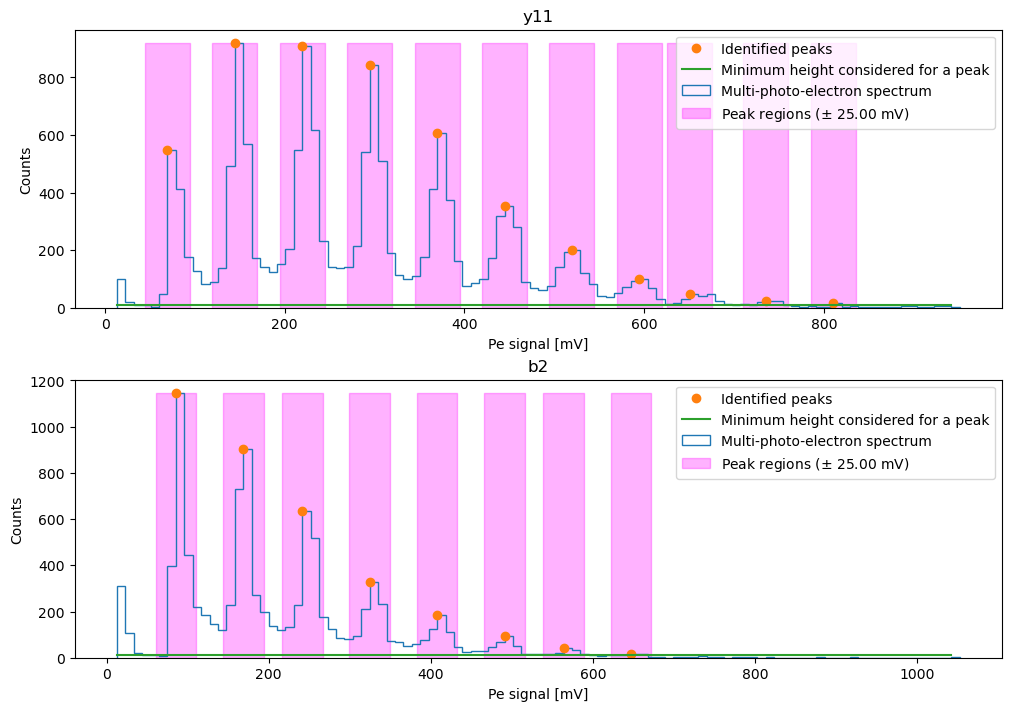

In [104]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,7), constrained_layout=True)

x_ax = {}
peaks = {}

for i, key in enumerate(['y11', 'b2']):

    events, bins, bars = ax[i].hist(pe_peaks[key], 100, 
                                 density=False, 
                                 label='Multi-photo-electron spectrum', 
                                 histtype='step')
    x_ax[key] = bins[:-1]
    diffs = np.abs(np.diff(bins))
    # accept_region = np.array(dV/diffs, dtype = int) # instead of defining the acceptance region by Voltage we define it in terms of bins
    accept_region = dV*np.ones(len(x_ax[key]))

    peaks[key], _ = find_peaks(events, height=height_min[key], threshold=dif_min[key], distance=dist_min[key])

    for ii in range(len(peaks[key])):
        ax[i].fill_between([(x_ax[key][peaks[key]] - accept_region[peaks[key]])[ii], 
                         (x_ax[key][peaks[key]] + accept_region[peaks[key]])[ii]], 
                        events[peaks[key]].max(), 
                        color = 'magenta', alpha = 0.3, label = r'Peak regions ($\pm$ %.2f mV)'%(dV)) 

    ax[i].plot(x_ax[key][peaks[key]], events[peaks[key]], 'o', label = 'Identified peaks')
    ax[i].plot(x_ax[key], height_min[key]*np.ones(len(x_ax[key])), label = 'Minimum height considered for a peak')

    ax[i].set_xlabel('Pe signal [mV]')
    ax[i].set_ylabel('Counts')
    ax[i].set_title(key)

    hand, labl = ax[i].get_legend_handles_labels()
    hand, labl = np.array(hand), np.array(labl)
    not_duplicated = ~pd.DataFrame(labl).duplicated()

    ax[i].legend(hand[not_duplicated], labl[not_duplicated], loc = 'best')
    # ax[i].legend(loc='best')

In [105]:
signal_pe = {}
n_pe = {}

In [107]:
for key in ['y11', 'b2']:
    signal_pe[key] = x_ax[key][peaks[key]]
    signal_pe[key] = signal_pe[key][signal_pe[key] > 50] # to make sure not to include the 0 pe
    n_pe[key] = len(signal_pe[key])
    
    print(r'Npe for %s fibers = '%(key), n_pe[key])
# print('Npe values = ', signal_pe)

Npe for y11 fibers =  11
Npe for b2 fibers =  8


In [30]:
import matplotlib as mpl
import copy

my_cmap = copy.copy(plt.get_cmap('plasma')) # copy the default cmap
my_cmap.set_bad(my_cmap.colors[0]) #  set the color of invalid or masked values in the colormap

t_peak = {}
t_peak['y11'] = 0.53
t_peak['b2'] = 0.083


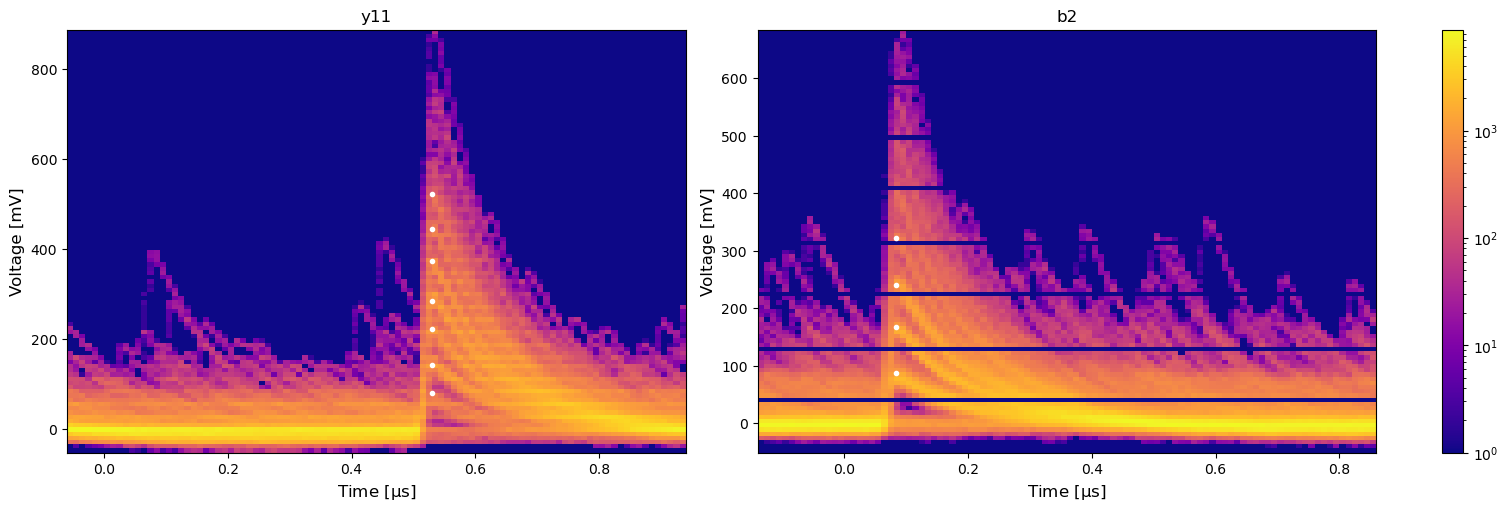

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5), constrained_layout=True)

for i, key in enumerate(waveform.keys()):

    counts, xedges, yedges, im = ax[i].hist2d(time[key][:500*n_points], signal[key][:500*n_points], 
                                           bins=100, rasterized=True, 
                                           range=((time[key].min(),time[key].max()), 
                                                  (signal[key].min(), signal[key].max())), 
                                           cmap=my_cmap, norm=mpl.colors.LogNorm(vmin = 1))

    for ii in range(n_pe[key]):
        ax[i].plot(t_peak[key], signal_pe[key][ii], 'ow', markersize = 3, label = '%s pe'%(ii))



    ax[i].set_xlabel(r"Time [$\mathrm{\mu}$s]", size='larger')
    ax[i].set_ylabel("Voltage [mV]", size='larger')
    ax[i].set_title(key)

    # ax[i].legend(loc = 'best')

fig.colorbar(im, ax = ax, orientation='vertical')
# fig.savefig("waveforms.pdf")

- <p style="font-size: 17px; color: black;"> Set fixed threshold to 50% of the single photo-electron.

In [32]:
th_fixed = .5*signal_pe['y11'][0] # [mV] Height at which we measure the time difference between LED and Signal

<h2> Waveform </h2>

-  <p style="font-size: 17px; color: black;"> Interpolate the waveform to create a function. </p>

In [33]:
frame = 23
# frame = 789
# frame = 3151
# frame = 1755; th = 57.38 # [mV]
# frame = 2031; th = 131.43 # [mV]
# frame = 266; th = 114.13 # [mV]
# frame = 1712
# frame = 4954

In [54]:
tt = {}
ss = {}
ll = {}

In [55]:
for key in waveform.keys():

    tt[key] = time[key][frame*n_points: (frame + 1)*n_points].copy()  # [us]
    ss[key] = signal[key][frame*n_points: (frame + 1)*n_points].copy() # [mV]
    ll[key] = LED[key][frame*n_points: (frame + 1)*n_points].copy() # [mV]

-  <p style="font-size: 17px; color: black;"> Time region where to look for signal. </p>

In [56]:
tt_min = {}
tt_max = {}
tt_region_mask = {}

In [57]:
tt_min['y11'] = 0.45 # [us]
tt_max['y11'] = 0.7 # [us]

tt_min['b2'] = 0. # [us]
tt_max['b2'] = 0.4 # [us]

In [58]:
for key in waveform.keys():
    tt_region_mask[key] = (tt[key] > tt_min[key]) & (tt[key] < tt_max[key]) # Where to look for the signal
    

- <p style="font-size: 17px; color: black;"> Threshold to consider a peak in this waveform.

In [59]:
th = {}

In [60]:
for key in waveform.keys():

    th[key] = max(0.8*signal_pe[key][0], min(0.8*ss[key][tt_region_mask[key]].max(), 0.8*ll[key].max()))

    if fix_th:
        th[key] = th_fixed

    print('threshold for %s fibers = %.2f mV'%(key, th[key]))

threshold for y11 fibers = 252.73 mV
threshold for b2 fibers = 189.11 mV


<p style="font-size: 17px; color: black;"> Data waveform

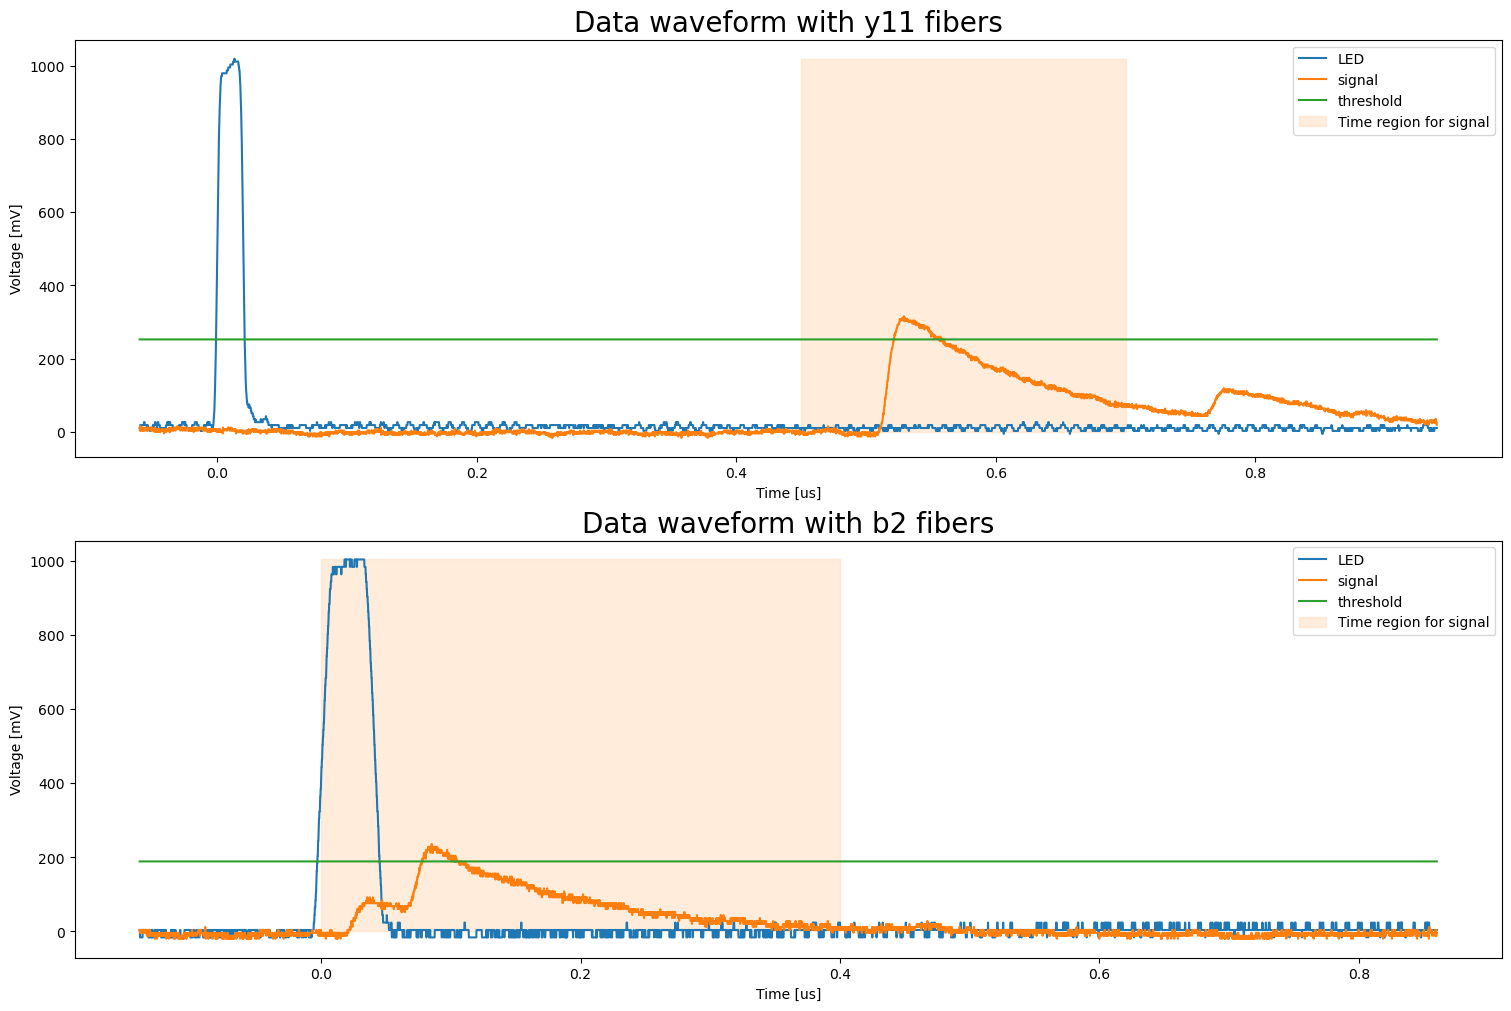

In [61]:
fig, ax = plt.subplots(2, 1, figsize = (15, 10), constrained_layout=True)

for i, key in enumerate(waveform.keys()):

    ax[i].plot(tt[key], ll[key], label = 'LED')
    ax[i].plot(tt[key], ss[key], label = 'signal')
    ax[i].plot(tt[key], th[key]*np.ones(len(tt[key])), label = 'threshold')

    ax[i].fill_between([tt_min[key], tt_max[key]], max(ll[key].max(), ss[key].max()), 
                    color = 'peachpuff', alpha = 0.5, label = r'Time region for signal') 

    ax[i].set_ylabel('Voltage [mV]');
    ax[i].set_xlabel('Time [us]');
    ax[i].set_title('Data waveform with %s fibers'%(key), size = 20);
    ax[i].legend(loc = 'best')

- <p style="font-size: 17px; color: black;"> Waveform interpolation and finding the cut with the threshold.

In [62]:
f_ss = {}
f_ll = {}

root_ss = {}
root_ll = {}

dt = {}

In [63]:
for key in waveform.keys():
    
    # Define the interpolation functions
    f_ss[key] = interp1d(tt[key], ss[key])
    f_ll[key] = interp1d(tt[key], ll[key])

    # Define the intervals where to search for roots
    t0 = tt[key][ss[key] - th[key] < 0.][0]
    tf_ss = tt[key][(tt[key] > tt_min[key]) & (ss[key] - th[key] > 0.)][0]
    tf_ll = tt[key][ll[key] - th[key] > 0.][0]

    # Find the roots of the new function for val = th
    root_ss[key] = root_scalar(f_cut, args=(f_ss[key], th[key],), bracket=[t0, tf_ss]).root
    root_ll[key] = root_scalar(f_cut, args=(f_ll[key], th[key],), bracket=[tt[key].min(), tf_ll]).root

    dt[key] = np.fabs(root_ss[key] - root_ll[key])
    print('dt[%s] = %.2f us'%(key, dt[key]))


dt[y11] = 0.52 us
dt[b2] = 0.08 us


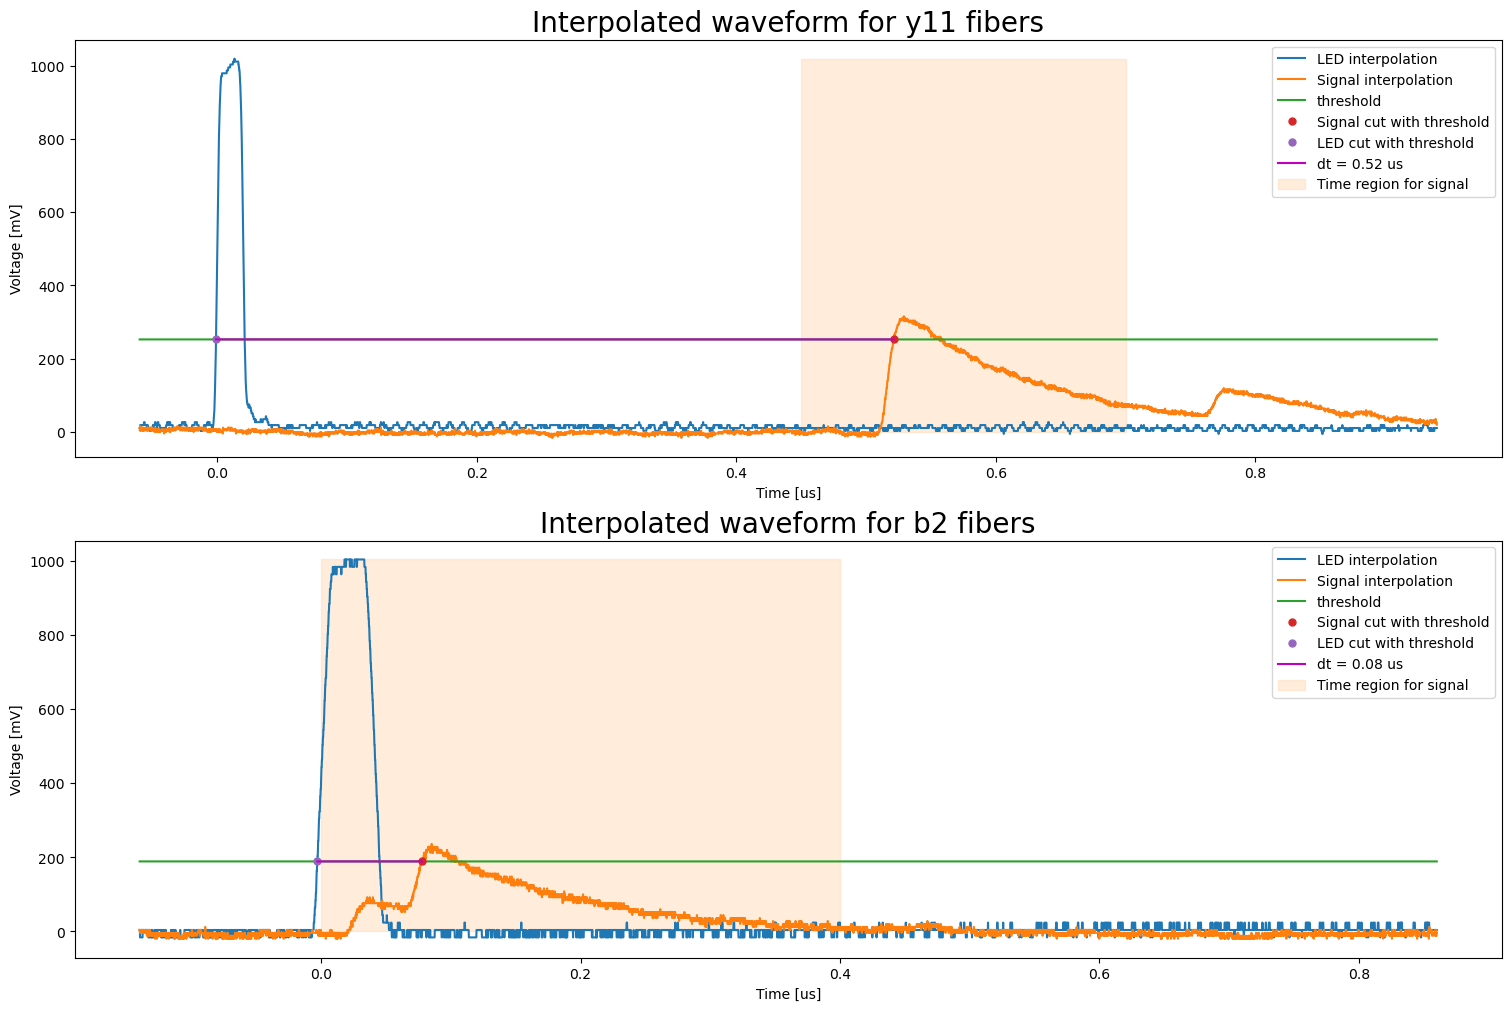

In [64]:
fig, ax = plt.subplots(2, 1, figsize = (15, 10), constrained_layout=True)

for i, key in enumerate(waveform.keys()):

    ax[i].plot(tt[key], f_ll[key](tt[key]), label = 'LED interpolation')
    ax[i].plot(tt[key], f_ss[key](tt[key]), label = 'Signal interpolation')
    ax[i].plot(tt[key], th[key]*np.ones(len(tt[key])), label = 'threshold')

    ax[i].fill_between([tt_min[key], tt_max[key]], max(ll[key].max(), ss[key].max()), 
                    color = 'peachpuff', alpha = 0.5, label = r'Time region for signal') 

    ax[i].plot(root_ss[key], th[key], 'o', markersize = 5, label = 'Signal cut with threshold')
    ax[i].plot(root_ll[key], th[key], 'o', markersize = 5, label = 'LED cut with threshold')
    ax[i].plot(np.linspace(root_ss[key], root_ll[key], len(tt[key])), 
               th[key]*np.ones(len(tt[key])), '-m', label = 'dt = %.2f us'%(dt[key]))

    ax[i].set_ylabel('Voltage [mV]');
    ax[i].set_xlabel('Time [us]');
    ax[i].set_title('Interpolated waveform for %s fibers'%(key), size = 20);
    ax[i].legend(loc = 'best')

<h2> Difference in time calculation for all frames </h2>

- <p style="font-size: 17px; color: black;"> Note how we're working with the fact that the signal appears in a certain time region to constrain the valid region of signal we use using the mask.

In [65]:
f_ss = {}
f_ll = {}

root_ss = {}
root_ll = {}

dt = {'y11':[], 'b2':[]}

s_peak = {'y11':[], 'b2':[]}


for key in waveform.keys():
    print('\n%s fibers_______________________________________'%(key))
    try:
        for frame in range(n_frames):

            tt = time[key][frame*n_points: (frame + 1)*n_points].copy()  # [us]
            ss = signal[key][frame*n_points: (frame + 1)*n_points].copy() # [mV]
            ll = LED[key][frame*n_points: (frame + 1)*n_points].copy() # [mV]

            tt_region_mask = (tt > tt_min[key]) & (tt < tt_max[key]) # Where to look for the signal

            th = max(0.8*signal_pe[key][0], min(0.8*ss[tt_region_mask].max(), 0.8*ll.max()))

            if fix_th:
                th = th_fixed

            if ss[tt_region_mask].max() < th: 
                print('NO SIGNAL HERE! frame = %s; th = %.2f # [mV]'%(frame, th))
                continue

            if ss[tt_region_mask][0] > th: 
                print('This is not signal, it is the tail of a noise pulse! frame = %s; th = %.2f # [mV]'%(frame, th))
                continue

            # Define the interpolation functions
            f_ss = interp1d(tt, ss) 
            f_ll = interp1d(tt, ll)

            # Define the intervals where to search for roots
            t0 = tt[ss - th < 0.][0]
            tf_ss = tt[(tt > tt_min[key]) & (ss - th > 0.)][0]
            tf_ll = tt[ll - th > 0.][0]

            # Find the roots of the new function for val = th
            root_ss = root_scalar(f_cut, args=(f_ss, th,), bracket=[t0, tf_ss]).root
            root_ll = root_scalar(f_cut, args=(f_ll, th,), bracket=[tt.min(), tf_ll]).root

            s_peak[key].append(ss.max())
            dt[key].append(np.fabs(root_ss - root_ll))

    except Exception as e:
        print("Python sais:", str(e))
        print("Marian sais: Error accured for fiber %s in frame %s"%(key, frame))

    dt[key] = np.array(dt[key])
    s_peak[key] = np.array(s_peak[key])
    


y11 fibers_______________________________________
NO SIGNAL HERE! frame = 1; th = 59.83 # [mV]
NO SIGNAL HERE! frame = 2; th = 59.83 # [mV]
NO SIGNAL HERE! frame = 12; th = 59.83 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 27; th = 339.13 # [mV]
NO SIGNAL HERE! frame = 32; th = 59.83 # [mV]
NO SIGNAL HERE! frame = 60; th = 59.83 # [mV]
NO SIGNAL HERE! frame = 61; th = 59.83 # [mV]
NO SIGNAL HERE! frame = 94; th = 59.83 # [mV]
NO SIGNAL HERE! frame = 118; th = 59.83 # [mV]
NO SIGNAL HERE! frame = 125; th = 59.83 # [mV]
NO SIGNAL HERE! frame = 126; th = 59.83 # [mV]
NO SIGNAL HERE! frame = 142; th = 59.83 # [mV]
NO SIGNAL HERE! frame = 158; th = 59.83 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 170; th = 59.83 # [mV]
NO SIGNAL HERE! frame = 176; th = 59.83 # [mV]
NO SIGNAL HERE! frame = 193; th = 59.83 # [mV]
NO SIGNAL HERE! frame = 201; th = 59.83 # [mV]
NO SIGNAL HERE! frame = 254; th = 59.83 # [mV]
NO SIGNAL HERE! frame = 275; th = 59.8

NO SIGNAL HERE! frame = 1219; th = 71.09 # [mV]
NO SIGNAL HERE! frame = 1235; th = 71.09 # [mV]
NO SIGNAL HERE! frame = 1240; th = 71.09 # [mV]
NO SIGNAL HERE! frame = 1246; th = 71.09 # [mV]
NO SIGNAL HERE! frame = 1248; th = 71.09 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 1250; th = 118.71 # [mV]
NO SIGNAL HERE! frame = 1256; th = 71.09 # [mV]
NO SIGNAL HERE! frame = 1264; th = 71.09 # [mV]
NO SIGNAL HERE! frame = 1267; th = 71.09 # [mV]
NO SIGNAL HERE! frame = 1301; th = 71.09 # [mV]
NO SIGNAL HERE! frame = 1309; th = 71.09 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 1318; th = 137.91 # [mV]
NO SIGNAL HERE! frame = 1324; th = 71.09 # [mV]
This is not signal, it is the tail of a noise pulse! frame = 1325; th = 137.91 # [mV]
NO SIGNAL HERE! frame = 1352; th = 71.09 # [mV]
NO SIGNAL HERE! frame = 1362; th = 71.09 # [mV]
NO SIGNAL HERE! frame = 1380; th = 71.09 # [mV]
NO SIGNAL HERE! frame = 1382; th = 71.09 # [mV]
NO SIGNAL HERE! frame 

<h2> Peak identification </h2>

In [66]:
mask_pe = {'y11':[], 'b2':[]}

for key in waveform.keys():
    for i in range(n_pe[key]):
        mask_pe[key].append(np.fabs(s_peak[key] - signal_pe[key][i]) <= dV) # for fixed dV
#         mask_pe[key].append(np.fabs(s_peak[key] - signal_pe[key][i]) <= accept_region[i]) # for fixed number of bins


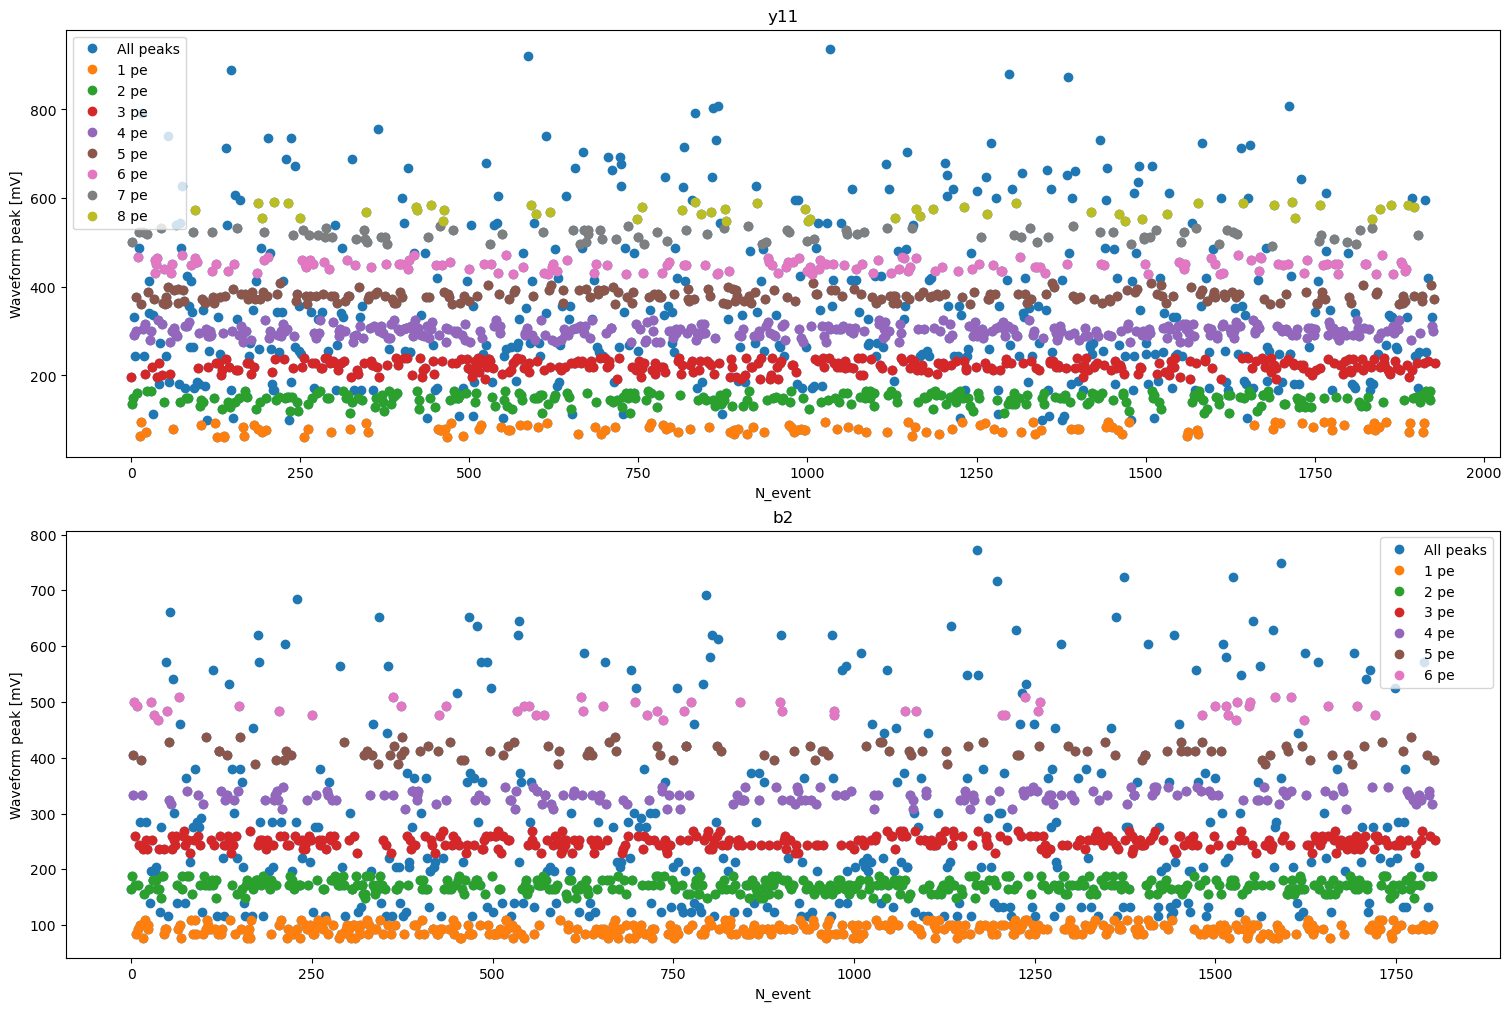

In [67]:
fig, ax = plt.subplots(2, 1, figsize = (15, 10), constrained_layout=True)

for i, key in enumerate(waveform.keys()):

    #______________________plot settings________________________________________________________

    x_ax = np.arange(len(s_peak[key]))

    ax[i].plot(x_ax, s_peak[key], 'o', label = 'All peaks')

    for ii in range(len(mask_pe[key])):
        ax[i].plot(x_ax[mask_pe[key][ii]], s_peak[key][mask_pe[key][ii]], 'o', label = '%s pe'%(ii + 1))

    ax[i].set_ylabel('Waveform peak [mV]');
    ax[i].set_xlabel('N_event');
    ax[i].set_title(key);

    # ax[i].set_xlim([0, 20])
    # ax[i].set_ylim([s_peak[key].min(), 150])
    ax[i].legend(loc = 'best')


<h2> Time resolution calculation </h2>

In [68]:
from scipy.stats import chisquare

observed = np.array([10, 20, 30])
expected = np.array([15, 15, 30])

chi2, p_value = chisquare(observed, expected)

print('chi^2 =', chi2)
print('p-value =', p_value)


chi^2 = 3.3333333333333335
p-value = 0.1888756028375618


In [69]:
len(events), len(bins[:-1]), len(x_ax)

(100, 100, 1804)

In [70]:
t_res = {}
t_res_err = {}

for key in waveform.keys():
    
    t_res[key] = np.zeros(n_pe[key])
    t_res_err[key] = np.zeros(n_pe[key])

- <p style="font-size: 17px; color: black;"> Y11 fibers $dt$ distribution.

In [71]:
key = 'y11'

/tmp/ipykernel_4339/690897811.py:50: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_4339/690897811.py:50: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_4339/690897811.py:50: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_4339/690897811.py:50: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_4339/690897811.py:50: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_4339/690897811.py:50: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)*

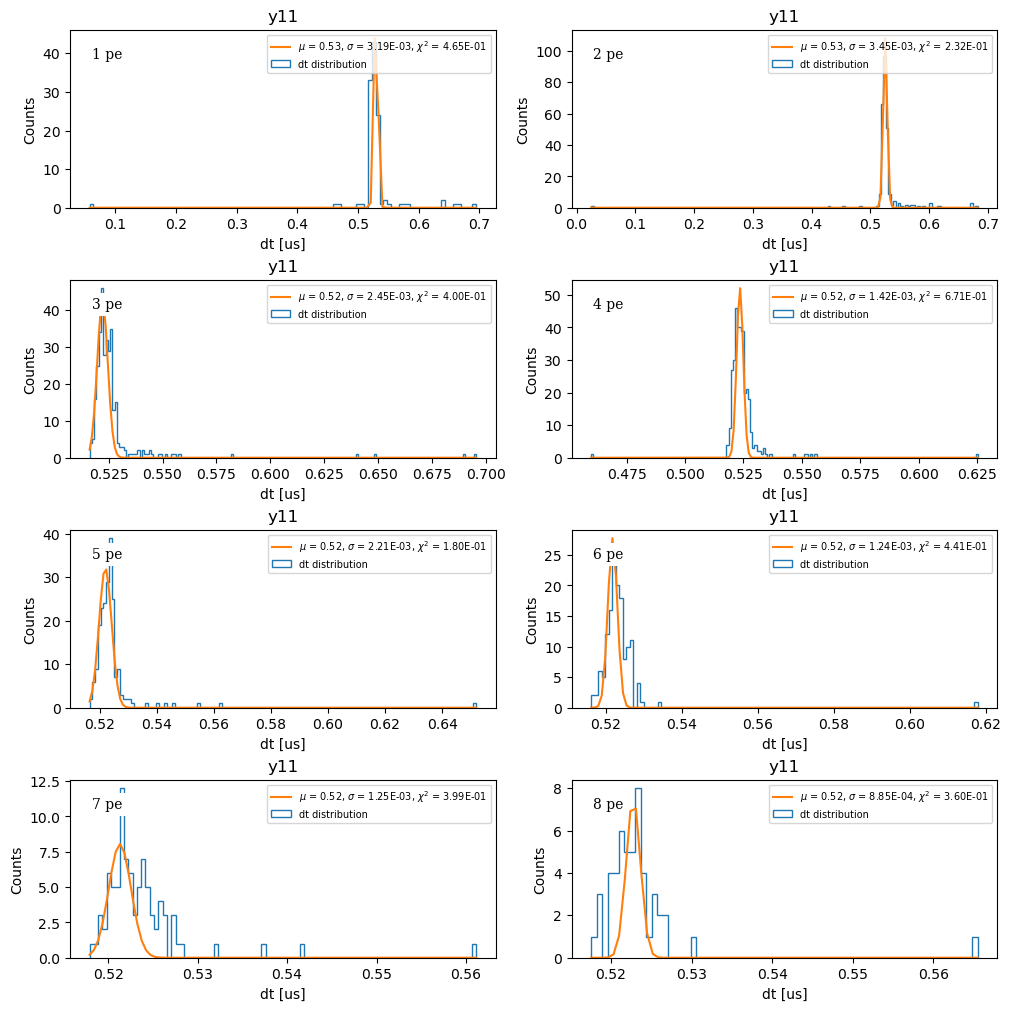

In [74]:
fig, ax = plt.subplots(nrows = math.ceil(n_pe[key]/2.), ncols = 2, figsize=(10,10), constrained_layout=True)

n_row = 0

for pe in range(n_pe[key]):
    
    n_col = pe%2
    
    N_ev = len(dt[key][mask_pe[key][pe]])
    n_bins = int(np.sqrt(N_ev))
    n_bins = 10*int(np.sqrt(N_ev))
#     n_bins = 100
    
    region_min = 0.022
    region_max = .06
    if (pe + 1 >= 6):
        region_max = 0.045
    if (pe + 1 > 7):
        region_max = 0.04
    
    events, bins, bars = ax[n_row, n_col].hist(dt[key][mask_pe[key][pe]], n_bins, 
                                               density=False,
#                                                range=(region_min, region_max),
                                               label='dt distribution', 
                                               histtype='step')
    
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)
    y_err = np.sqrt(events)
    
    ev_th = events.sum()/10
        
    # gaussian fit
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, 
                                          sigma = np.where(y_err > 0., y_err, 1e-3),
                                          p0=[events.sum(), (bins[:-1])[events > ev_th].mean(), 0.001]) 
#                                           bounds=([1,  0.9*bins.mean(), 1e-4], [3., bins.mean(), 1e-2])) 


#     best_fit_line = gauss(x_ax, *popt)
    best_fit_line = gauss(x_ax, *popt)*events.sum()/gauss(x_ax, *popt).sum()
    a, mu, sigma = popt
    
    param_err = np.sqrt(np.diag(pcov))
    a_err, mu_err, sigma_err = param_err
    
    # Calculate p-value and chi-square
    residuals = events - gauss(x_ax, *popt)
    data_err = np.sqrt(events)
    
    chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
    chi2 /= len(bins)
    
    t_res[key][pe] = sigma
    t_res_err[key][pe] = sigma_err

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, gauss(x_ax, a, mu, sigma), '-', 
                          label='$\mu$ = %.2f, $\sigma$ = %.2E, $\chi^{2}$ = %.2E'%(mu, sigma, chi2))
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('dt [us]')
    ax[n_row, n_col].set_title(key)

    ax[n_row, n_col].legend(fontsize=7, loc='upper right')
    
    n_row += pe%2
    

- <p style="font-size: 17px; color: black;"> B2 fibers $dt$ distribution.

In [75]:
key = 'b2'

/tmp/ipykernel_4339/2065334328.py:50: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_4339/2065334328.py:50: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_4339/2065334328.py:50: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_4339/2065334328.py:50: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_4339/2065334328.py:50: RuntimeWarning: divide by zero encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
/tmp/ipykernel_4339/2065334328.py:50: RuntimeWarning: invalid value encountered in true_divide
  chi2 = np.sum( np.where(data_err > 0., (residuals/ data

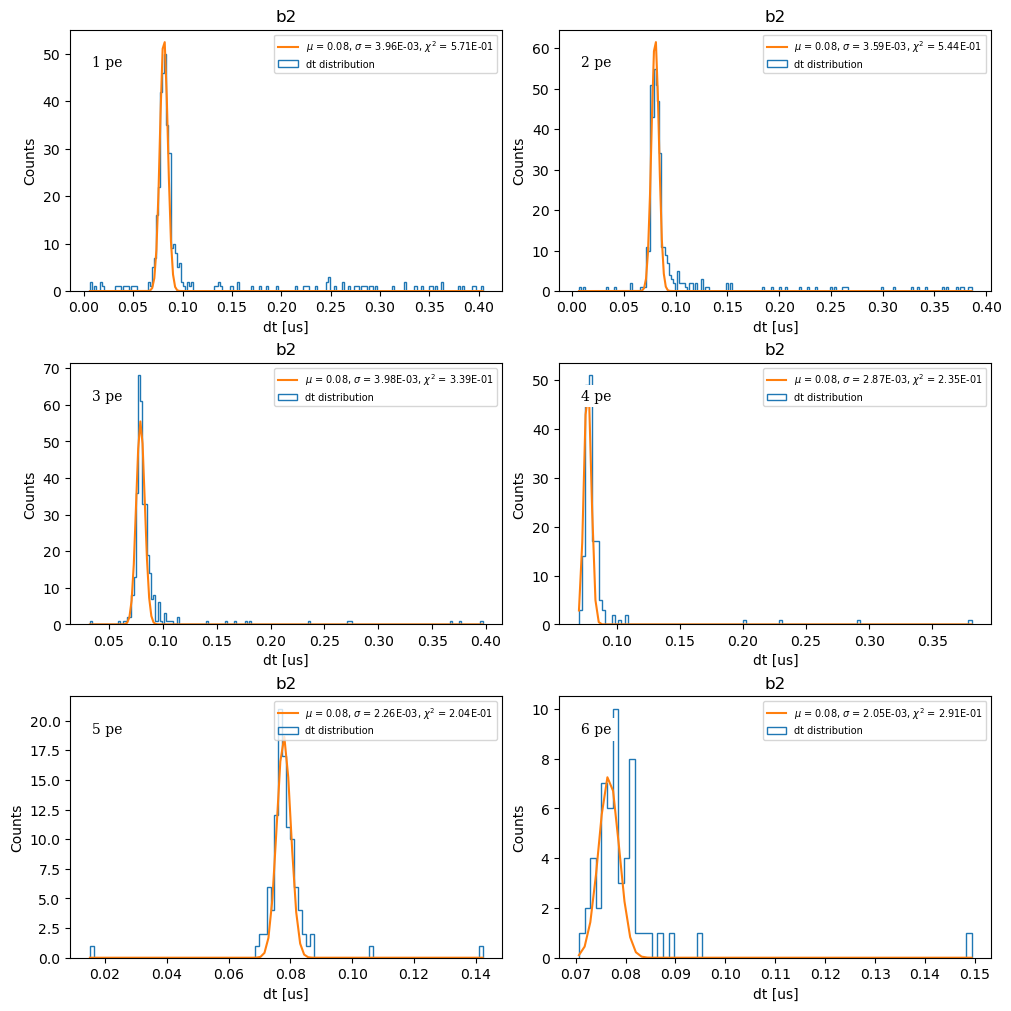

In [76]:
fig, ax = plt.subplots(nrows = math.ceil(n_pe[key]/2.), ncols = 2, figsize=(10,10), constrained_layout=True)

n_row = 0

for pe in range(n_pe[key]):
    
    n_col = pe%2
    
    N_ev = len(dt[key][mask_pe[key][pe]])
    n_bins = int(np.sqrt(N_ev))
    n_bins = 10*int(np.sqrt(N_ev))
#     n_bins = 100
    
    region_min = 0.022
    region_max = .06
    if (pe + 1 >= 6):
        region_max = 0.045
    if (pe + 1 > 7):
        region_max = 0.04
    
    events, bins, bars = ax[n_row, n_col].hist(dt[key][mask_pe[key][pe]], n_bins, 
                                               density=False,
#                                                range=(region_min, region_max),
                                               label='dt distribution', 
                                               histtype='step')
    
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)
    y_err = np.sqrt(events)
    
    ev_th = events.sum()/10
    
    # gaussian fit
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, 
                                          sigma = np.where(y_err > 0., y_err, 1e-3),
                                          p0=[events.sum(), (bins[:-1])[events > ev_th].mean(), 0.001]) 
#                                           bounds=([1,  0.9*bins.mean(), 1e-4], [3., bins.mean(), 1e-2])) 


#     best_fit_line = gauss(x_ax, *popt)
    best_fit_line = gauss(x_ax, *popt)*events.sum()/gauss(x_ax, *popt).sum()
    a, mu, sigma = popt
    
    param_err = np.sqrt(np.diag(pcov))
    a_err, mu_err, sigma_err = param_err
    
    # Calculate p-value and chi-square
    residuals = events - gauss(x_ax, *popt)
    data_err = np.sqrt(events)
    
    chi2 = np.sum( np.where(data_err > 0., (residuals/ data_err)**2, 0.) );
    chi2 /= len(bins)
    
    t_res[key][pe] = sigma
    t_res_err[key][pe] = sigma_err

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, gauss(x_ax, a, mu, sigma), '-', 
                          label='$\mu$ = %.2f, $\sigma$ = %.2E, $\chi^{2}$ = %.2E'%(mu, sigma, chi2))
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('dt [us]')
    ax[n_row, n_col].set_title(key)

    ax[n_row, n_col].legend(fontsize=7, loc='upper right')
    
    n_row += pe%2
    

- <p style="font-size: 17px; color: black;"> Time resolution vs $N_{pe}$.

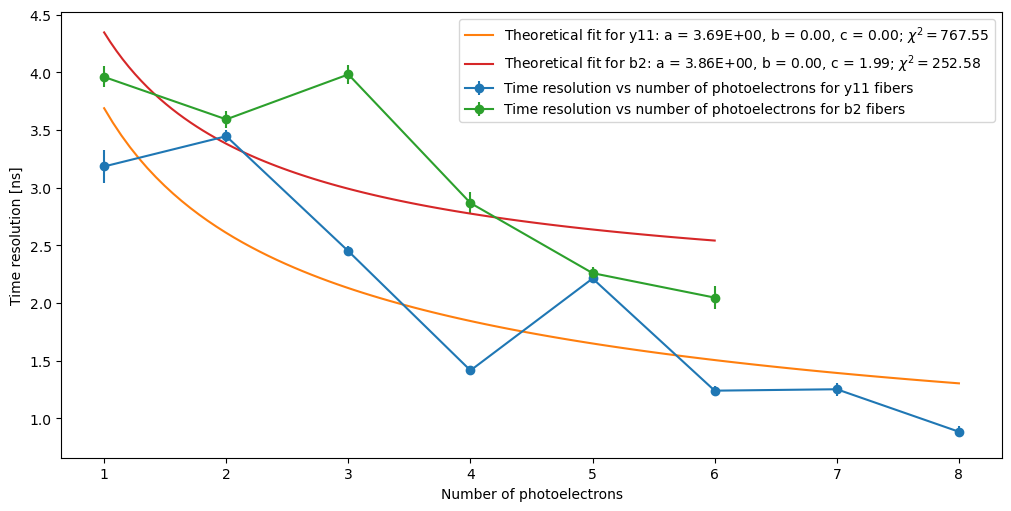

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

for key in waveform.keys():
    
    x_ax = np.arange(len(t_res[key])) + 1

    ax.errorbar(x_ax, t_res[key]*1e3, yerr = t_res_err[key]*1e3, 
                fmt = '-o', label = 'Time resolution vs number of photoelectrons for %s fibers'%(key))

    ax.set_ylabel('Time resolution [ns]')
    ax.set_xlabel('Number of photoelectrons')


    # Resolution fit
    #     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 20.]) 
    popt, pcov = scipy.optimize.curve_fit(resolution_eq, x_ax, t_res[key]*1e3, 
                                          bounds=([0., 0., 0.], [np.inf, np.inf, np.inf])) 

    aa, bb, cc = popt


    # Calculate the residuals and chi-square
    residuals = t_res[key]*1e3 - resolution_eq(x_ax, *popt)
    data_err = t_res_err[key]*1e3

    chi2 = np.sum(np.where(data_err > 0., (residuals/ data_err)**2, 0.))


    x_ax_fit = np.linspace(x_ax.min(), x_ax.max(), 100)
    best_fit_line = resolution_eq(x_ax_fit, aa, bb, cc)

    ax.plot(x_ax_fit, best_fit_line, '-', 
            label='Theoretical fit for %s: a = %.2E, b = %.2f, c = %.2f; $\chi^{2} = %.2f$'%(key, aa, bb, cc, chi2))

    ax.legend(loc = 'best')
    

<p style="font-size: 17px; color: black;"> Energy resolution calculation

628.0 628.0000000000001 628.0000000000001
763.0 763.0 763.0000000000001
563.0 563.0000000000001 563.0000000000001
299.0 299.00000000000006 299.00000000000006
170.0 170.00000000000006 170.00000000000003
46.0 46.0 46.00000000000001


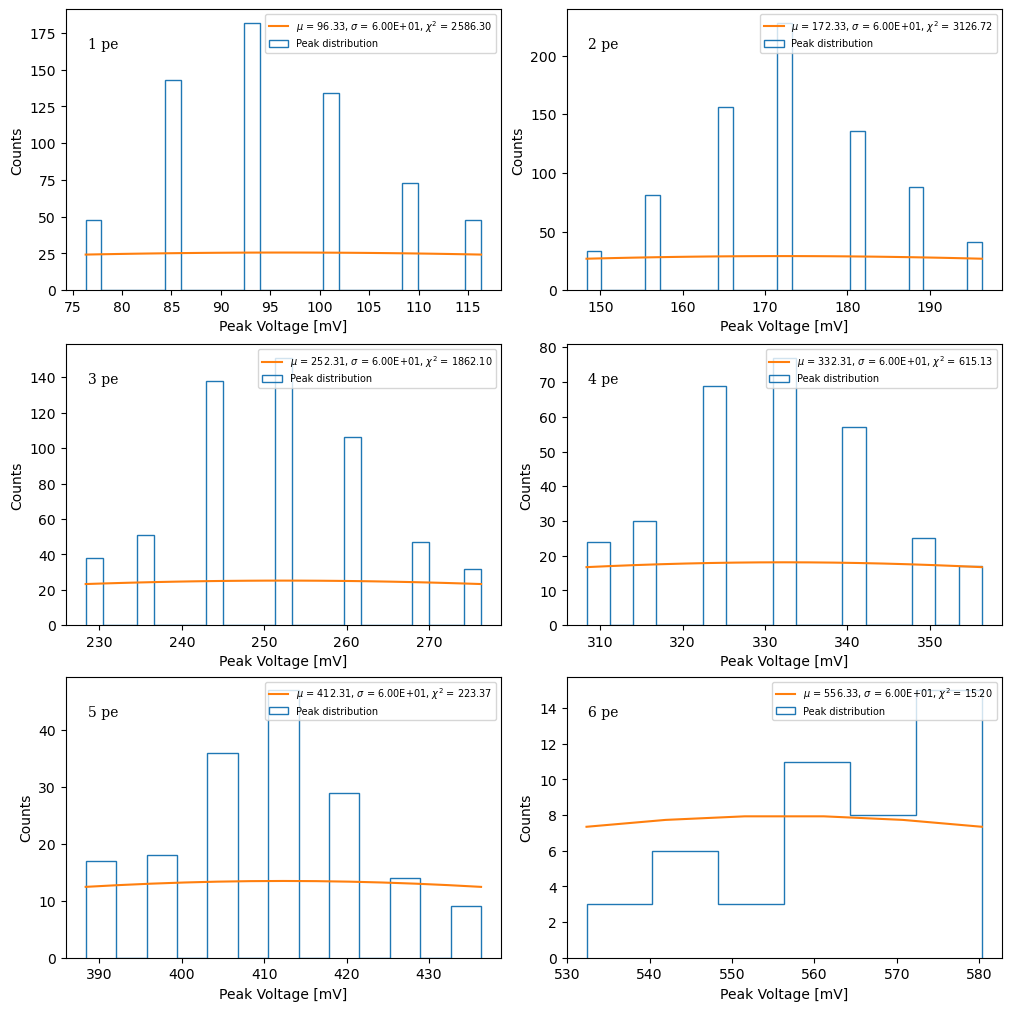

In [57]:
fig, ax = plt.subplots(nrows=int(np.ceil(n_pe/2)), ncols=2, figsize=(10,10), constrained_layout=True)

n_row = 0

e_res = np.zeros(n_pe)
e_res_err = np.zeros(n_pe)

for pe in range(n_pe):
    
    n_col = pe%2
    
    N_ev = len(s_peak[mask_pe[pe]])
#     n_bins = 5*int(np.sqrt(N_ev))
    n_bins = int(np.sqrt(N_ev))
    
    events, bins, bars = ax[n_row, n_col].hist(s_peak[mask_pe[pe]], n_bins, 
                                     density=False, 
#                                                range=(0.08, 0.15),
                                     label='Peak distribution', 
                                     histtype='step')
    x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

#     # gaussian fit
#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 20.]) 
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, 
                                          sigma = np.where(events > 0., np.sqrt(events), 1e-3),
                                          bounds=([events.sum(),  0.9*bins.mean(), 10.], [np.inf, bins.mean(), 60.])) 
    
    best_fit_line = gauss(x_ax, *popt)
    a, mu, sigma = popt
    
    print(events.sum(), best_fit_line.sum(), a)
    
    param_err = np.sqrt(np.diag(pcov))
    a_err, mu_err, sigma_err = param_err
    
#     # Calculate the residuals and chi-square
#     residuals = events - gauss(x_ax, *popt)
#     data_err = np.sqrt(events)
    
#     chi2 = np.sum(np.where(data_err > 0., (residuals/ data_err)**2, 0.))
    
    # Calculate p-value and chi-square
    fit_norm = best_fit_line*events.sum()/best_fit_line.sum() # need to normalize the fit 
    chi2, p_value = stats.chisquare(f_obs = events, f_exp = fit_norm, axis = None)
#     chi2, p_value = stats.chisquare(f_obs = events, f_exp = best_fit_line, axis = None)
    
    e_res[pe] = 100*sigma/mu
    e_res_err[pe] = 100*np.sqrt( (sigma_err/mu)**2 + (sigma*mu_err/mu**2)**2 )

    #_________plot_settings_________________________________________________

    ax[n_row, n_col].plot(x_ax, best_fit_line, '-', 
                          label='$\mu$ = %.2f, $\sigma$ = %.2E, $\chi^{2}$ = %.2f'%(mu, sigma, chi2))
    
    ax[n_row, n_col].text(0.05, .9, str(pe+1) + ' pe', transform=ax[n_row, n_col].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0))

    ax[n_row, n_col].set_ylabel('Counts')
    ax[n_row, n_col].set_xlabel('Peak Voltage [mV]')

    ax[n_row, n_col].legend(fontsize=7, loc='best')
    
    n_row += pe%2
    

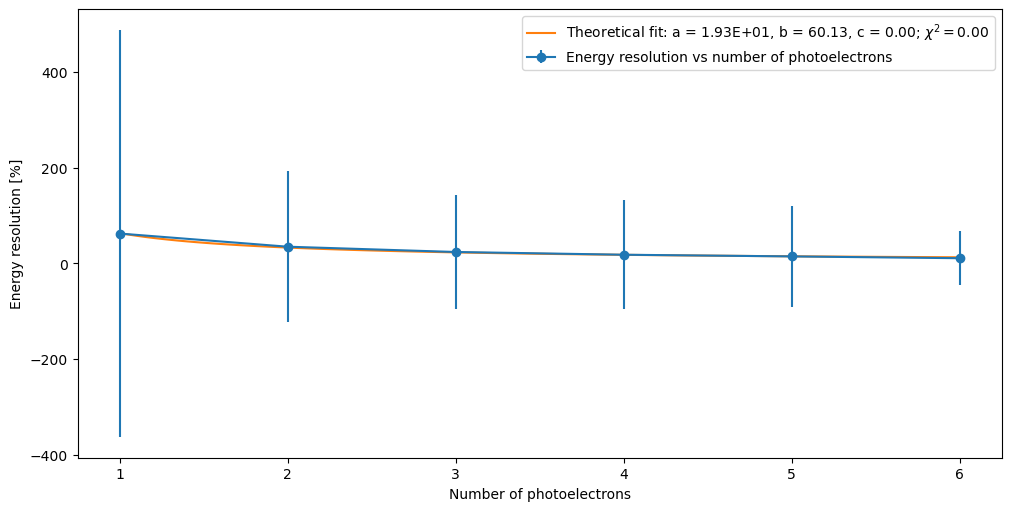

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

x_ax = np.arange(len(e_res)) + 1


ax.errorbar(x_ax, e_res, yerr = e_res_err, fmt = '-o', label = 'Energy resolution vs number of photoelectrons')

ax.set_ylabel('Energy resolution [%]')
ax.set_xlabel('Number of photoelectrons')



# Resolution fit
#     popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 20.]) 
popt, pcov = scipy.optimize.curve_fit(resolution_eq, x_ax, e_res, 
                                      bounds=([0., 0., 0.], [np.inf, np.inf, np.inf])) 

aa, bb, cc = popt


# Calculate the residuals and chi-square
residuals = e_res - resolution_eq(x_ax, *popt)
data_err = e_res_err

chi2 = np.sum(np.where(data_err > 0., (residuals/ data_err)**2, 0.))


x_ax_fit = np.linspace(x_ax.min(), x_ax.max(), 100)
best_fit_line = resolution_eq(x_ax_fit, aa, bb, cc)

ax.plot(x_ax_fit, best_fit_line, '-', 
        label='Theoretical fit: a = %.2E, b = %.2f, c = %.2f; $\chi^{2} = %.2f$'%(aa, bb, cc, chi2))

    
ax.legend(loc = 'best')